In [356]:
%load_ext autoreload
%autoreload 2
from data import *
from visualisation2 import *
import numpy as np
# from analysis import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


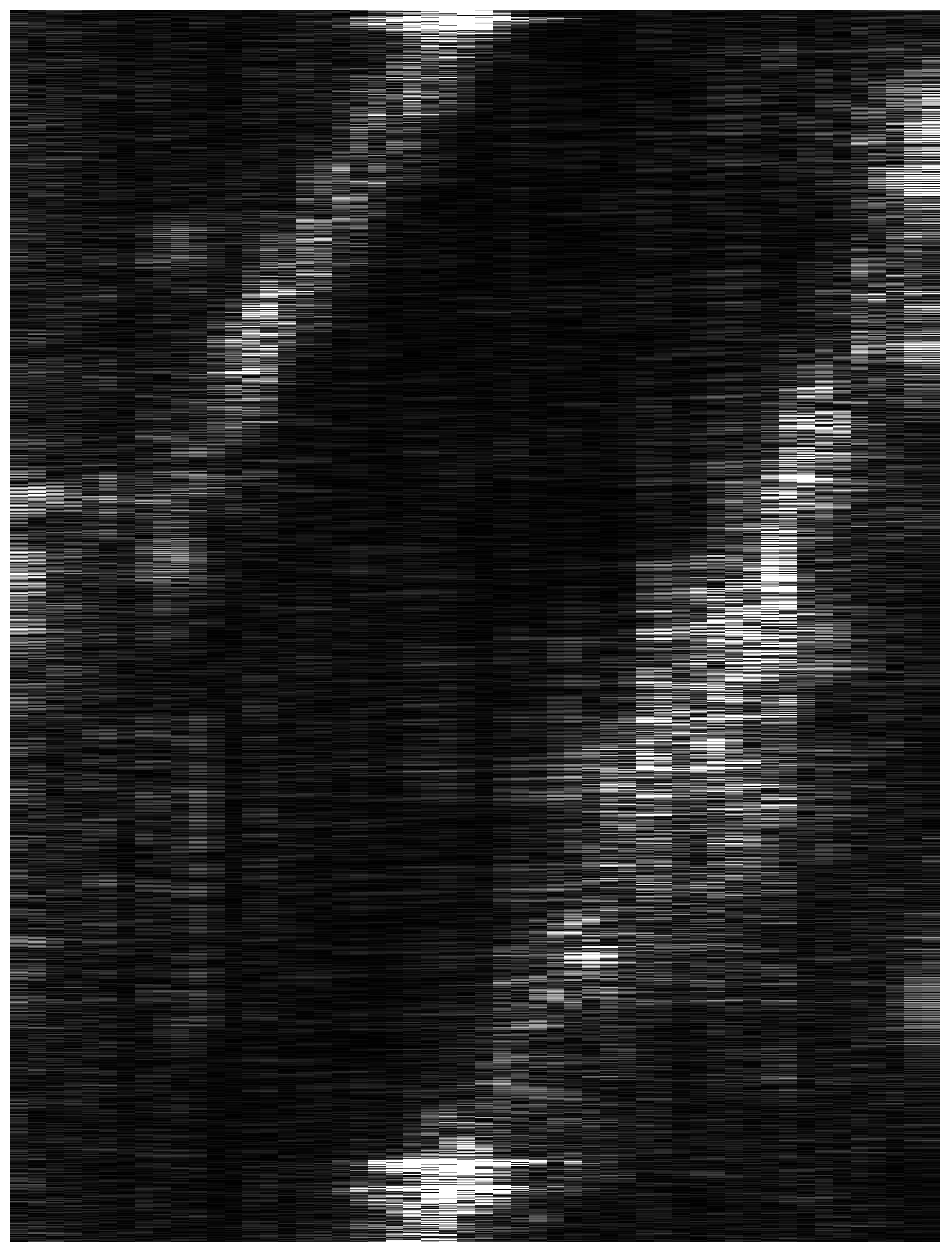

In [357]:
from visualisation import plot_timeframe
import numpy as np
from data import load_from_file, prepocess

import cv2

filename = "090332.npy"

data = load_from_file(filename)
# plot_timeframe(data)

img = data.to_numpy()

img = prepocess(img)
original_img = img.copy()

plot_numpy(img)




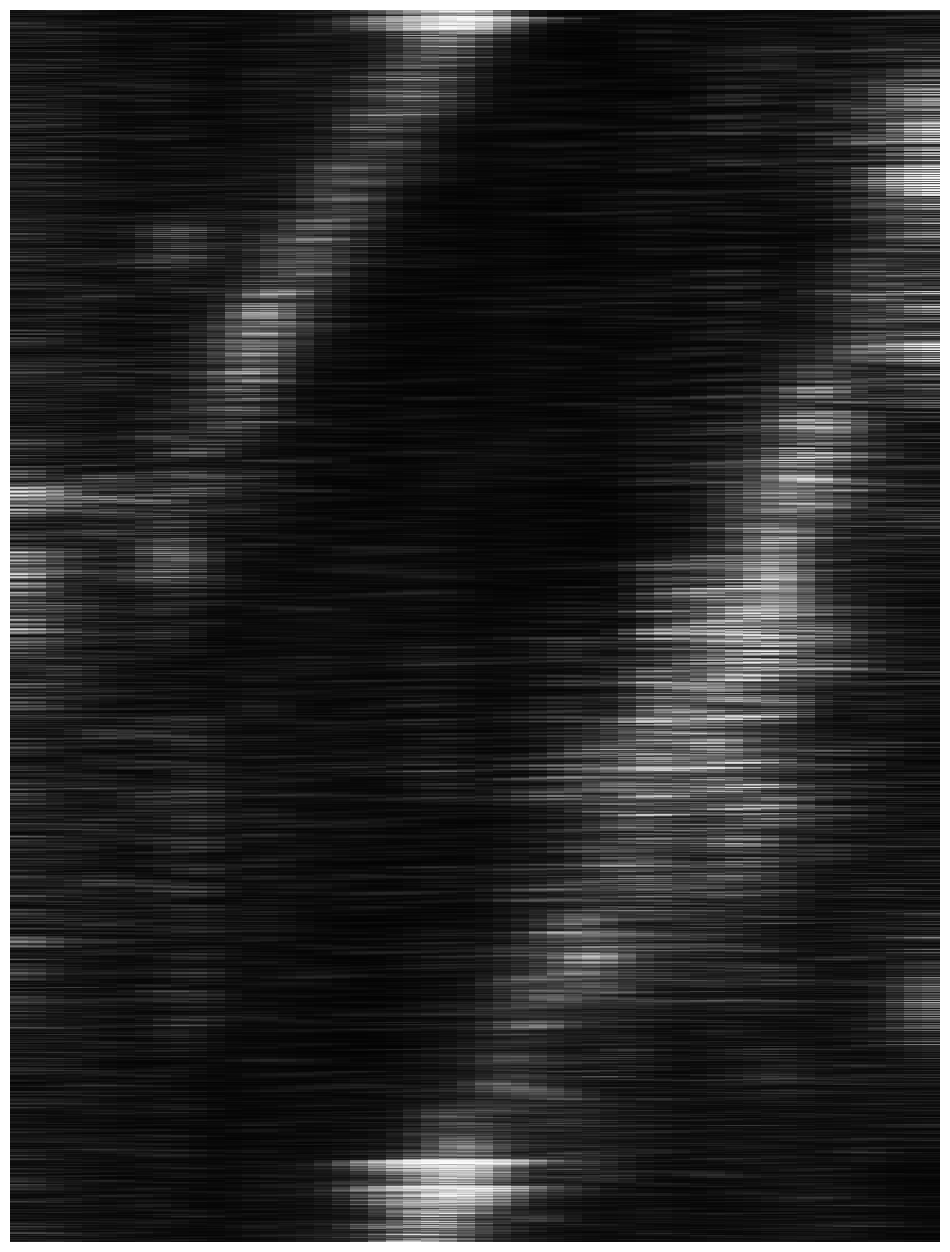

In [358]:
img = cv2.GaussianBlur(img, (5, 5), 0)
plot_numpy(img)

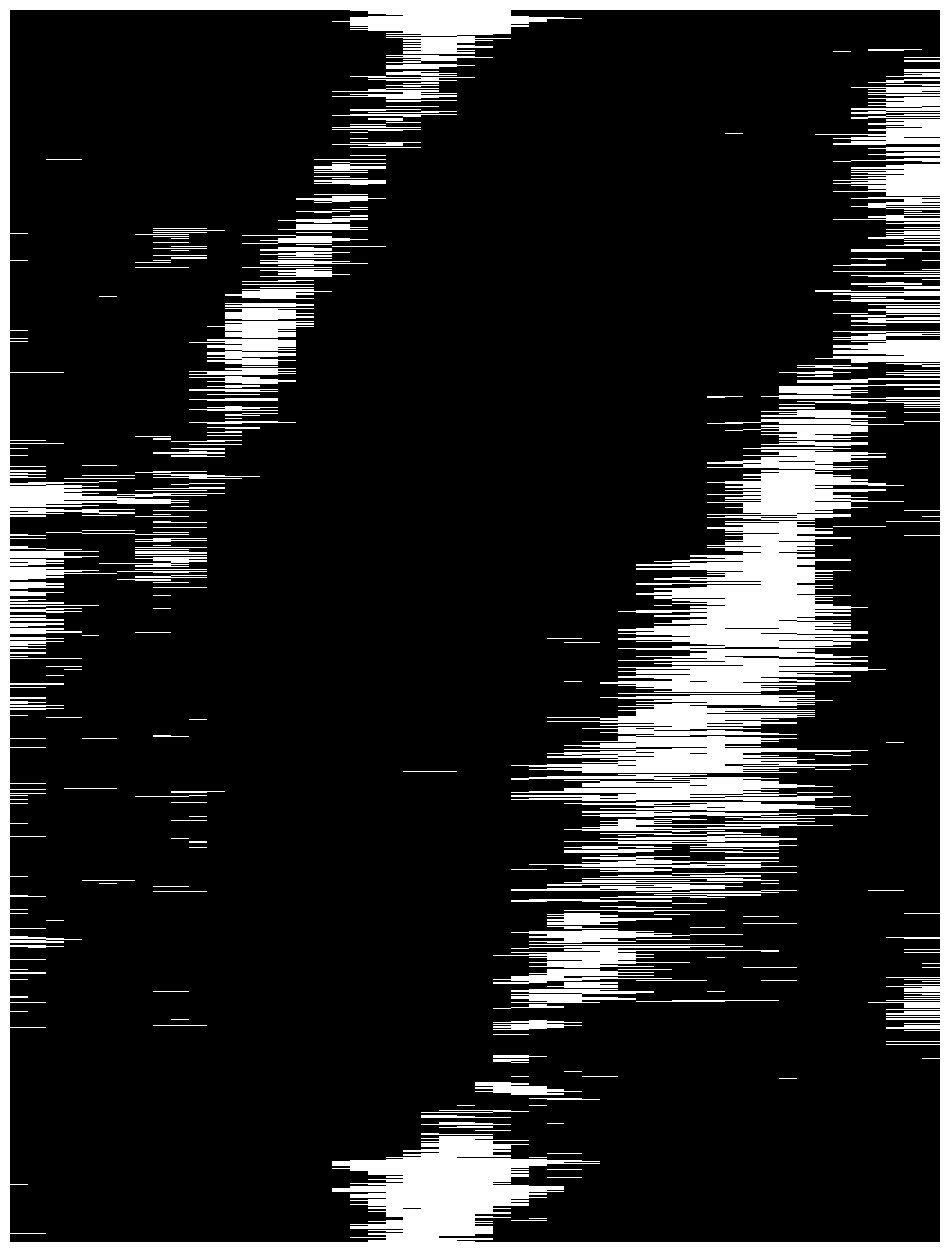

In [359]:
tr, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# tr, img2 = cv2.threshold(img2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


plot_numpy(img)


In [360]:
def proper_opening(image, kernel=(3,3)):
    close1 = cv2.morphologyEx(
        image, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, kernel), iterations=1
    )
    open1 = cv2.morphologyEx(
        close1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, kernel), iterations=1
    )
    close2 = cv2.morphologyEx(
        open1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, kernel), iterations=1
    )
    return np.minimum(image, close2)


img = proper_opening(img, kernel=(3,3))

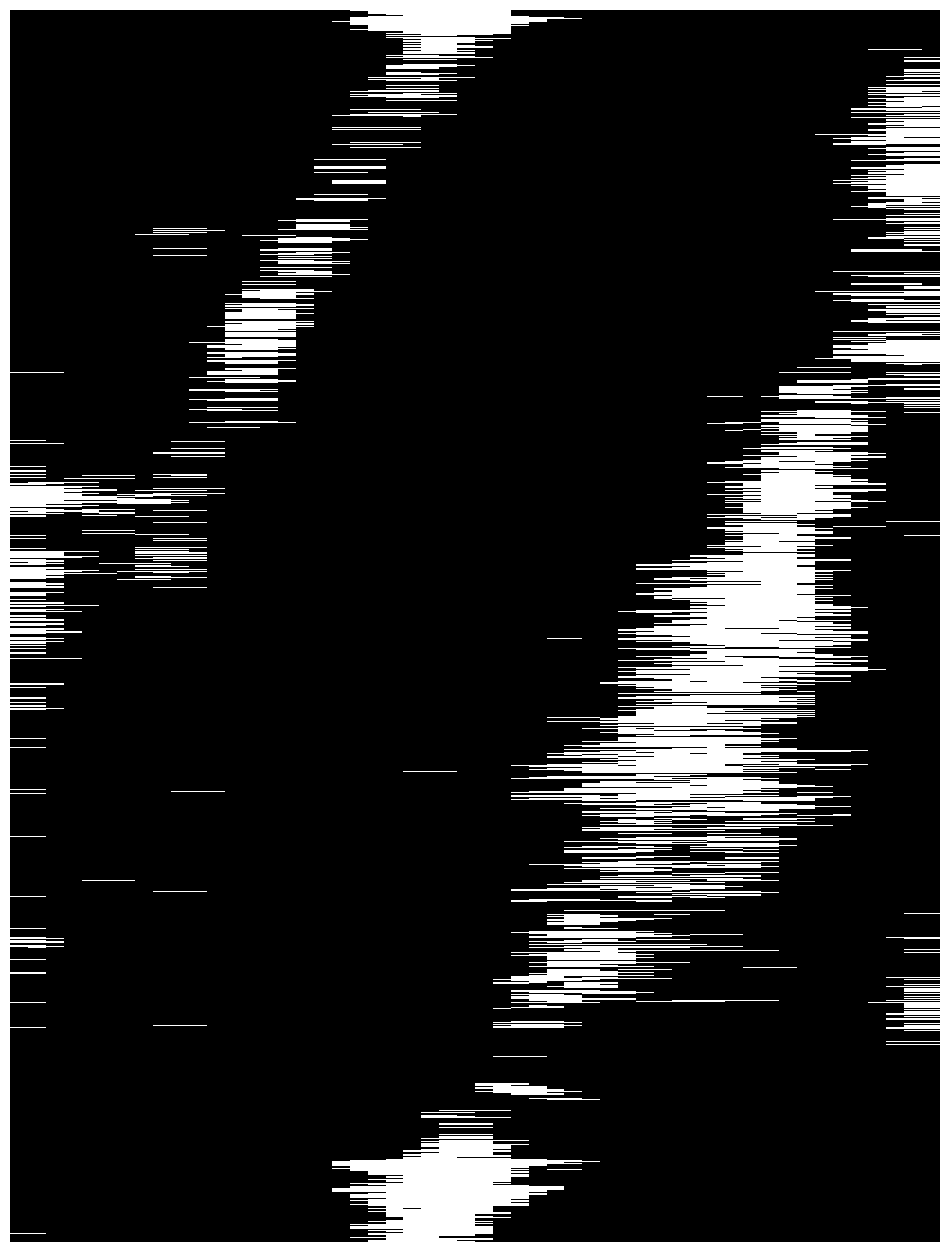

In [361]:
plot_numpy(img)

In [362]:
img.shape

(6250, 52)

In [363]:
def generate_colors(num_colors):
    hsv_colors = [(i / num_colors, 1.0, 1.0) for i in range(num_colors)]
    rgb_colors = [plt.cm.hsv(h)[:3] for h, _, _ in hsv_colors]
    rgb_colors = (np.array(rgb_colors) * 255).astype(np.uint8)
    np.random.shuffle(rgb_colors)
    return rgb_colors

In [364]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

X = np.nonzero(img)
X = np.vstack(X).T

X.shape
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
clustering = DBSCAN(eps=0.08, min_samples=300).fit(X_scaled)

no_of_clusters = np.max(clustering.labels_)+1
print(no_of_clusters)


3


Number of clusters:  3


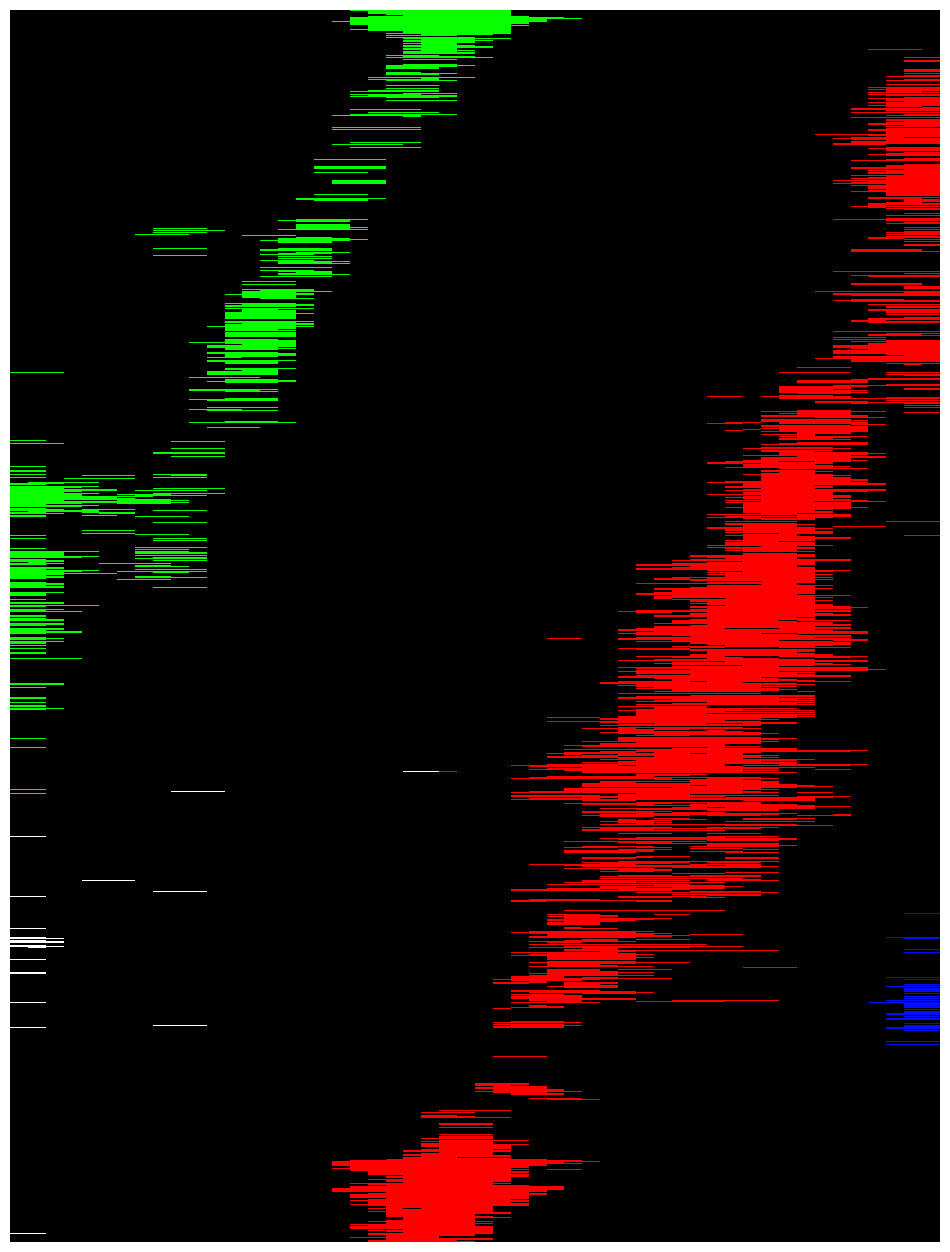

In [365]:
colors = generate_colors(no_of_clusters) 
img_clusters = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

print("Number of clusters: ", no_of_clusters)
for cluster_id in range(no_of_clusters):
    idx = X[clustering.labels_ == cluster_id, :]
    # print(idx)
    # print(f"Cluster{cluster_id}: {np.sum(idx)} members")
    img_clusters[idx.T[0], idx.T[1],:] = colors[cluster_id]

plot_numpy(img_clusters)

R2 of cluster 0: 0.8905713270766812
Detected velocity: 27.01 m/s (97.24 km/h)

R2 of cluster 1: 0.8455198996656536
Detected velocity: 18.81 m/s (67.72 km/h)

R2 of cluster 2: 0.00069065555936898
Discarded cluster 2 with R2=0.00069065555936898


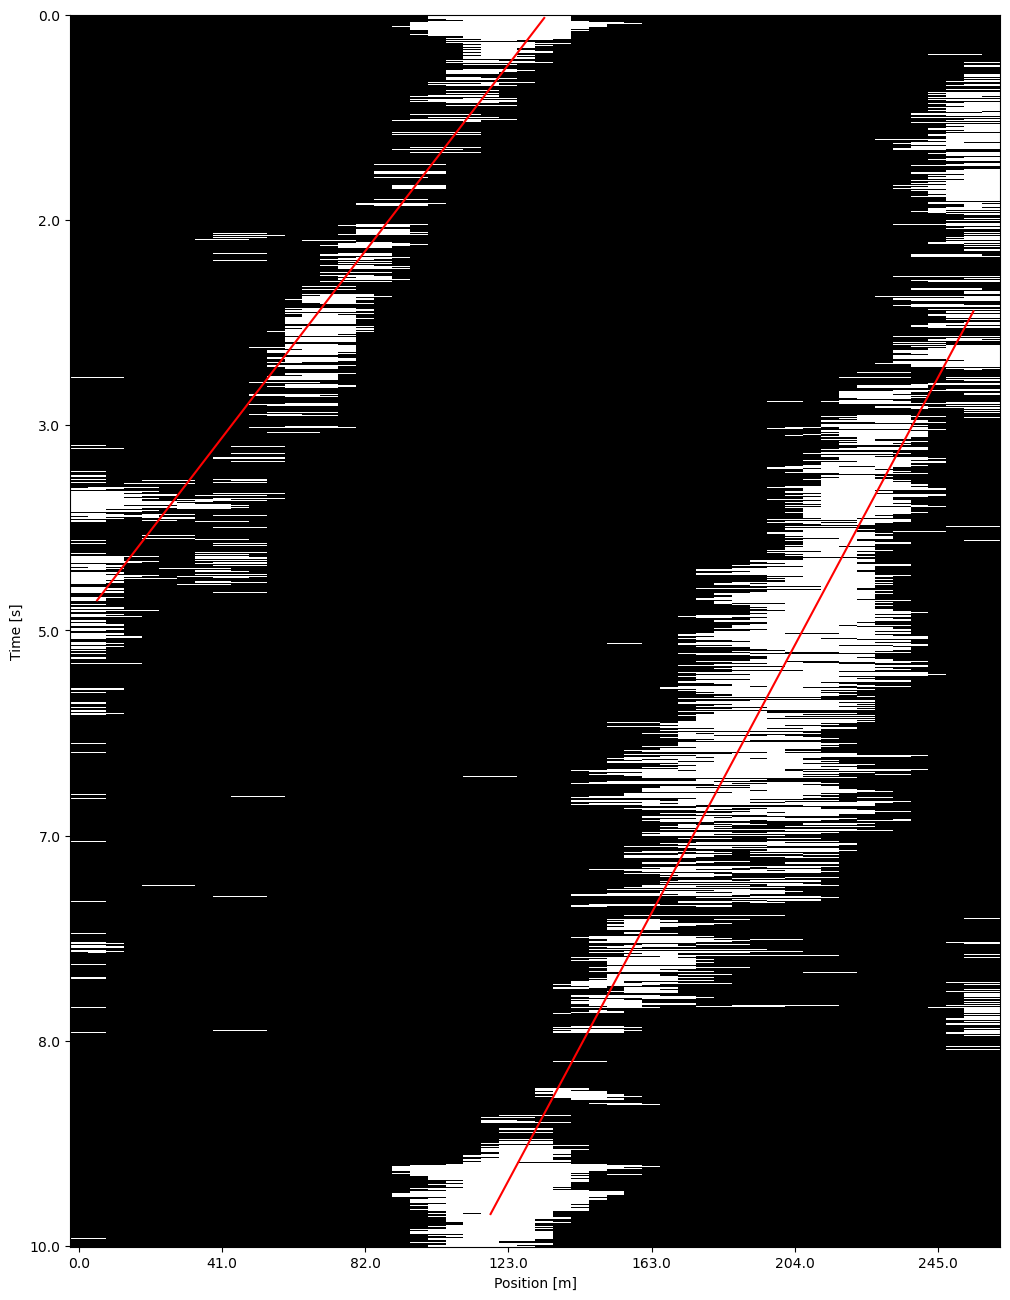

In [366]:
from sklearn.linear_model import LinearRegression

lines = []

for cluster_id in range(no_of_clusters):
    idx = X[clustering.labels_ == cluster_id, :]
    x_coords = idx[:, 1].reshape(-1,1)
    y_coords = idx[:, 0]
    
    model = LinearRegression()
    model.fit(x_coords, y_coords)

    slope = model.coef_[0]
    intercept = model.intercept_

    x_start = np.min(x_coords)
    x_end = np.max(x_coords)
    
    # y_start = model.predict([[x_start]])
    # y_end = model.predict([[x_end]])
    r2 = model.score(x_coords, y_coords)
    print(f"R2 of cluster {cluster_id}: {r2}")

    #DISCARDING R2 < 0.8
    if r2 < 0.8:
        print(f"Discarded cluster {cluster_id} with R2={r2}")
        continue
    velocity = velocity_from_slope(slope)
    print(f"Detected velocity: {velocity} m/s ({ mps_to_kmph(velocity) } km/h)")
    print()
    lines.append((slope,intercept, x_start, x_end))
    

plot_numpy_with_lines(img, lines)



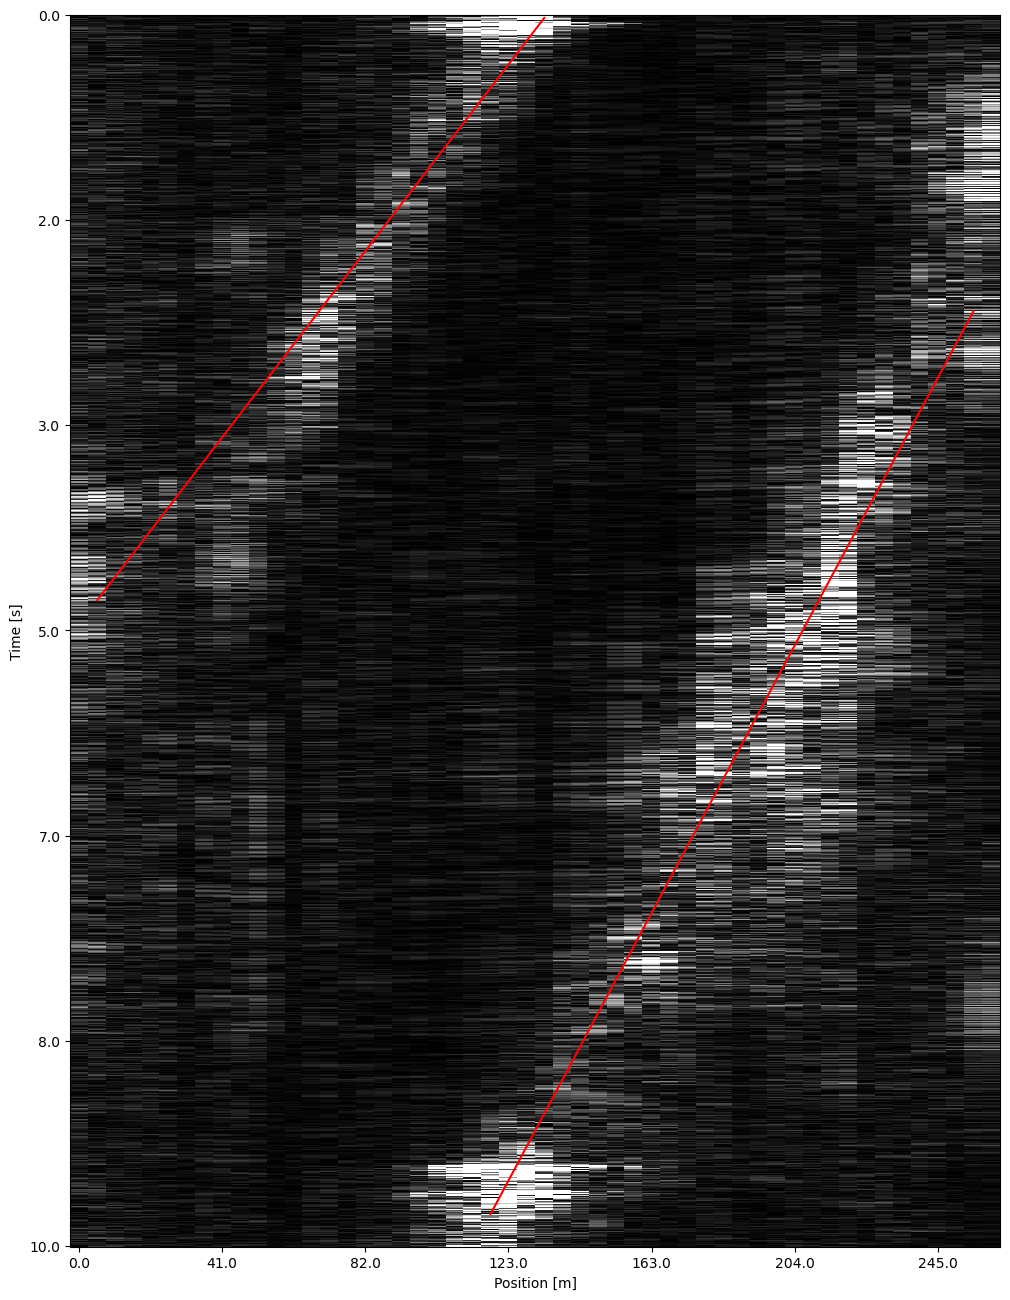

In [367]:
plot_numpy_with_lines(original_img, lines)

In [368]:
from regression_pipeline import detect_velocities

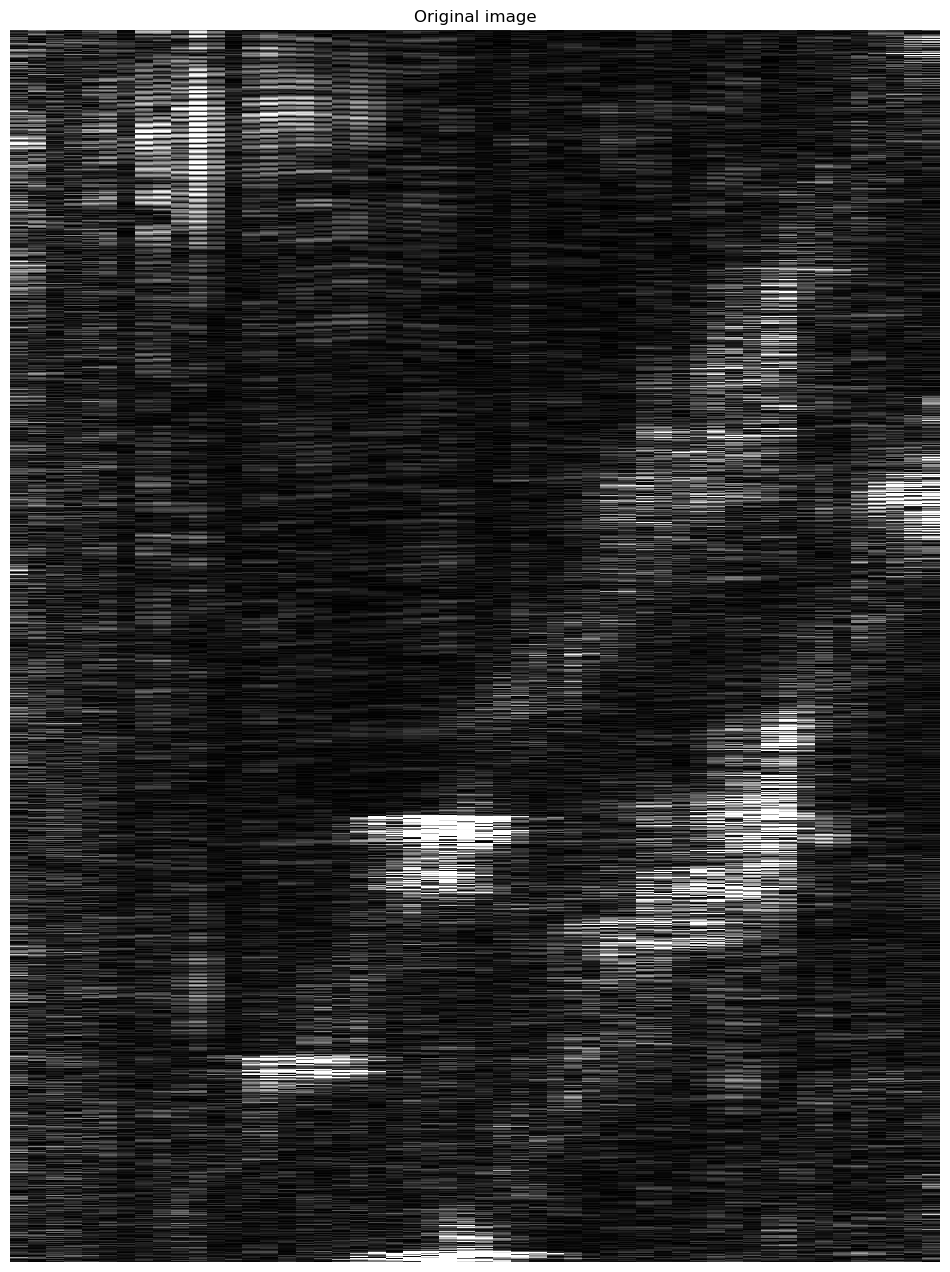

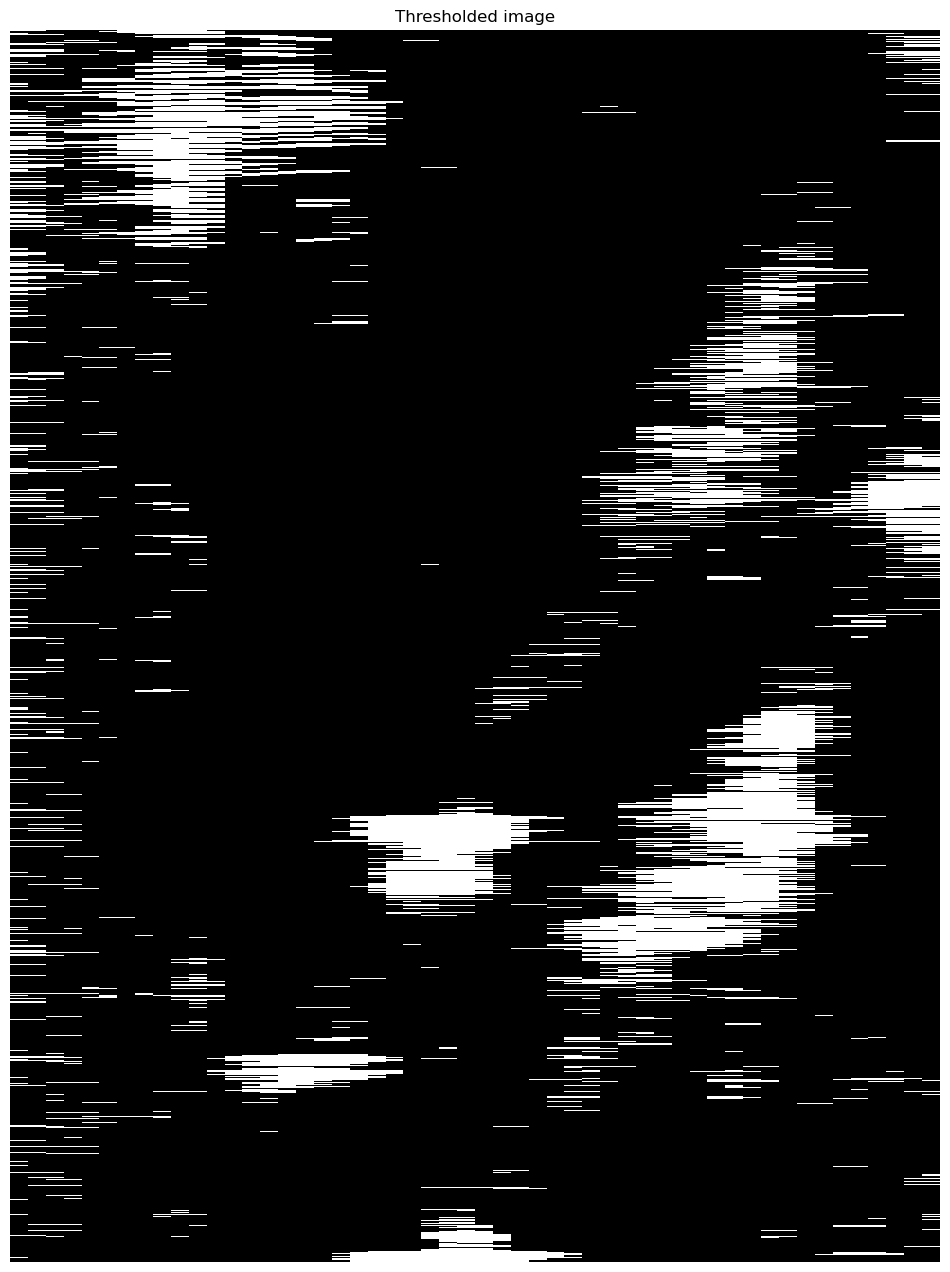

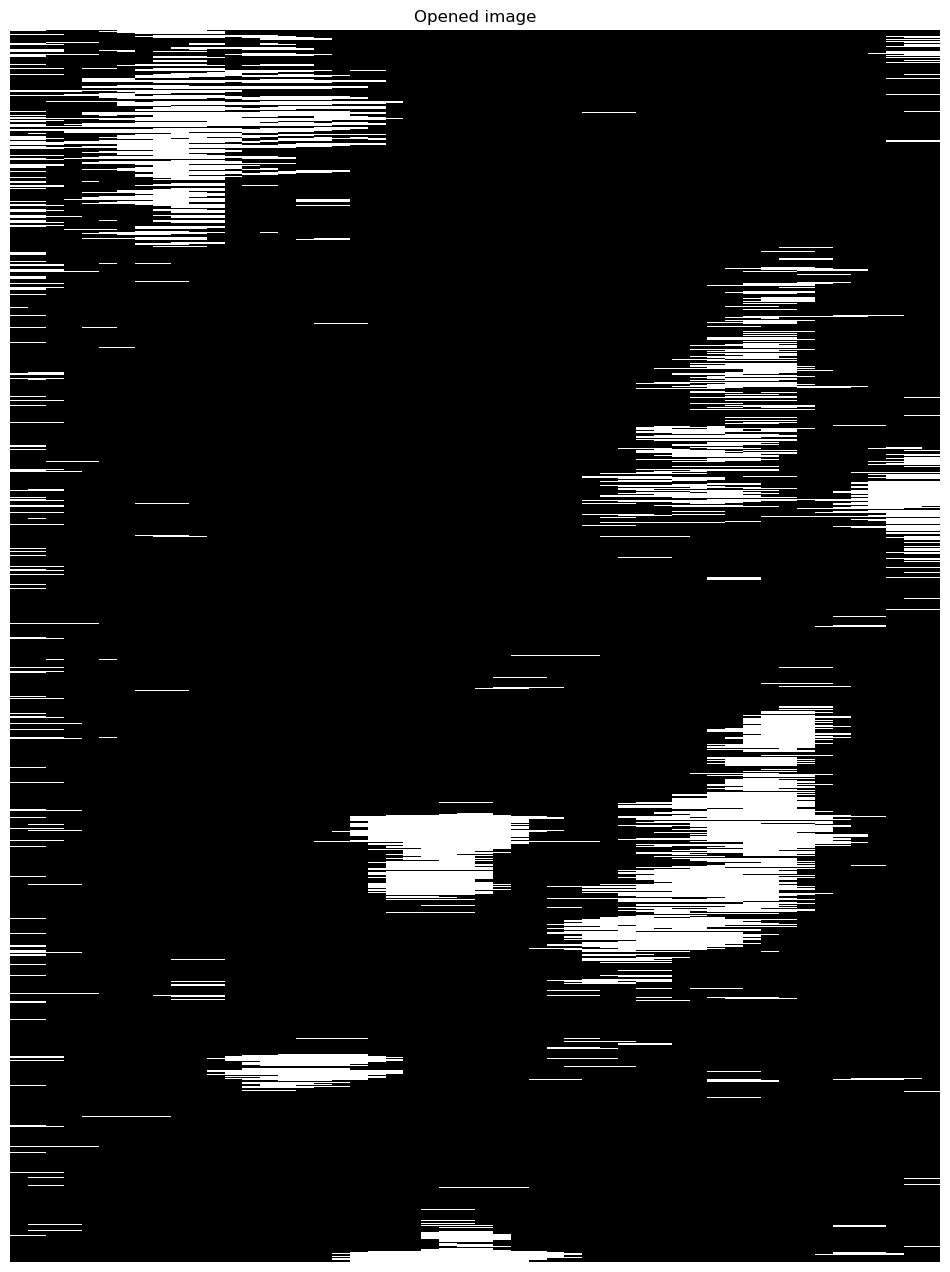

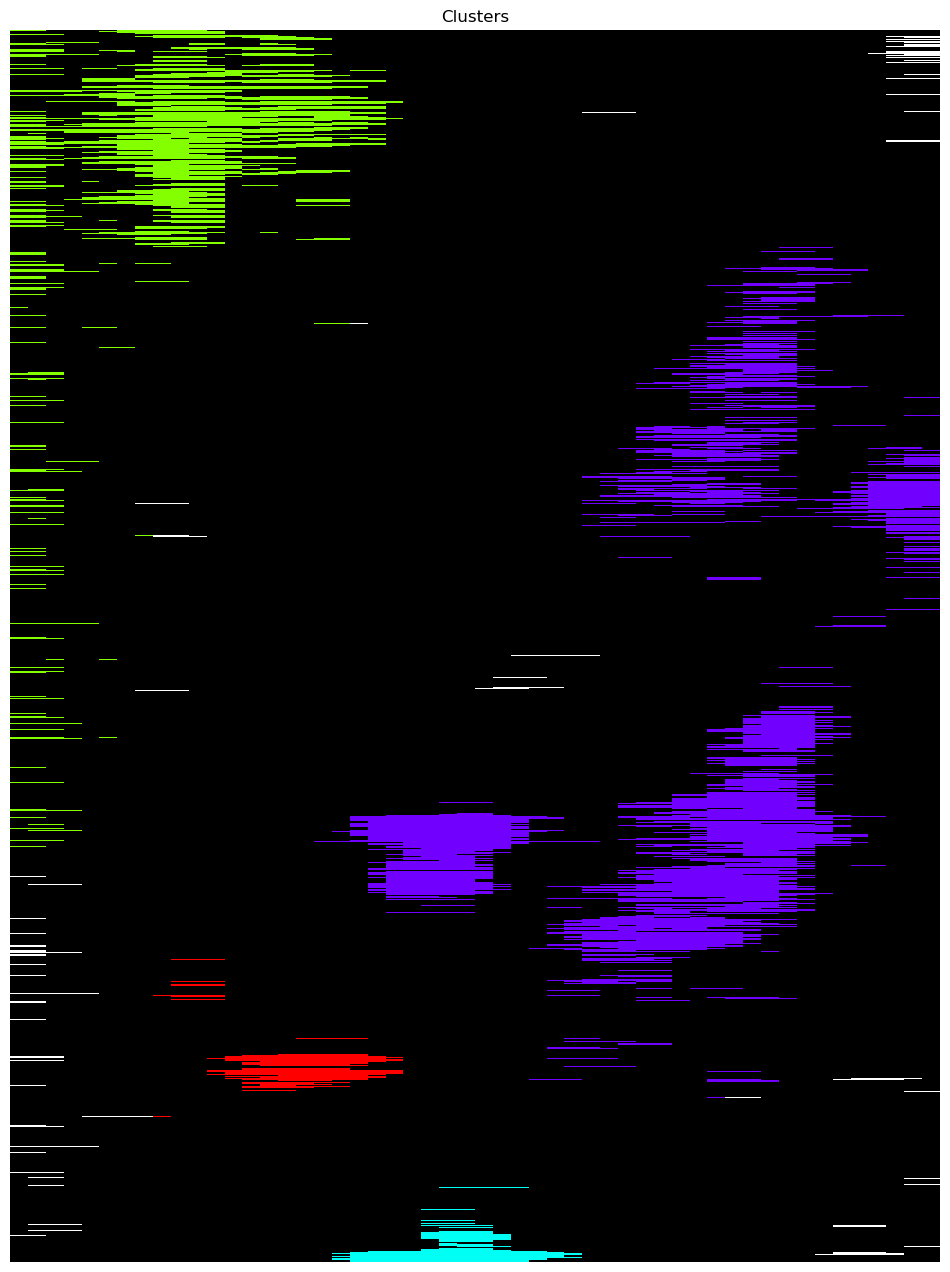

Discarded cluster 0 with R2=0.23012827515232726 (<0.6)
Discarded cluster 1 with R2=0.20741702943527784 (<0.6)
Discarded cluster 2 with R2=0.2772936584462041 (<0.6)
Discarded cluster 3 with R2=0.017400256279623272 (<0.6)


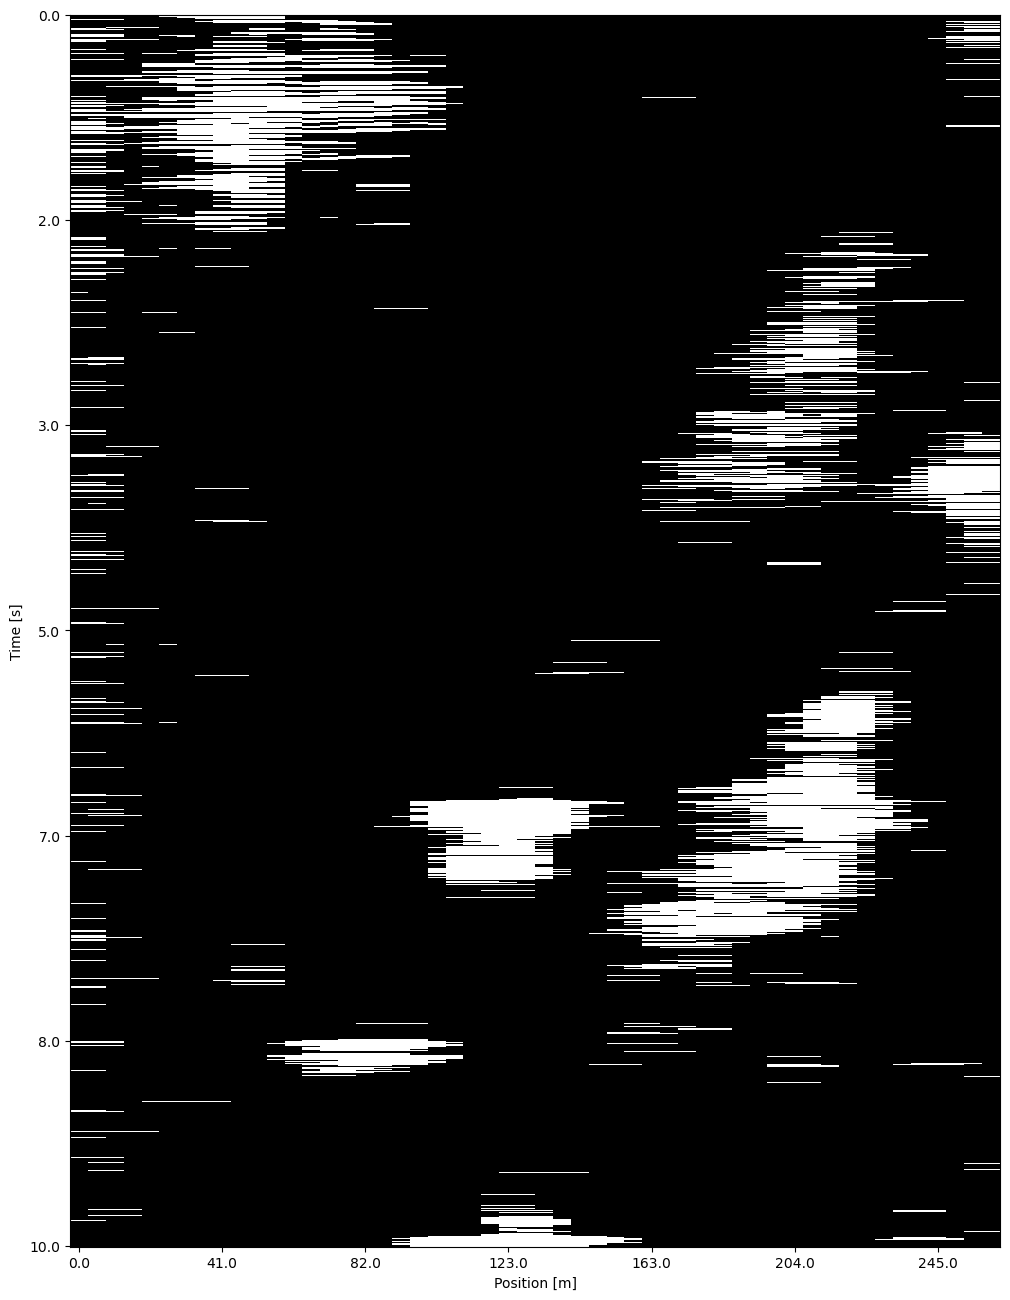

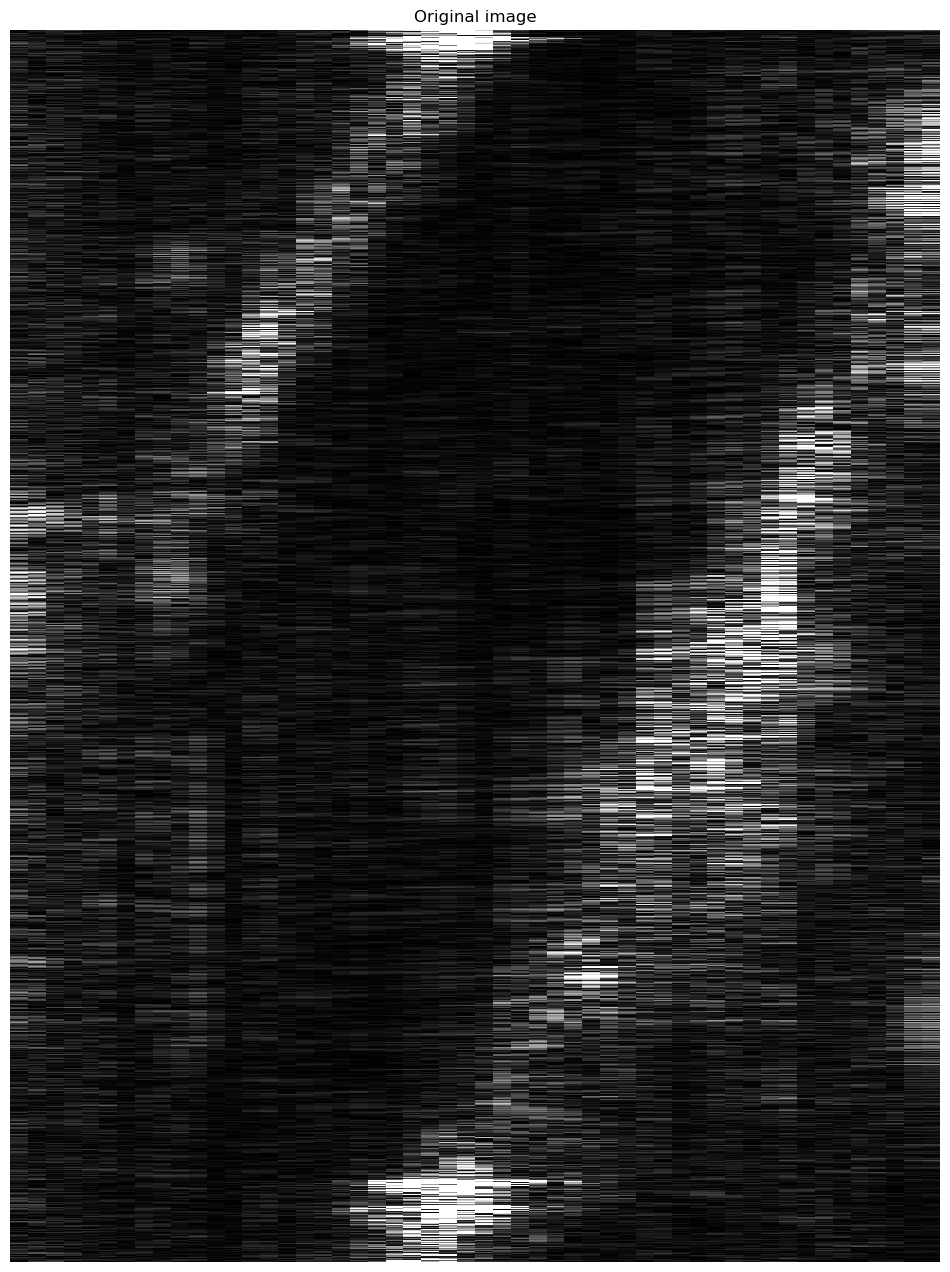

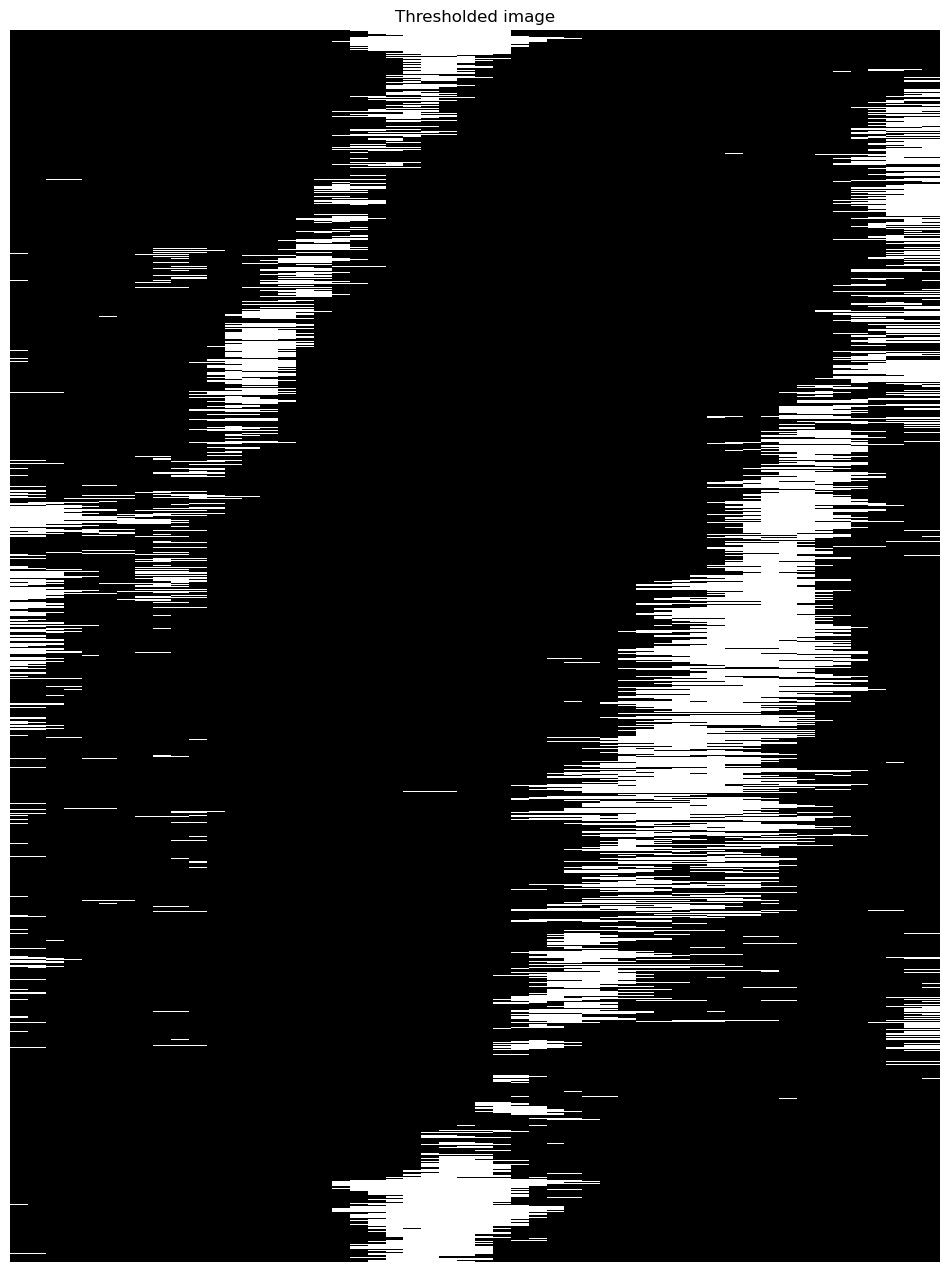

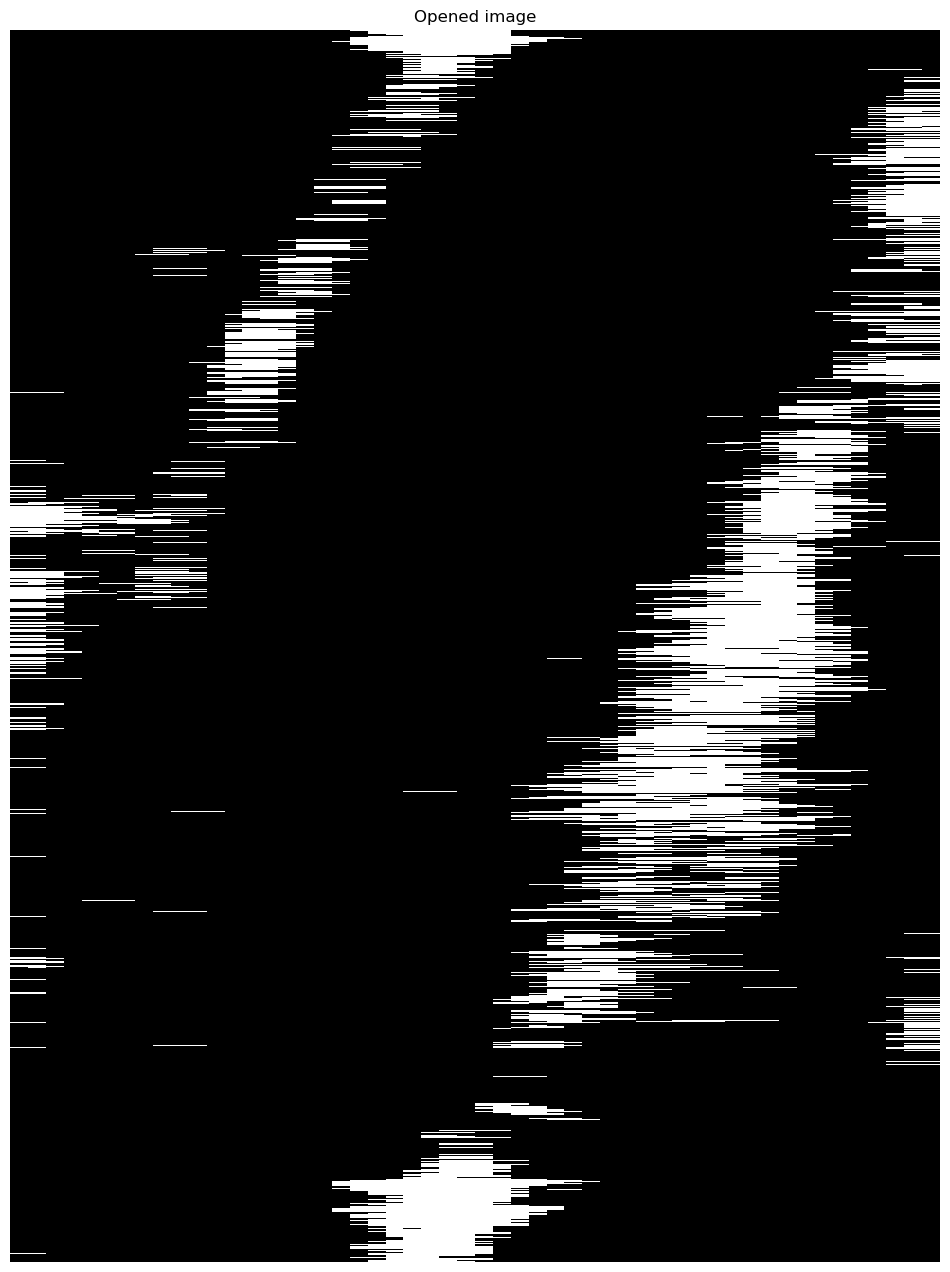

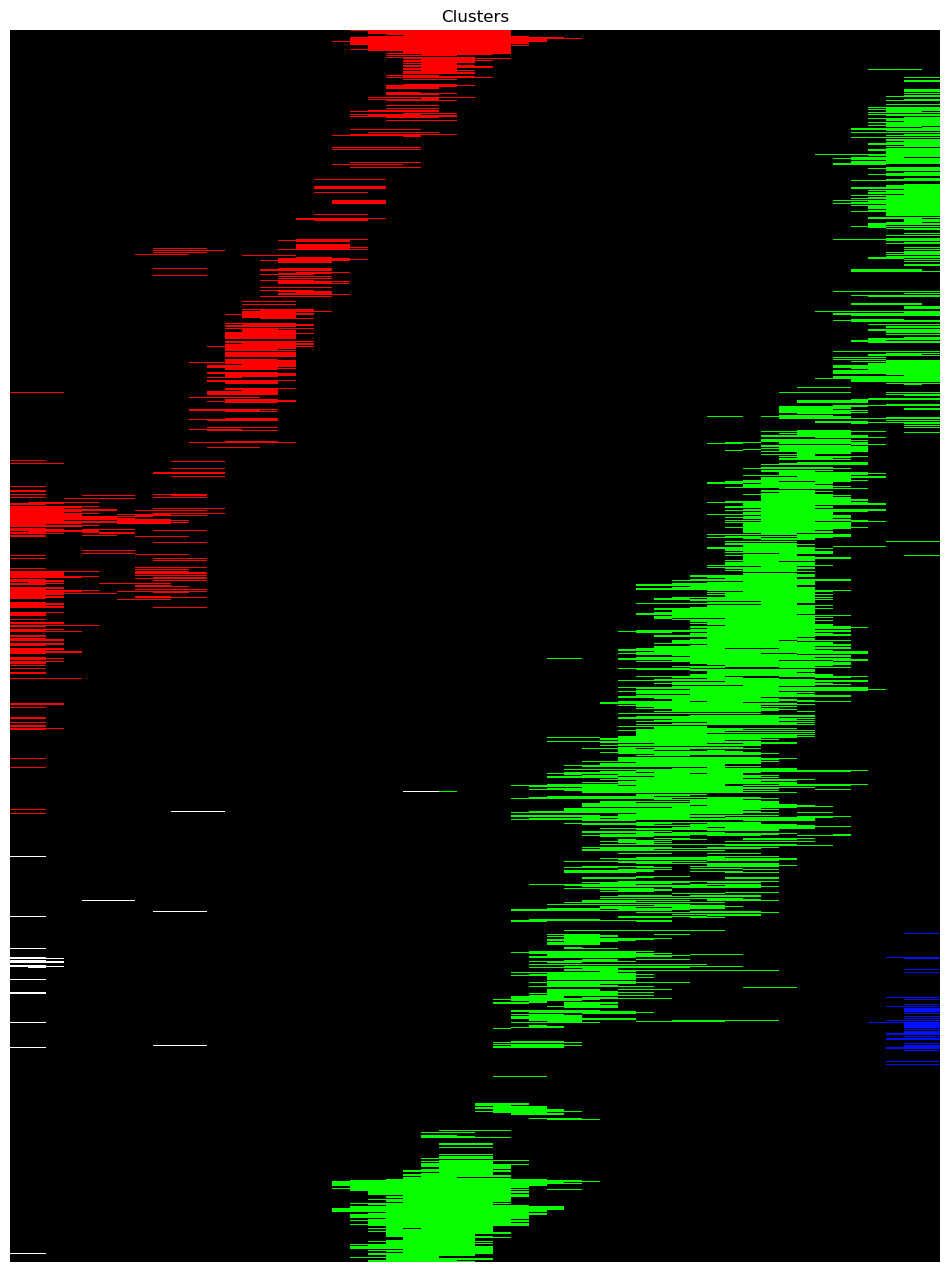

Detected velocity: 27.01 m/s (97.24 km/h)

Detected velocity: 18.81 m/s (67.72 km/h)

Discarded cluster 2 with R2=0.00069065555936898 (<0.6)


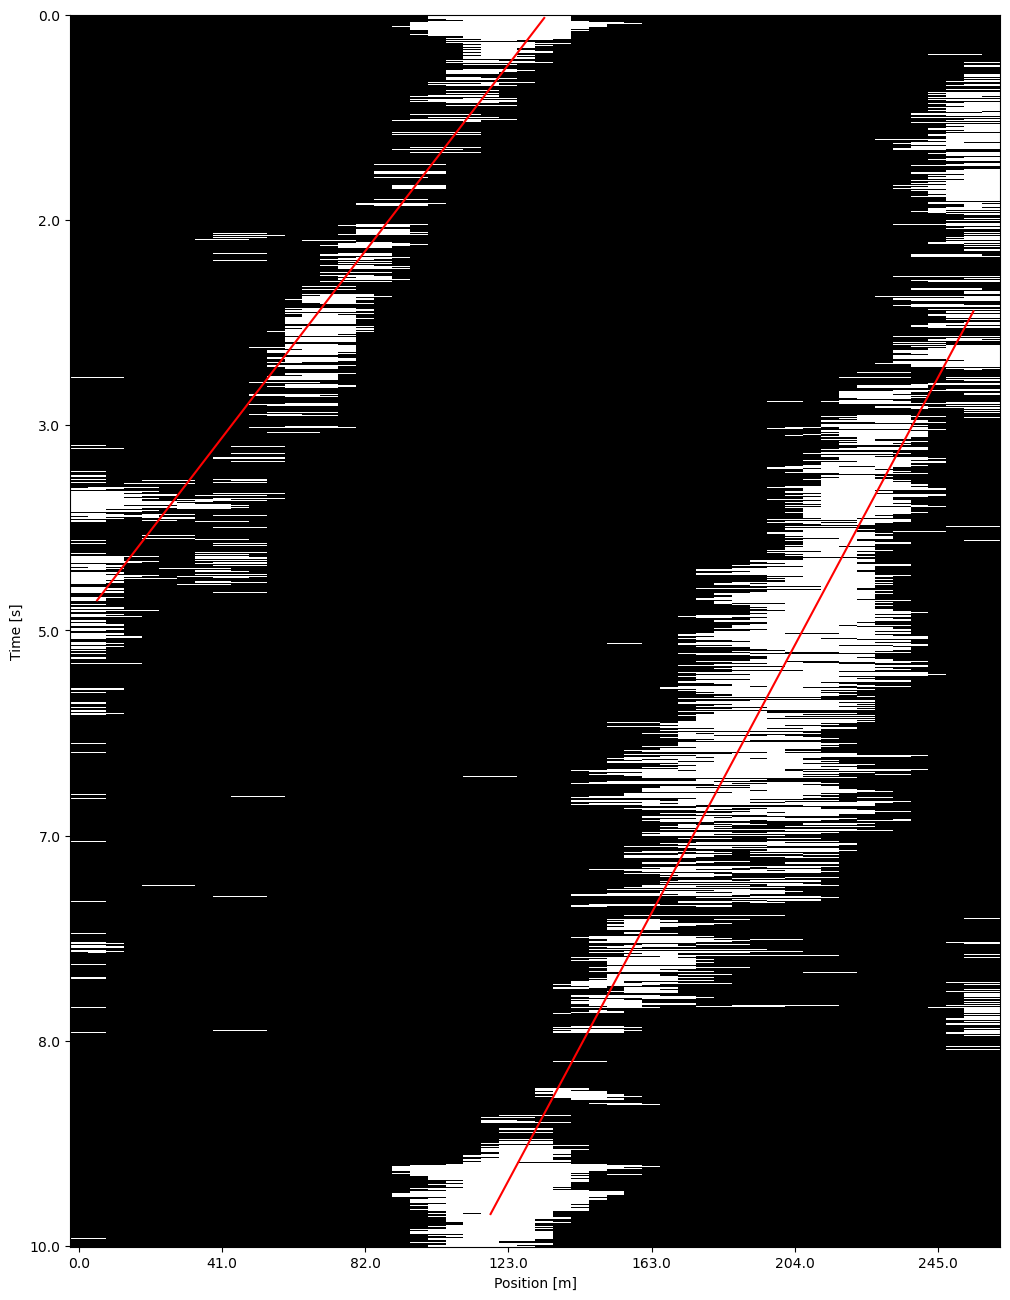

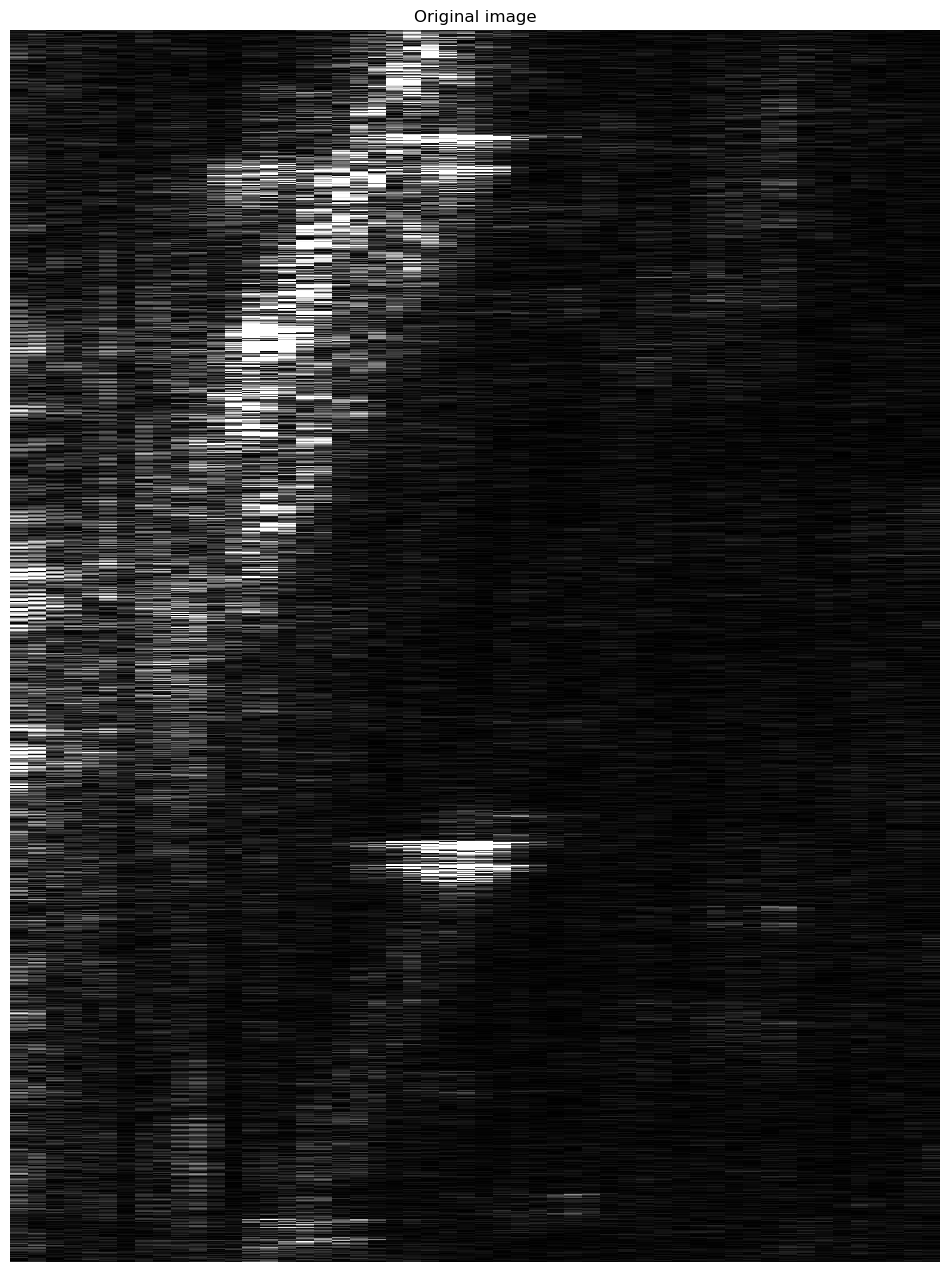

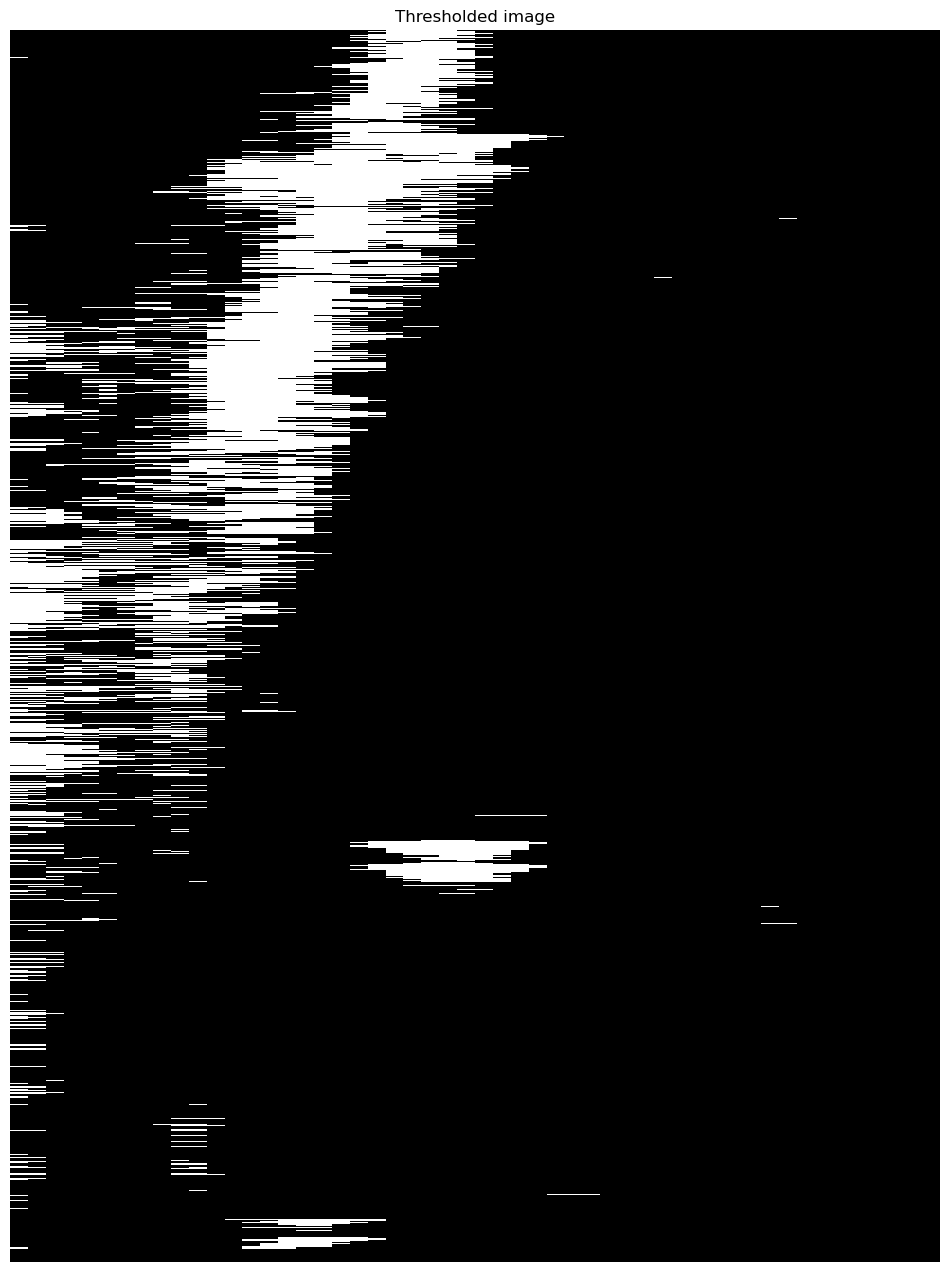

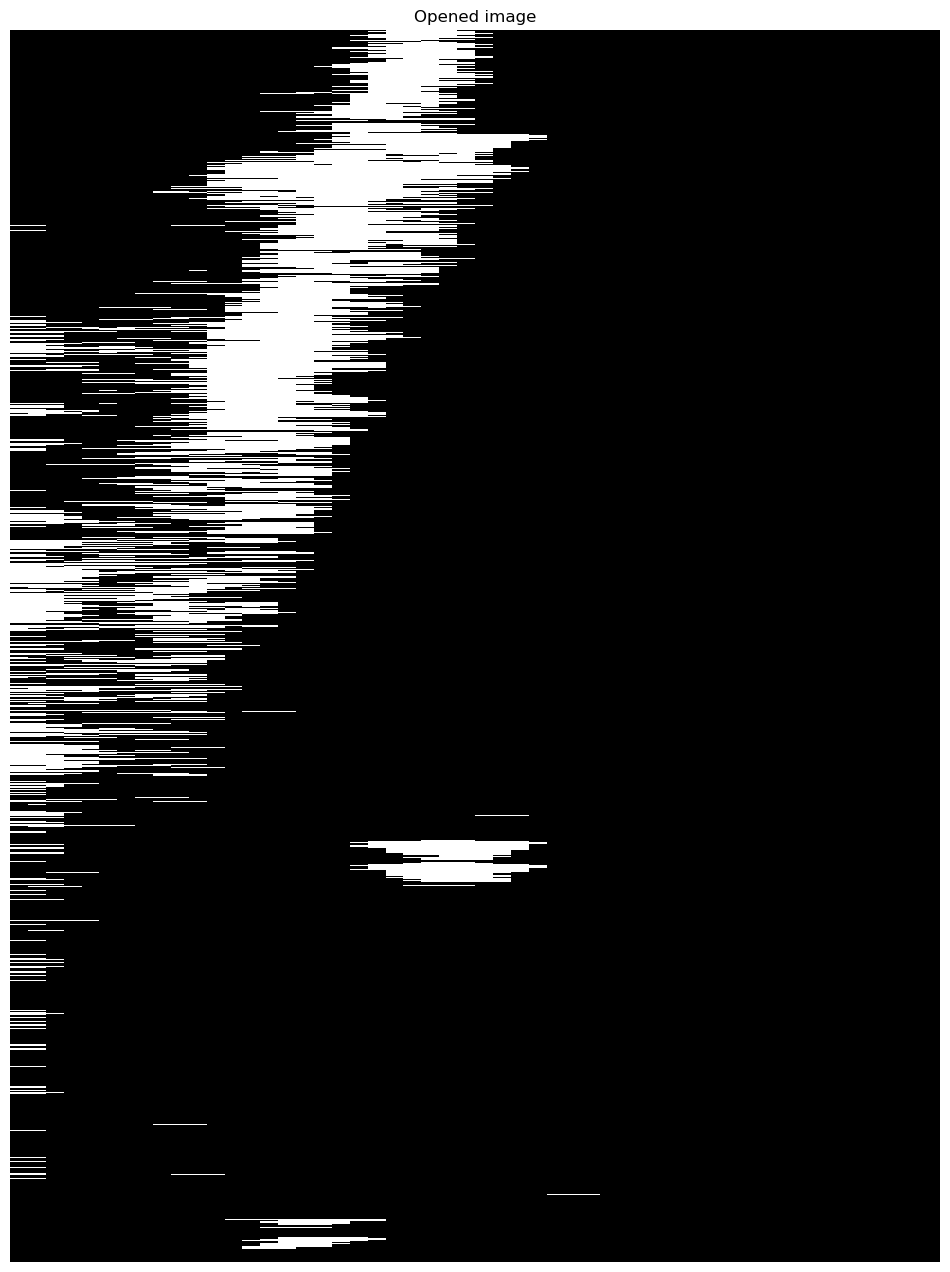

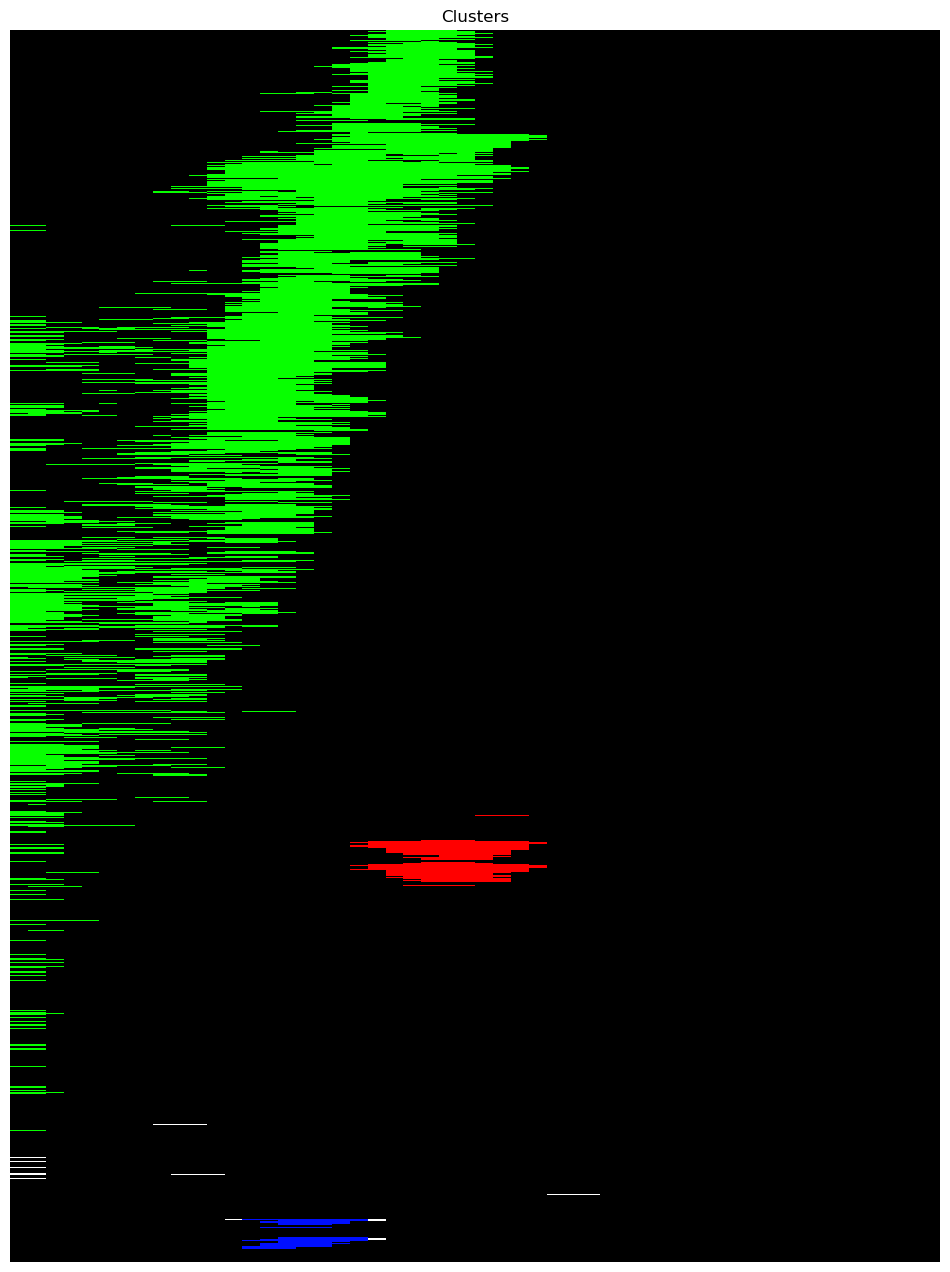

Detected velocity: 26.41 m/s (95.08 km/h)

Discarded cluster 1 with R2=0.0013239823996237243 (<0.6)
Discarded cluster 2 with R2=0.02908448918272266 (<0.6)


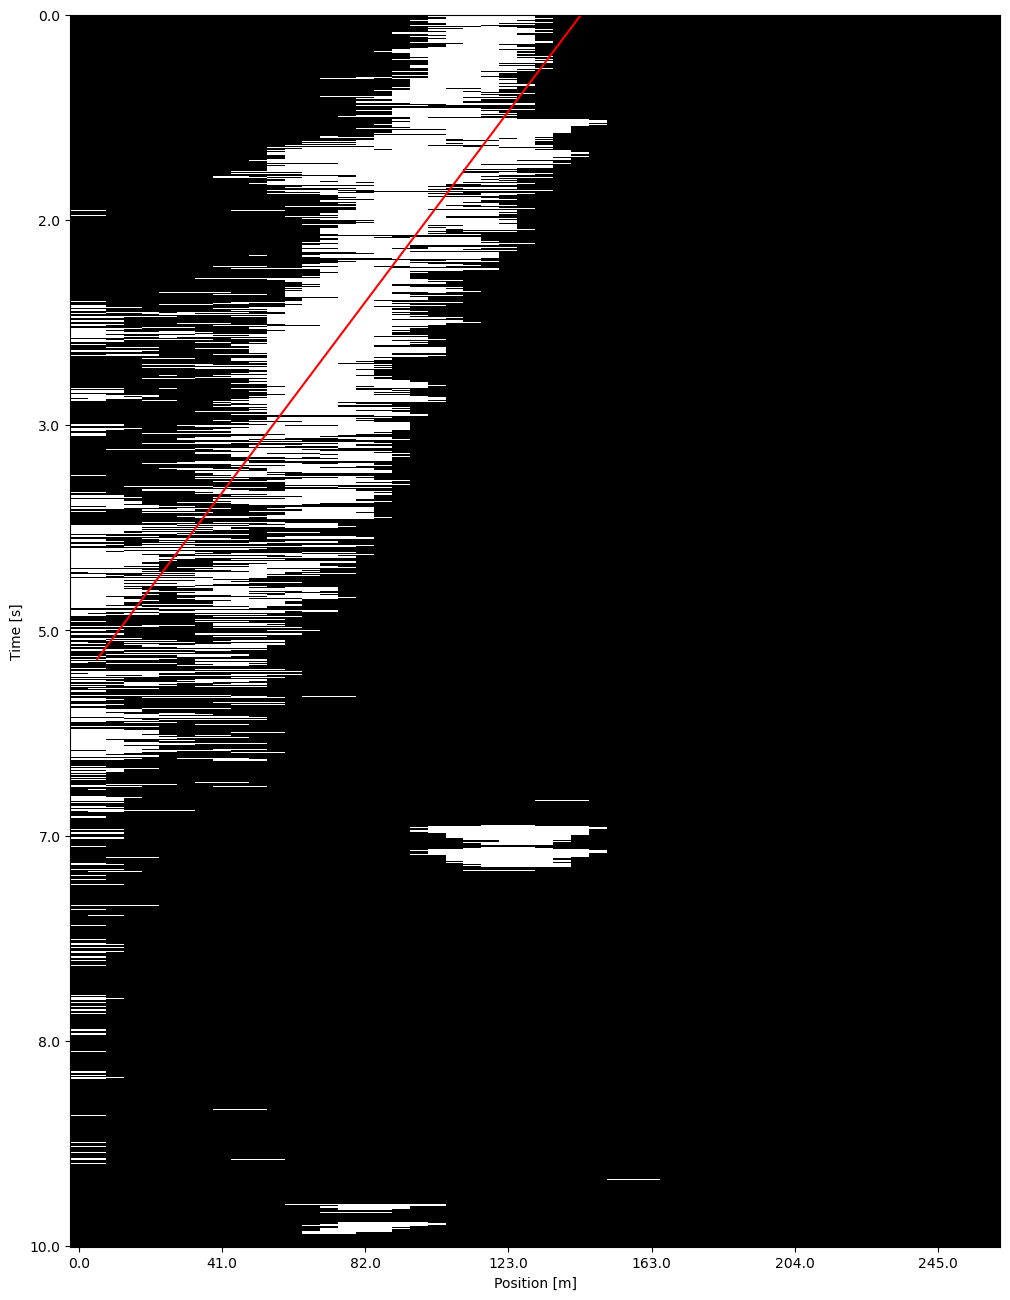

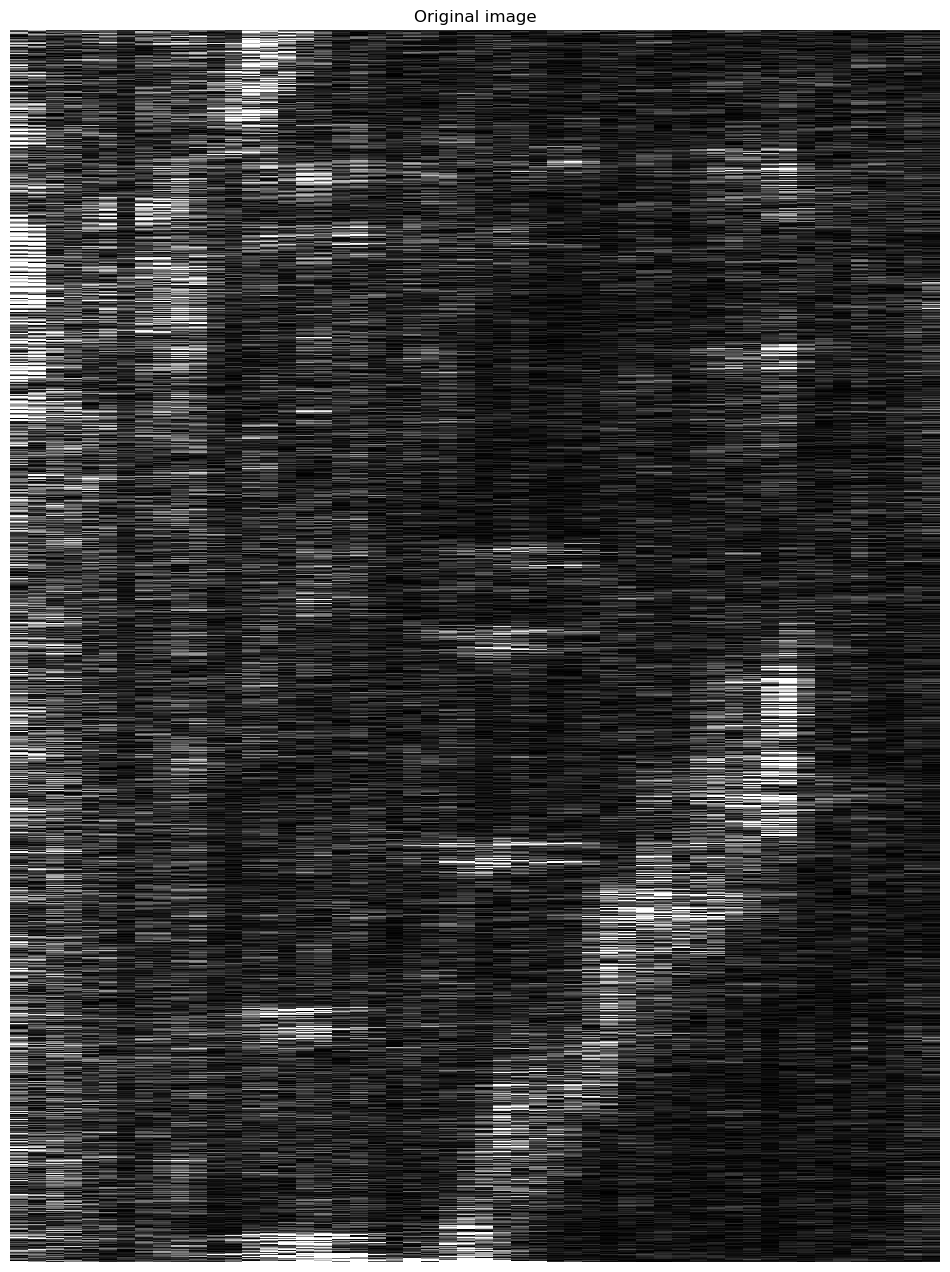

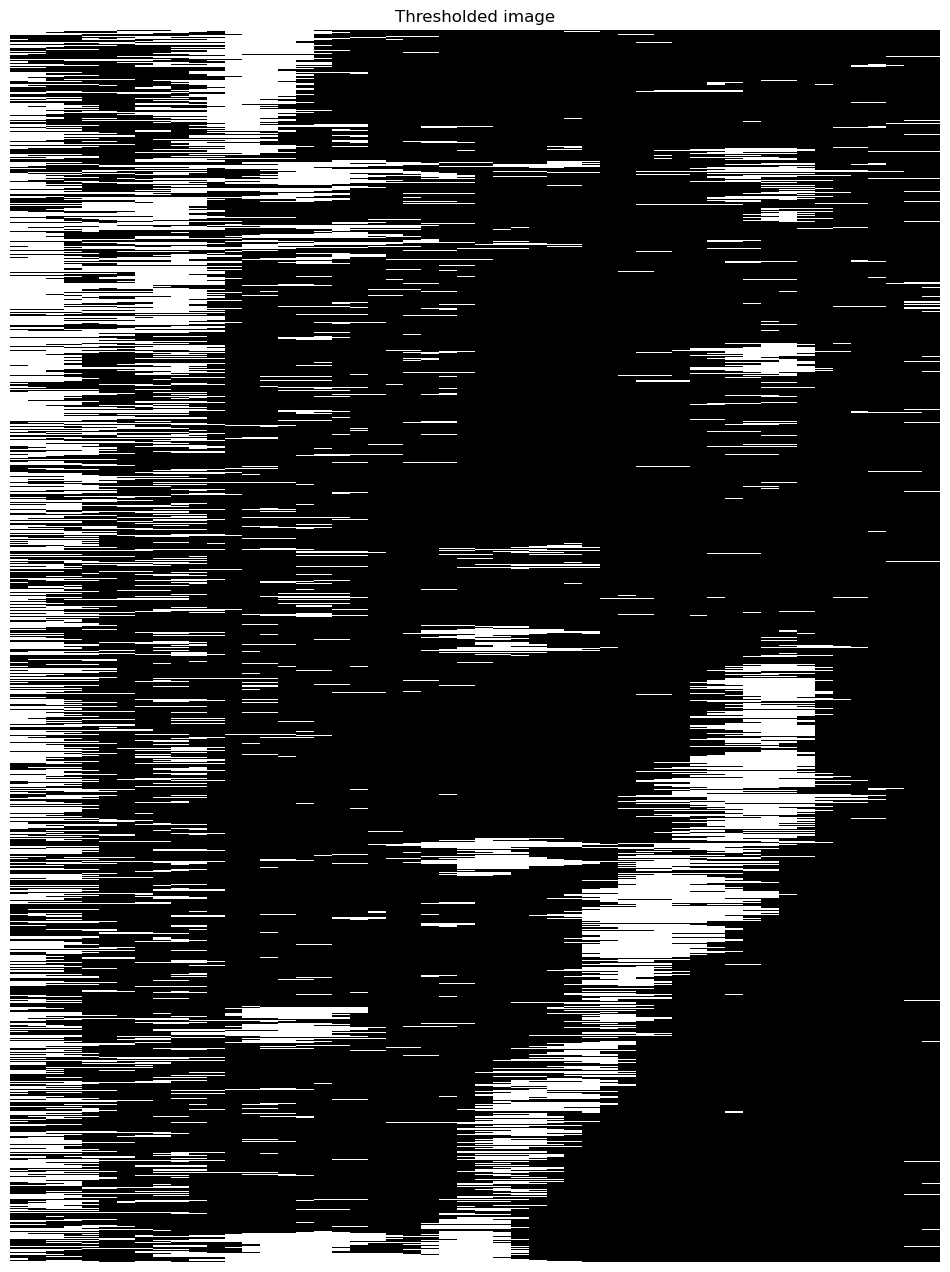

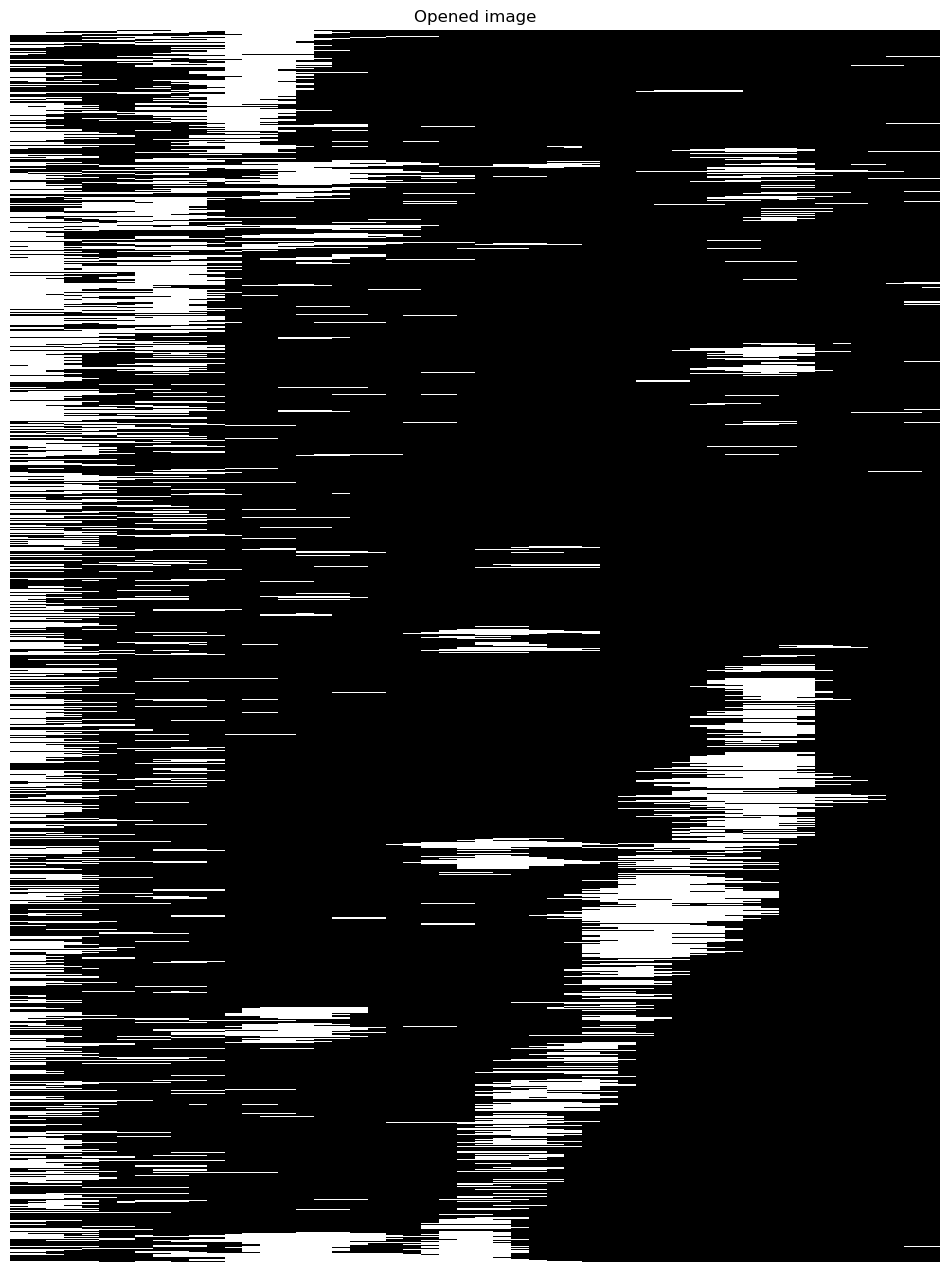

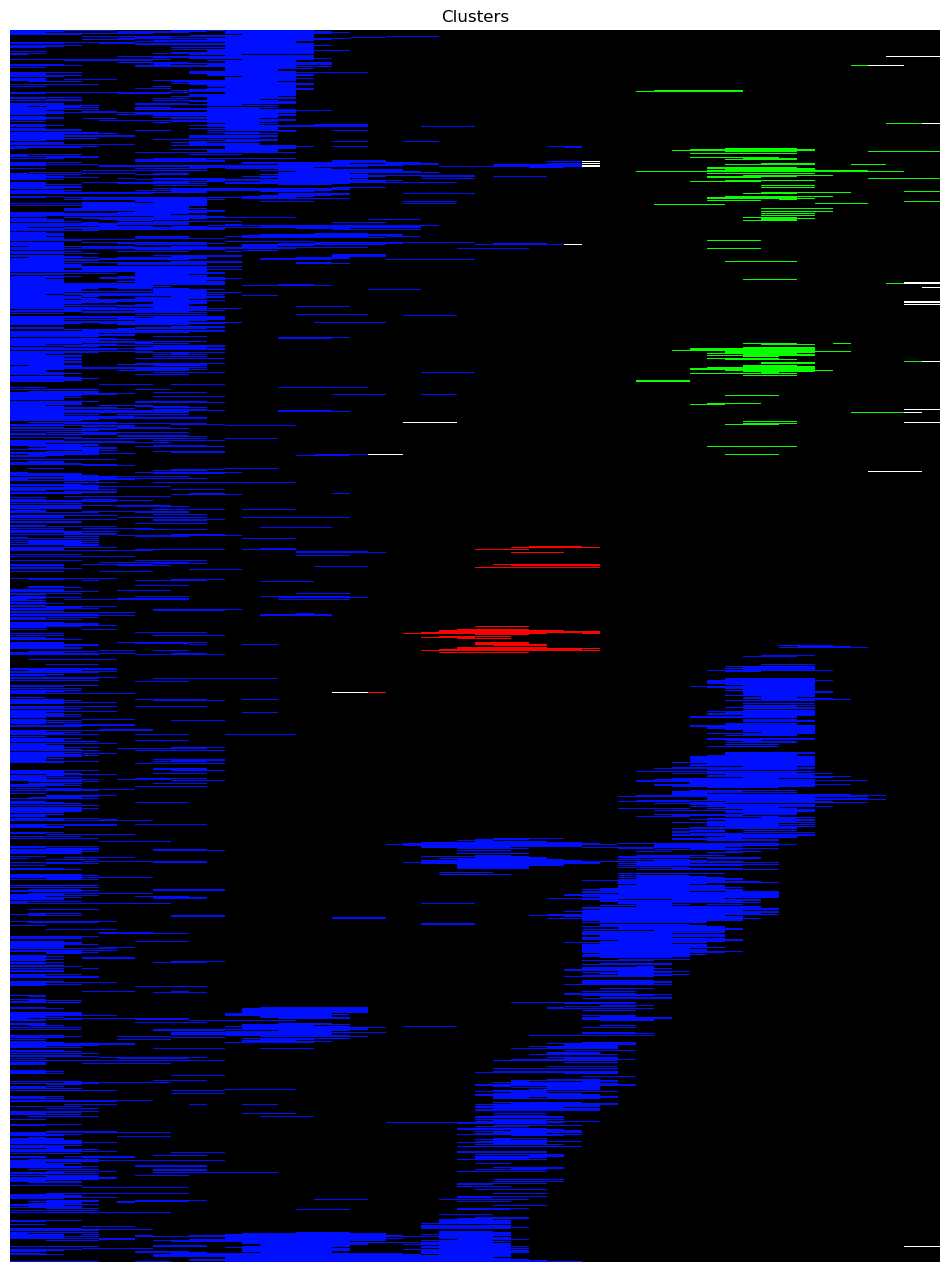

Discarded cluster 0 with R2=0.11418404805178584 (<0.6)
Discarded cluster 1 with R2=0.012350721624707295 (<0.6)
Discarded cluster 2 with R2=0.09793819323376207 (<0.6)


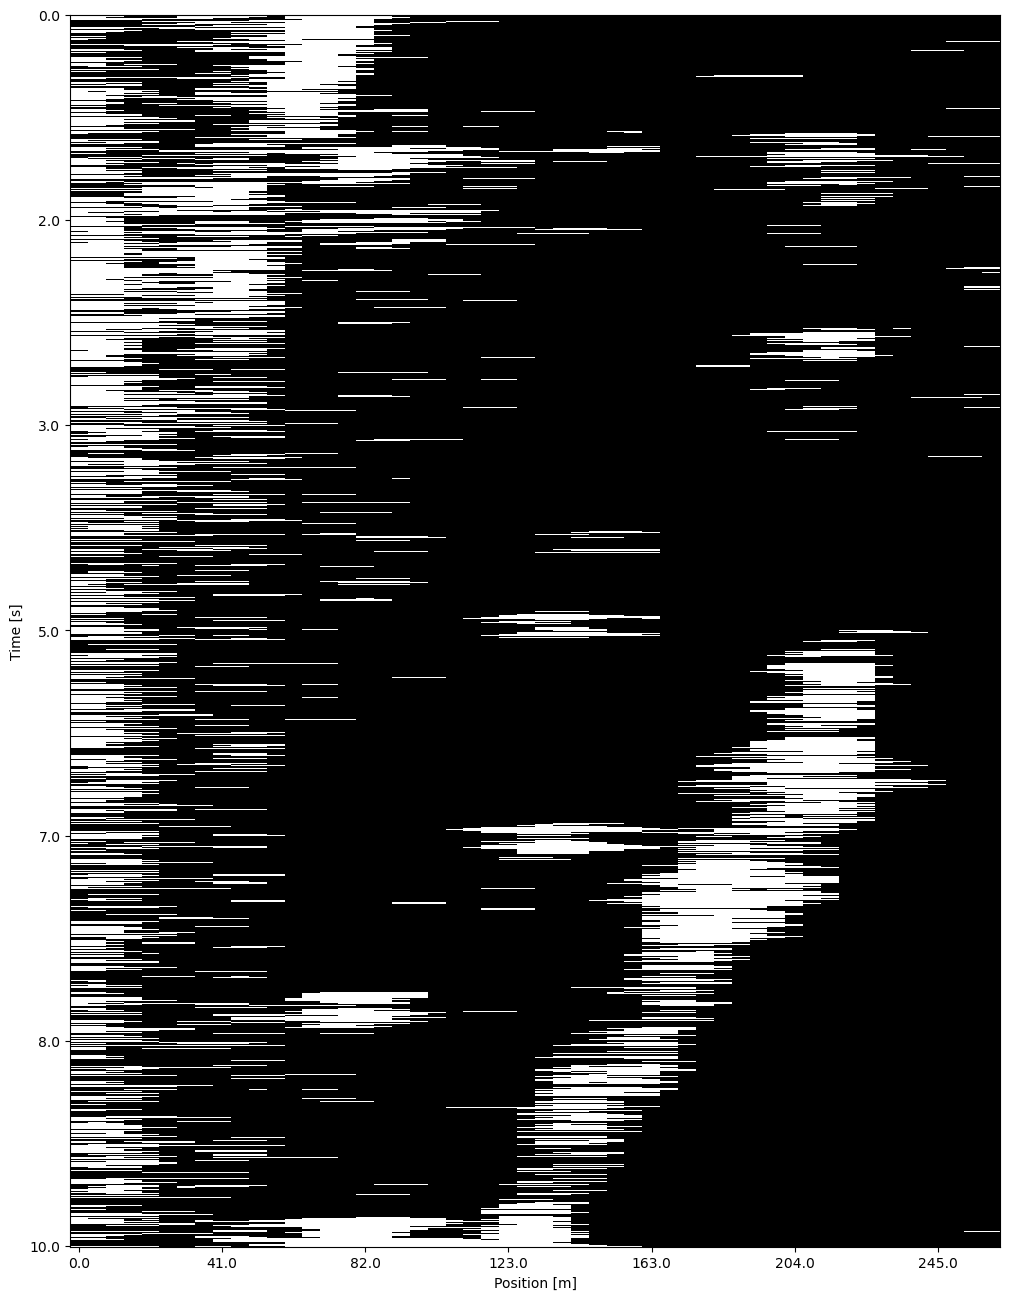

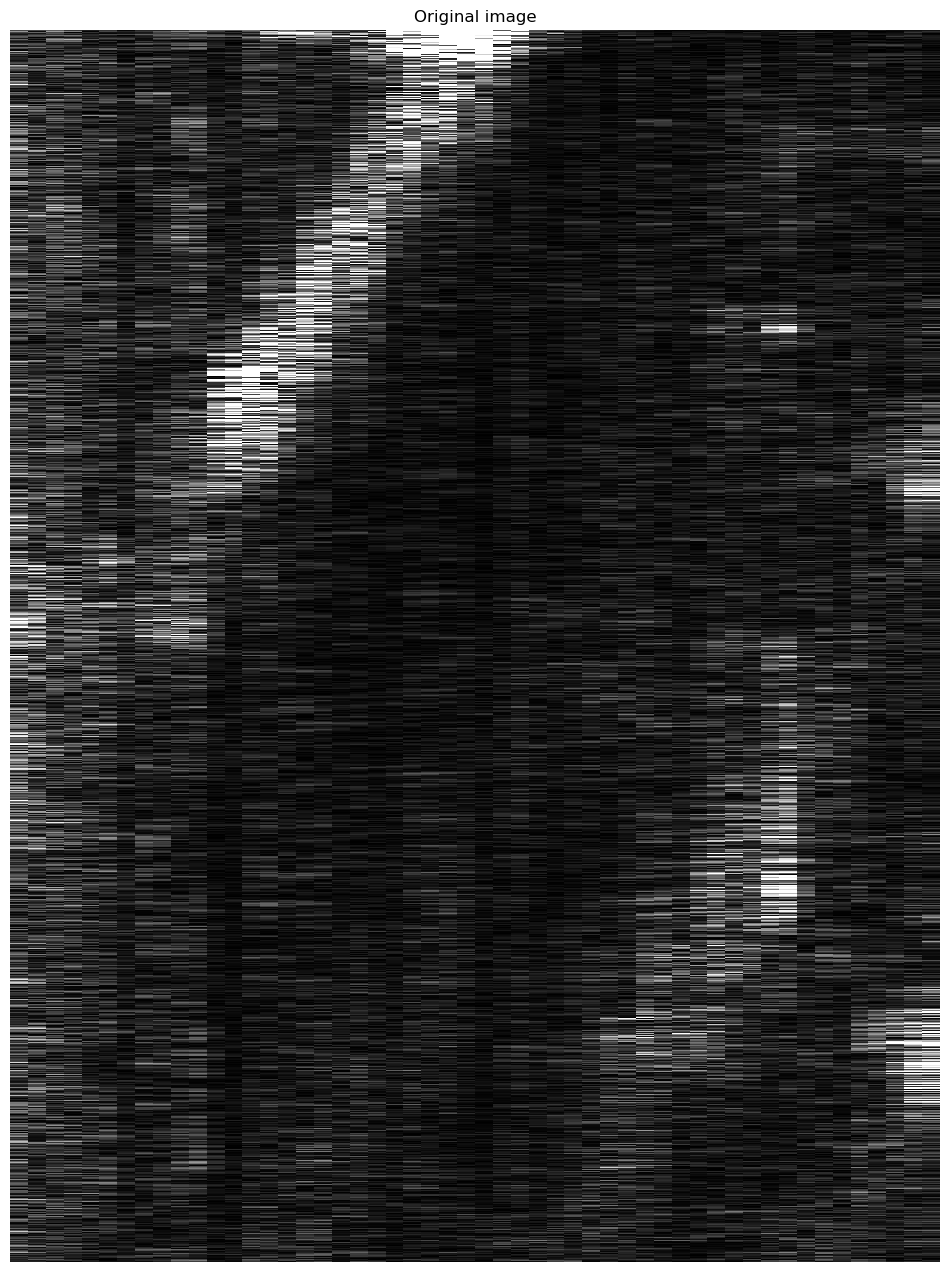

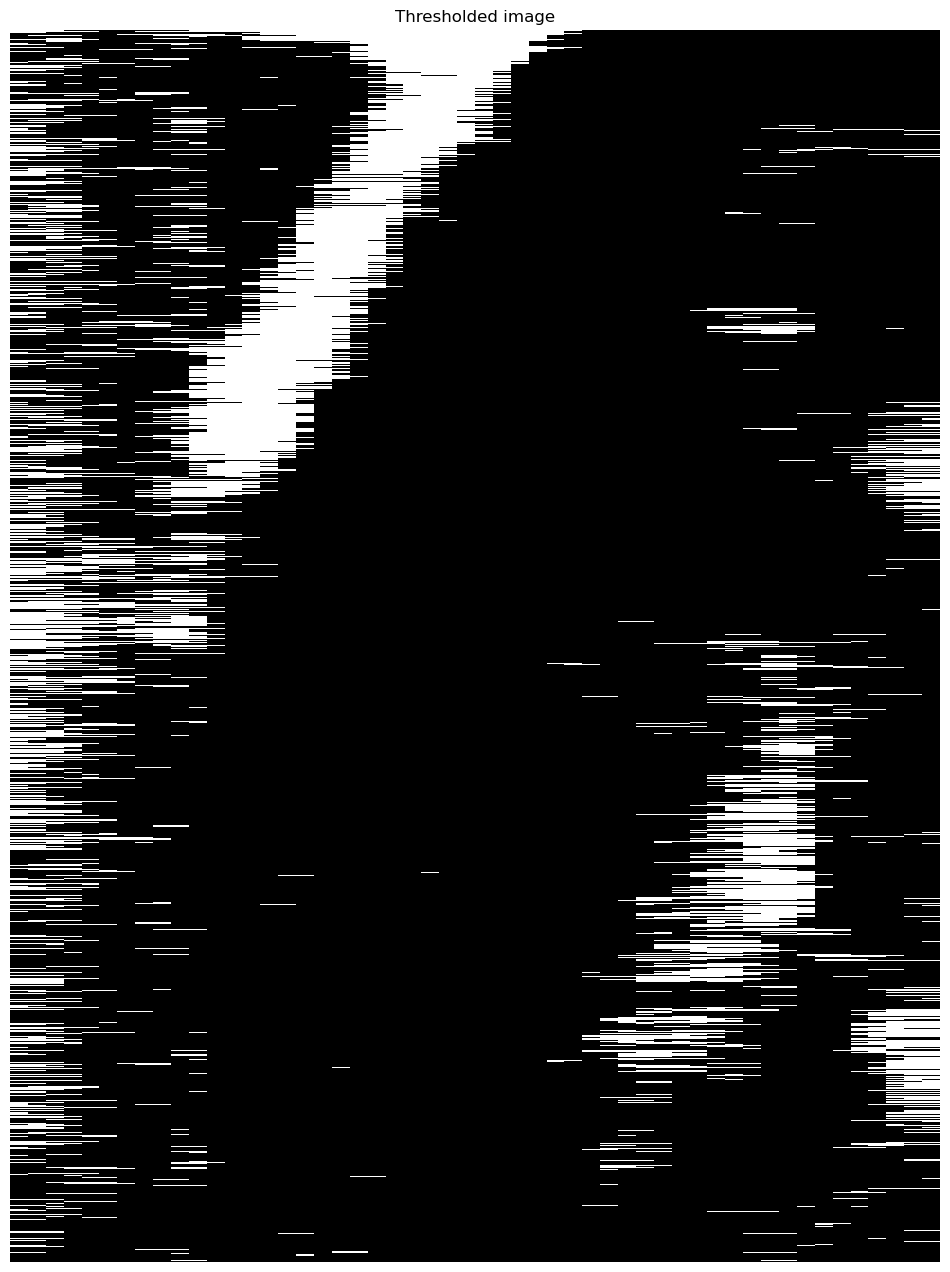

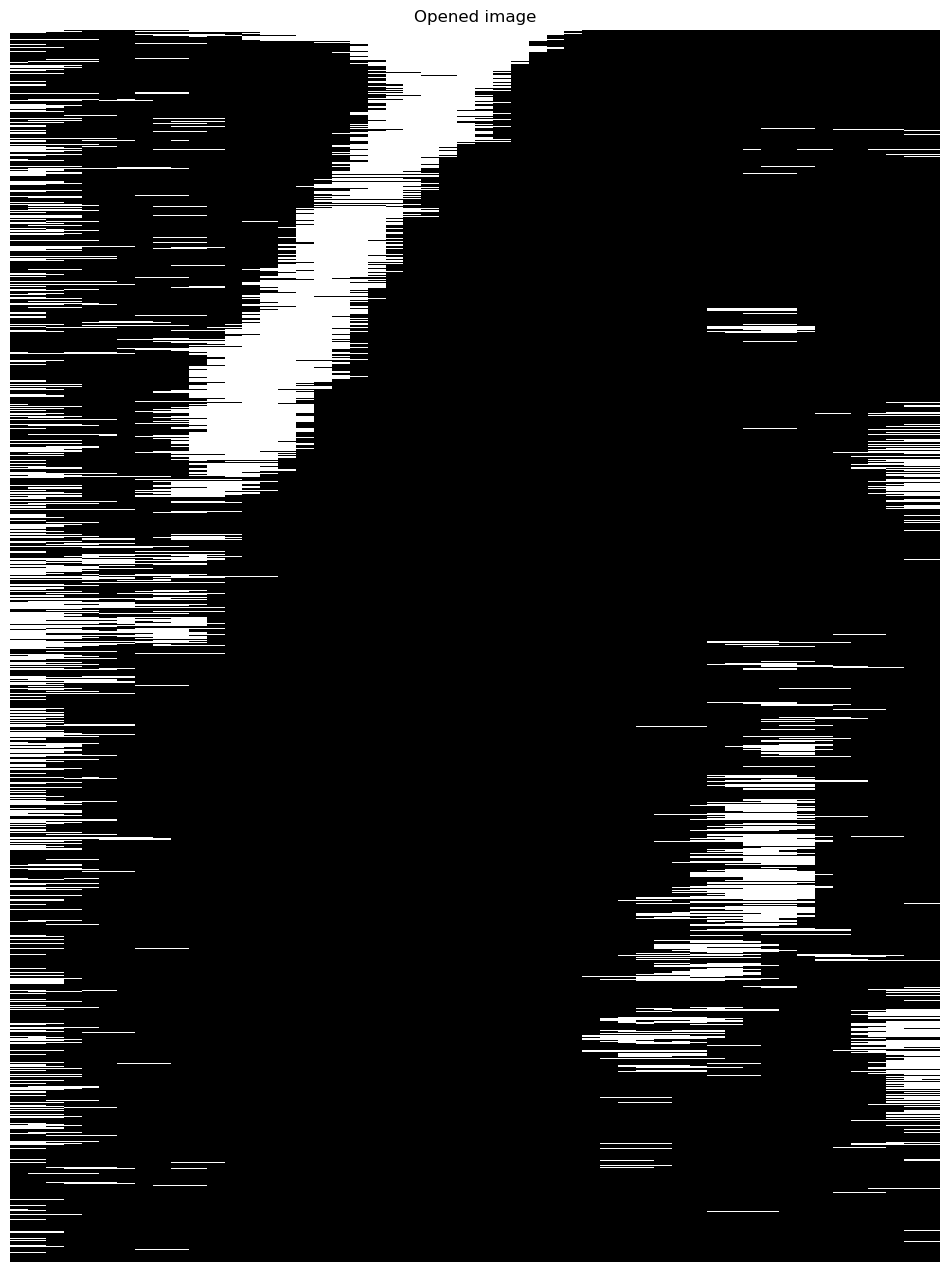

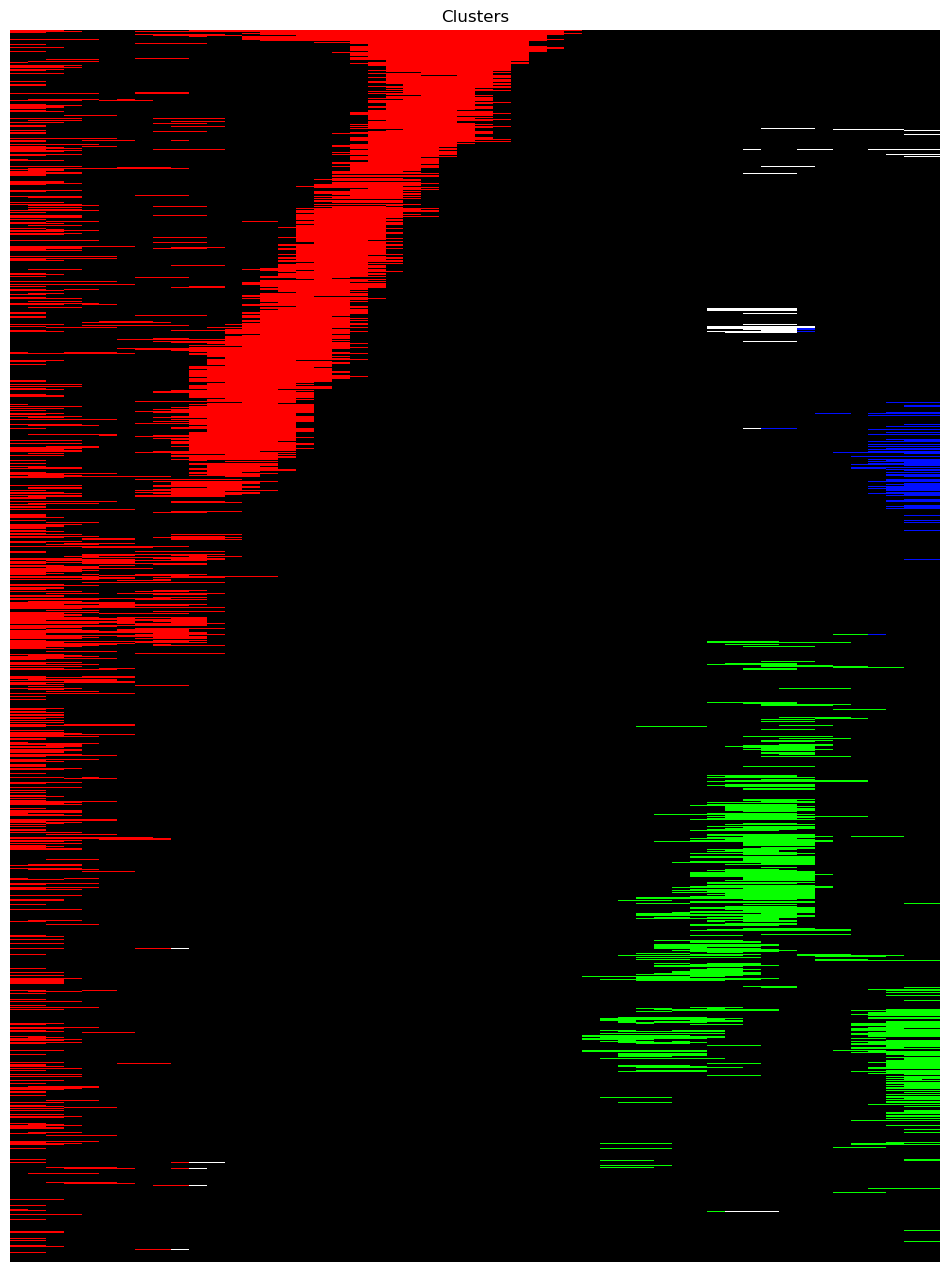

Discarded cluster 0 with R2=0.4820572064654526 (<0.6)
Discarded cluster 1 with R2=0.06653788567050956 (<0.6)
Discarded cluster 2 with R2=0.03311998869768862 (<0.6)


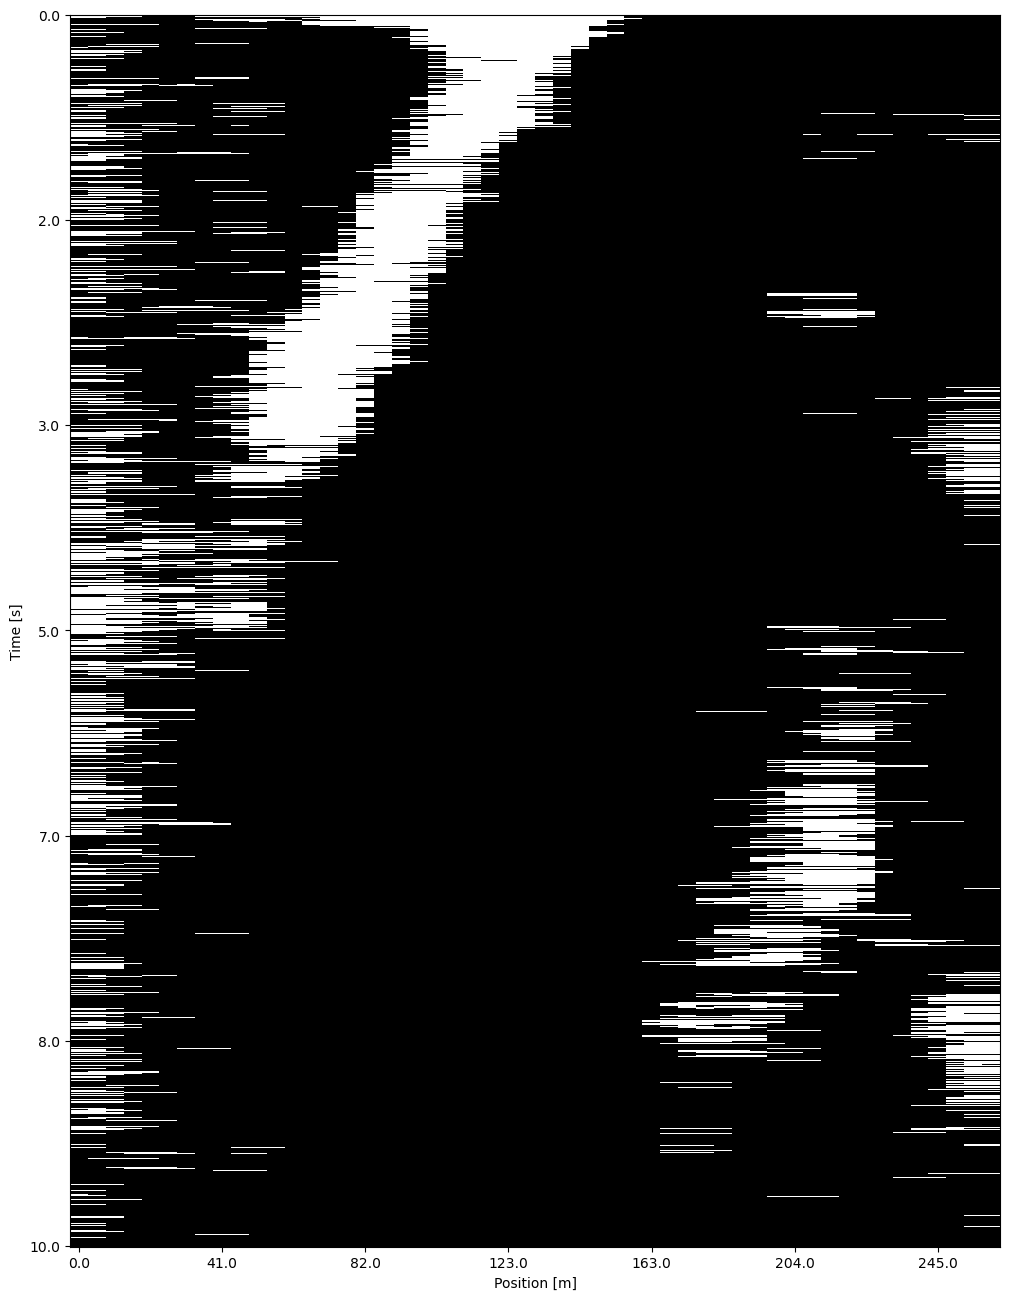

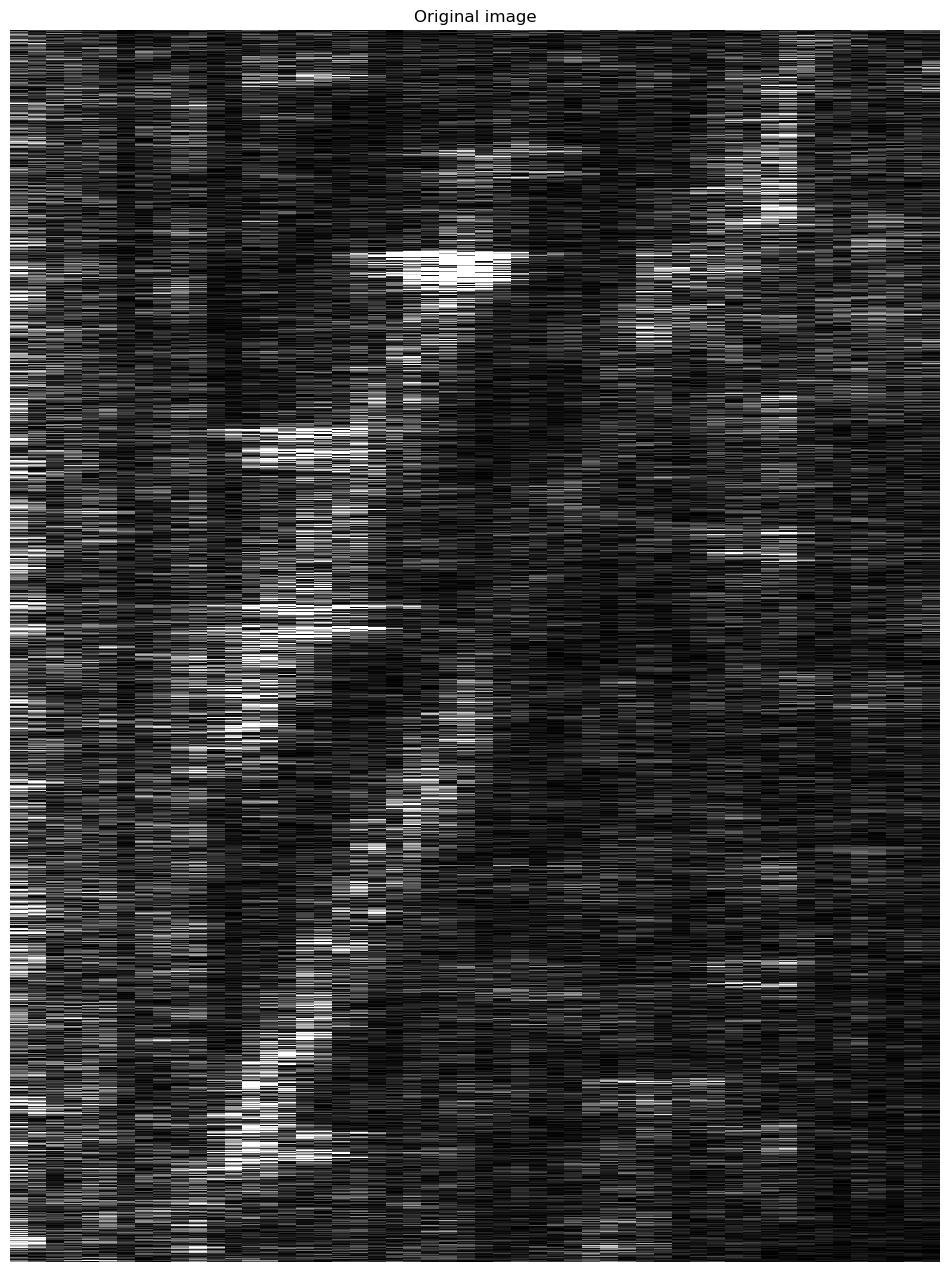

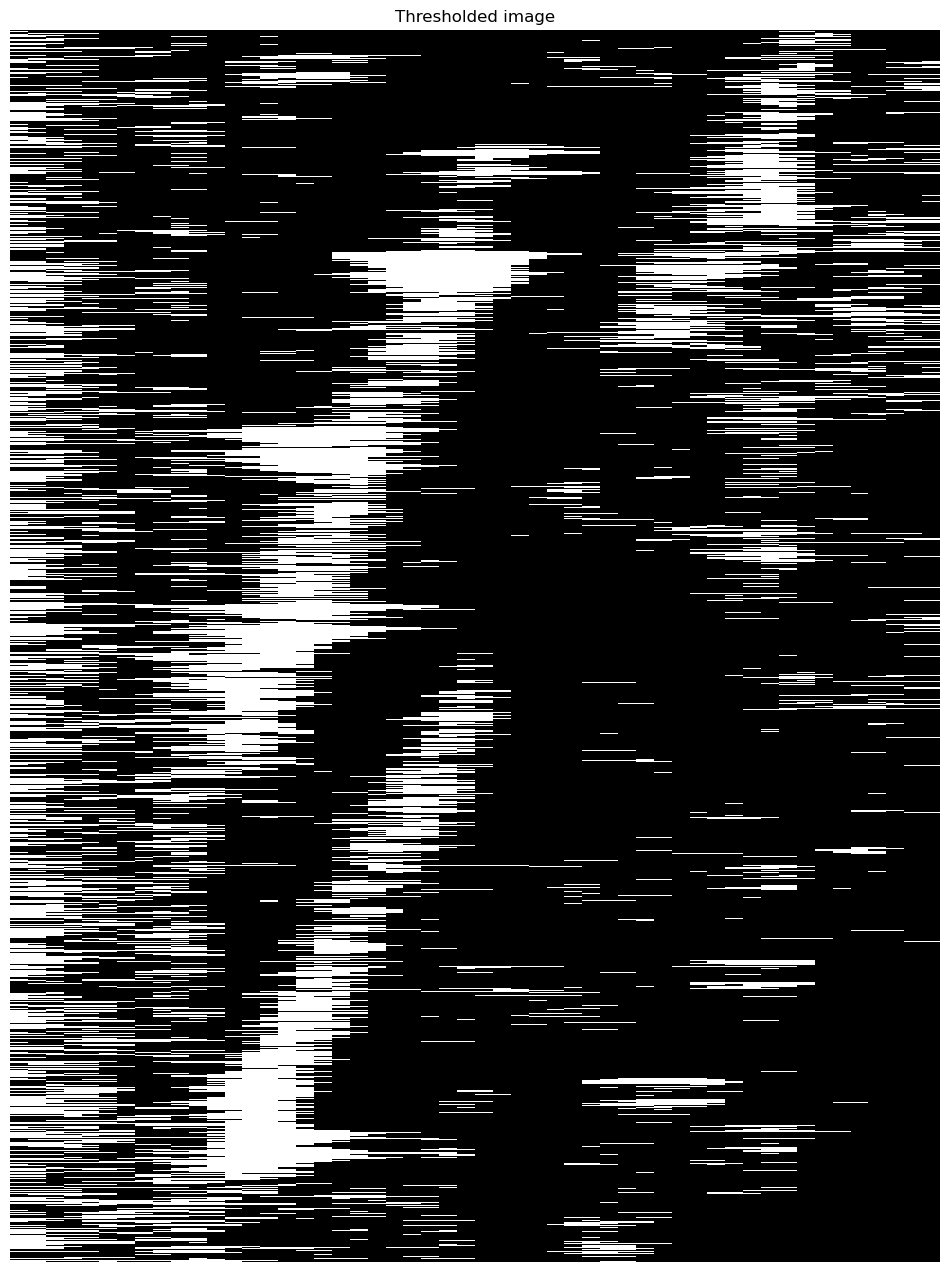

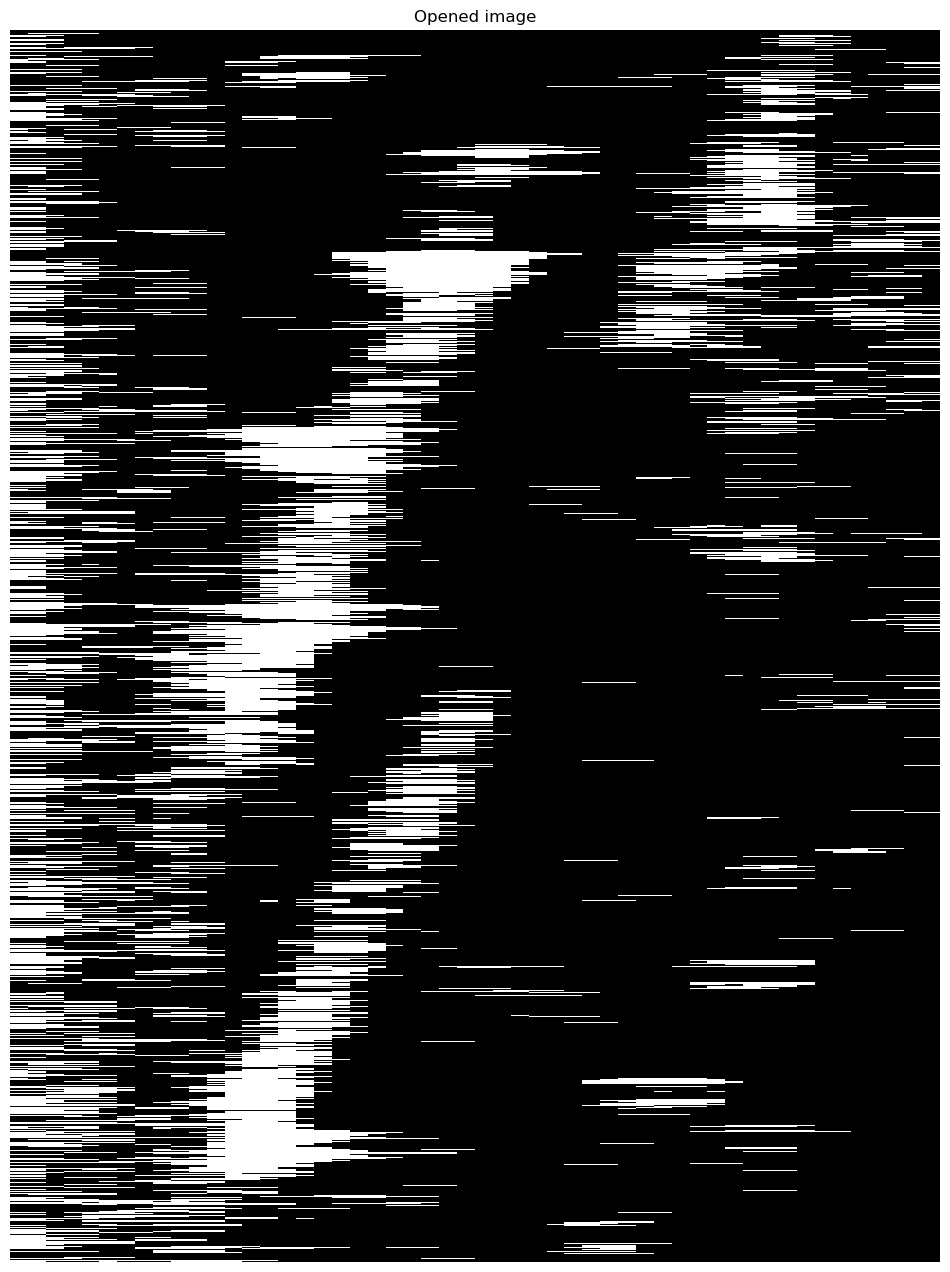

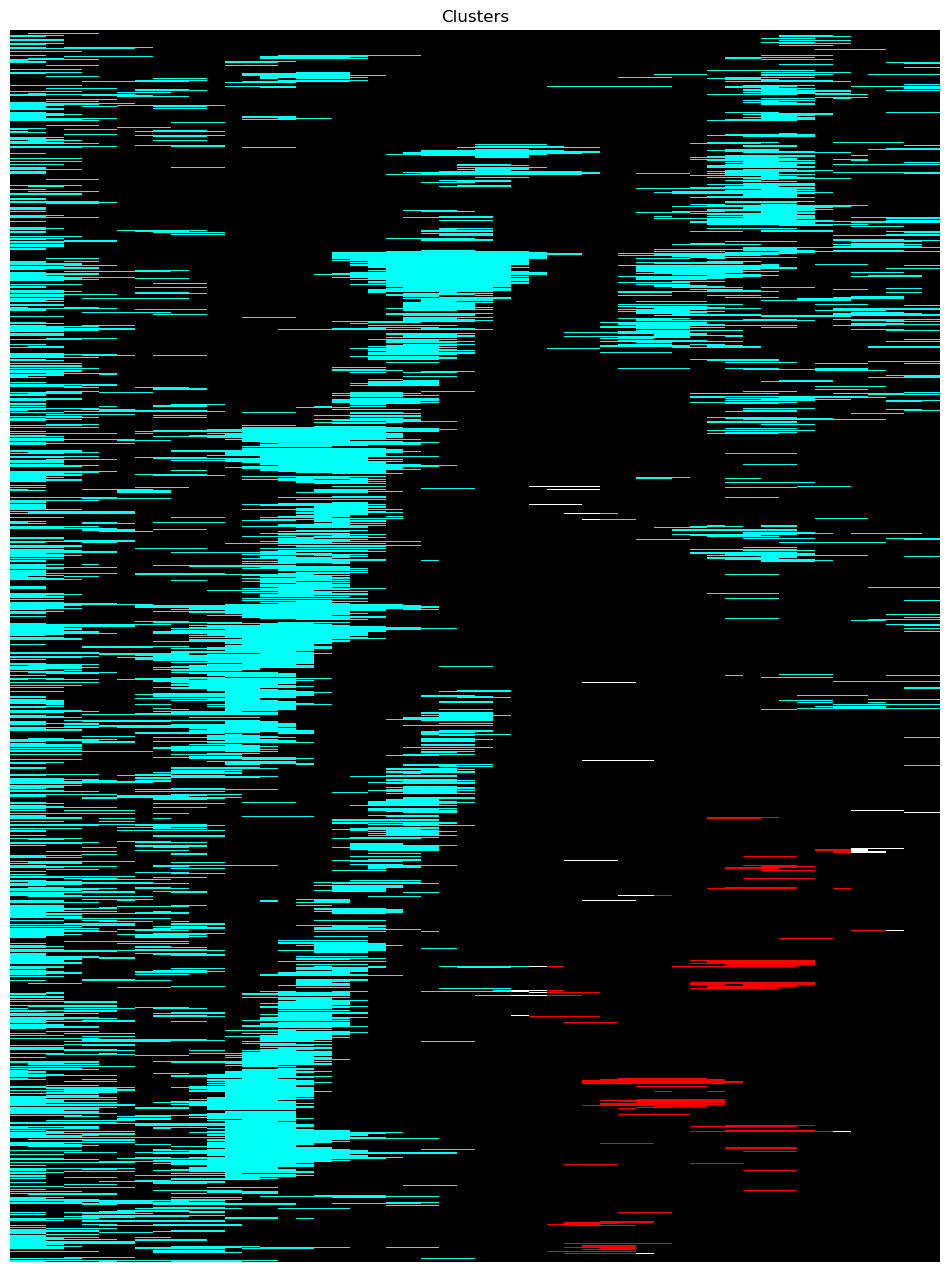

Discarded cluster 0 with R2=0.21518484757652545 (<0.6)
Discarded cluster 1 with R2=0.35514533106588453 (<0.6)


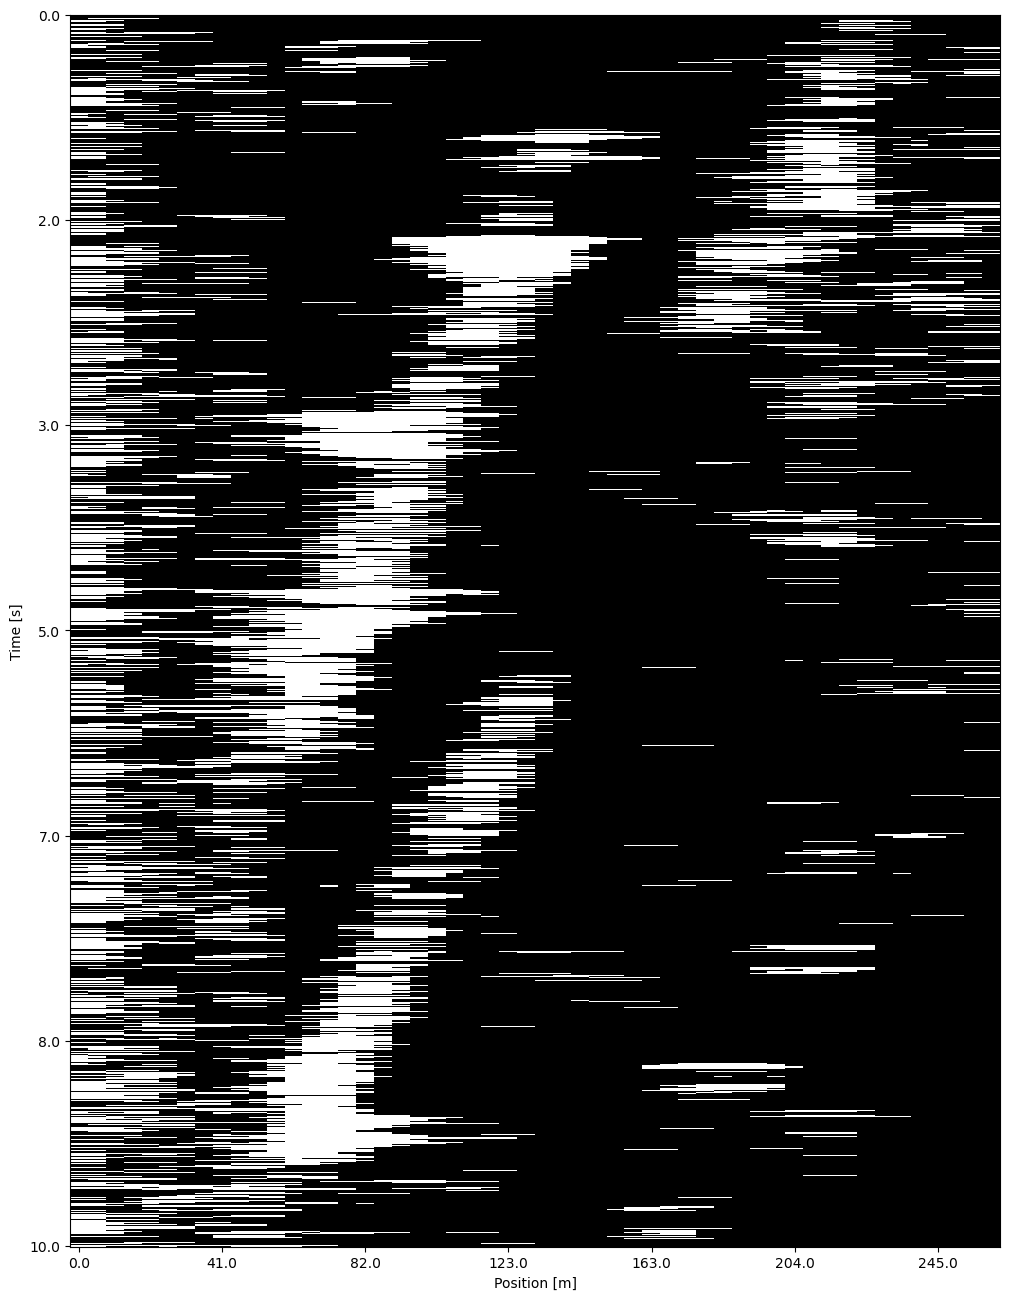

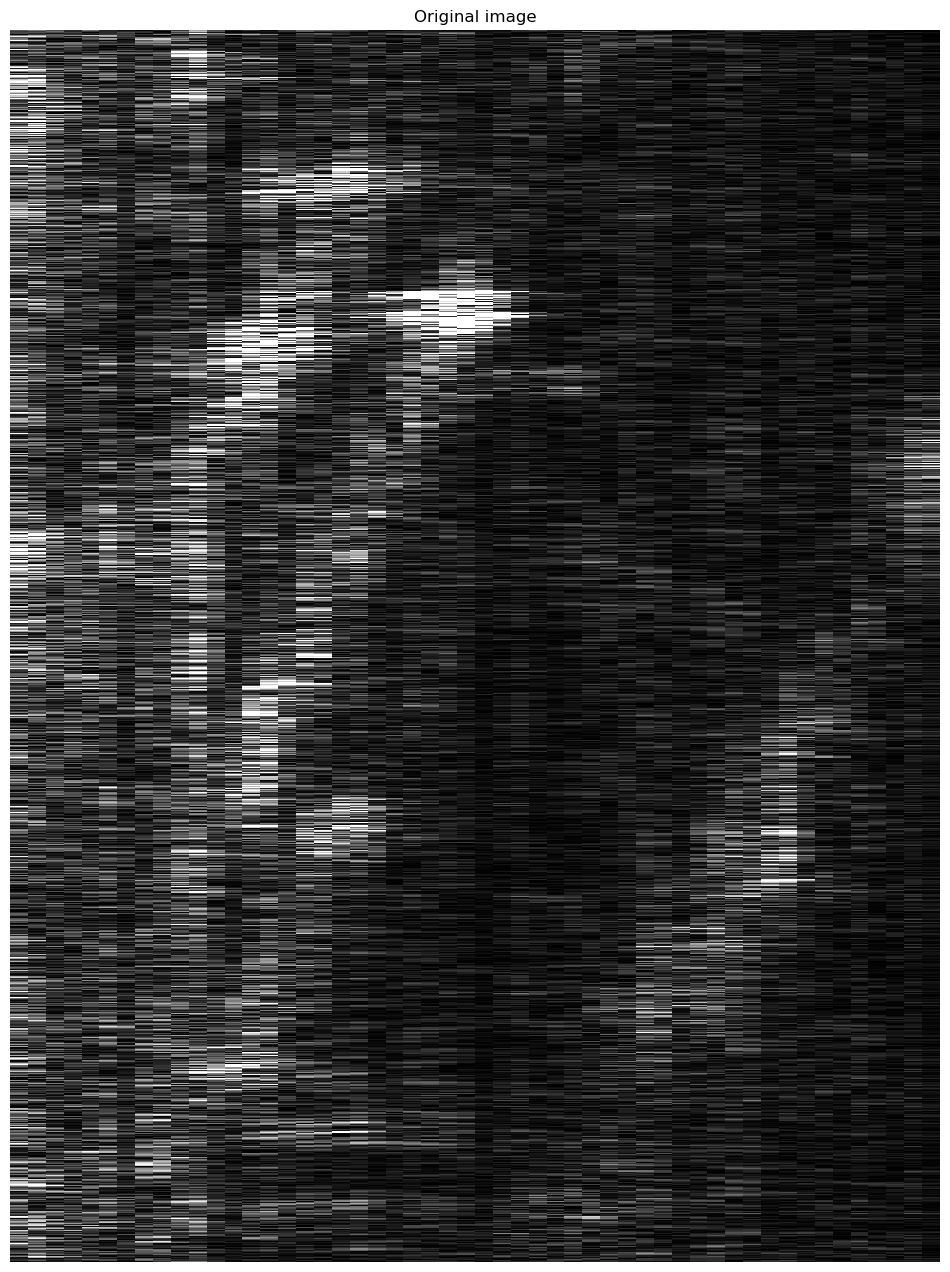

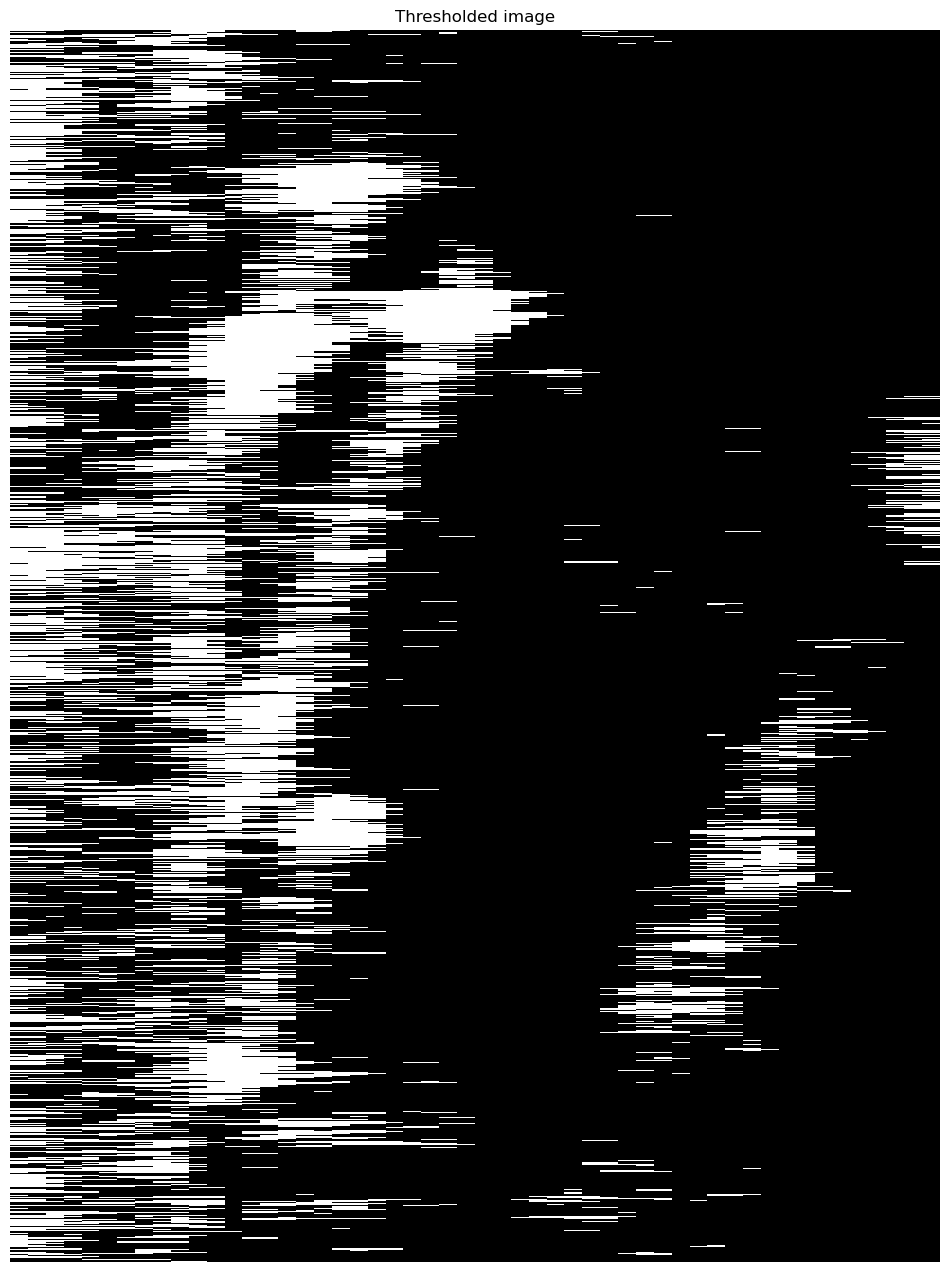

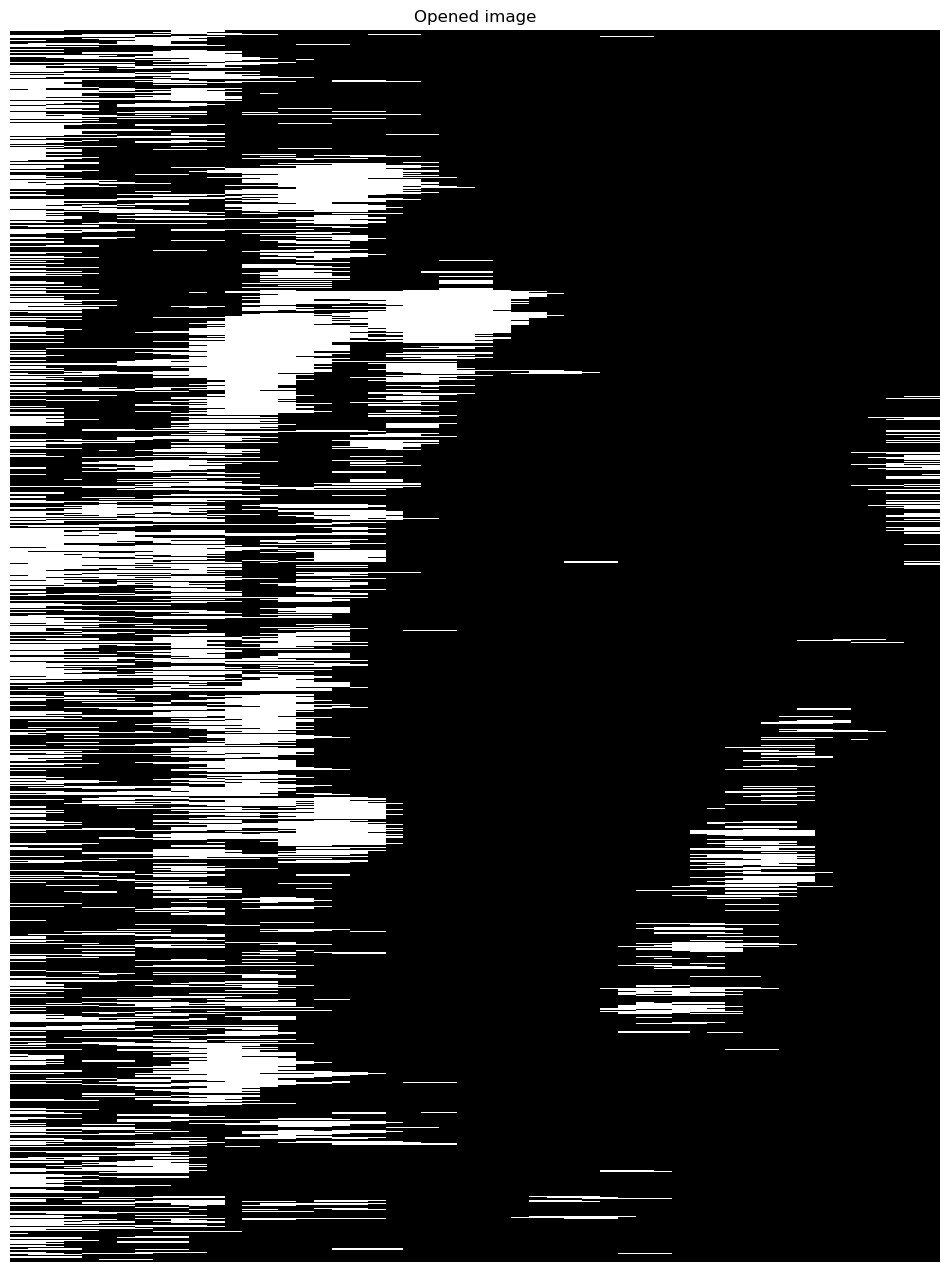

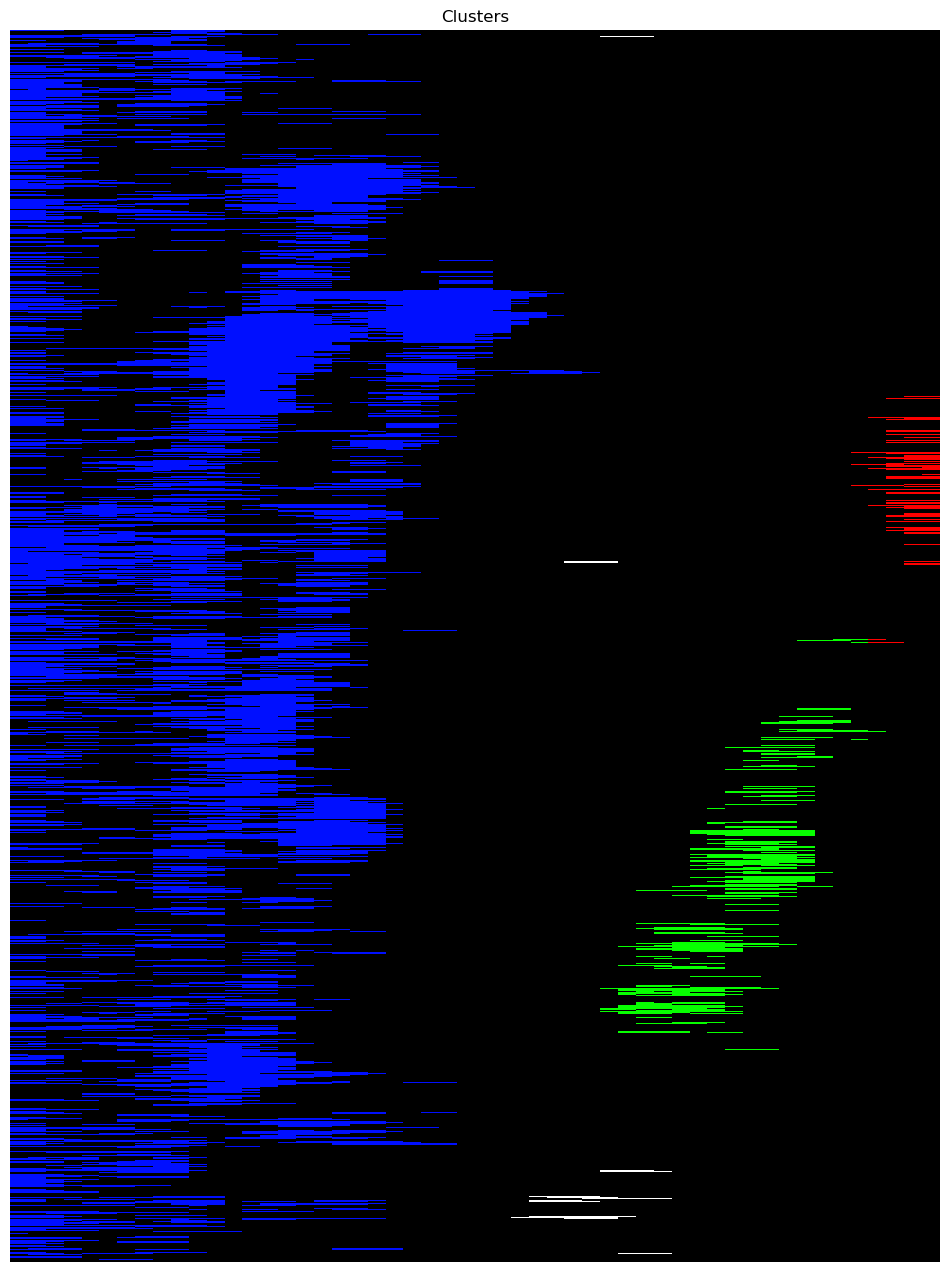

Discarded cluster 0 with R2=0.023153851774705414 (<0.6)
Discarded cluster 1 with R2=0.0017509060023337408 (<0.6)
Discarded cluster 2 with R2=0.5927099234507797 (<0.6)


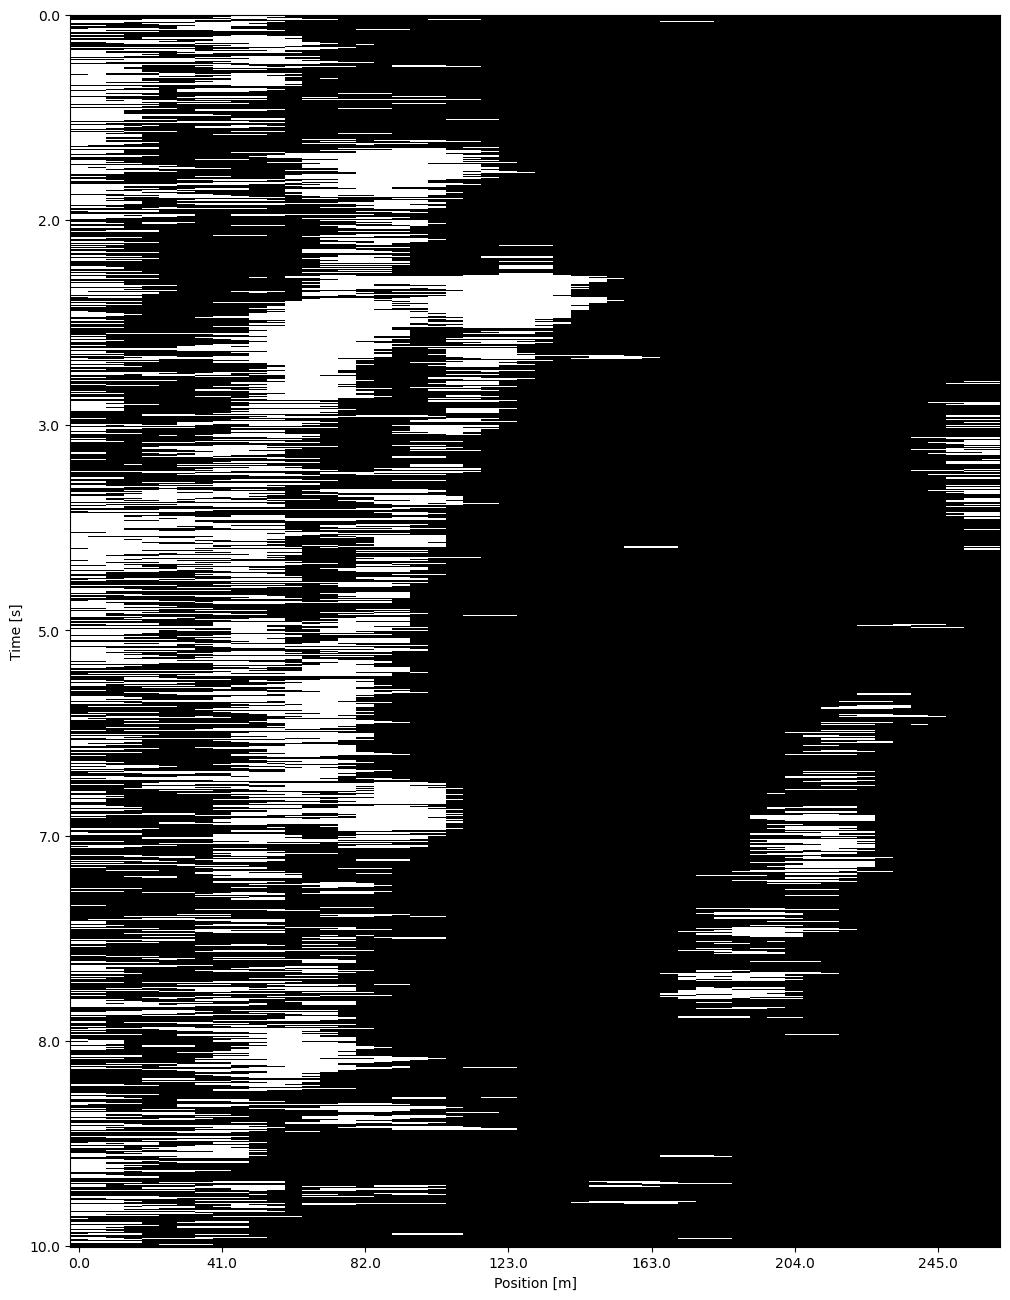

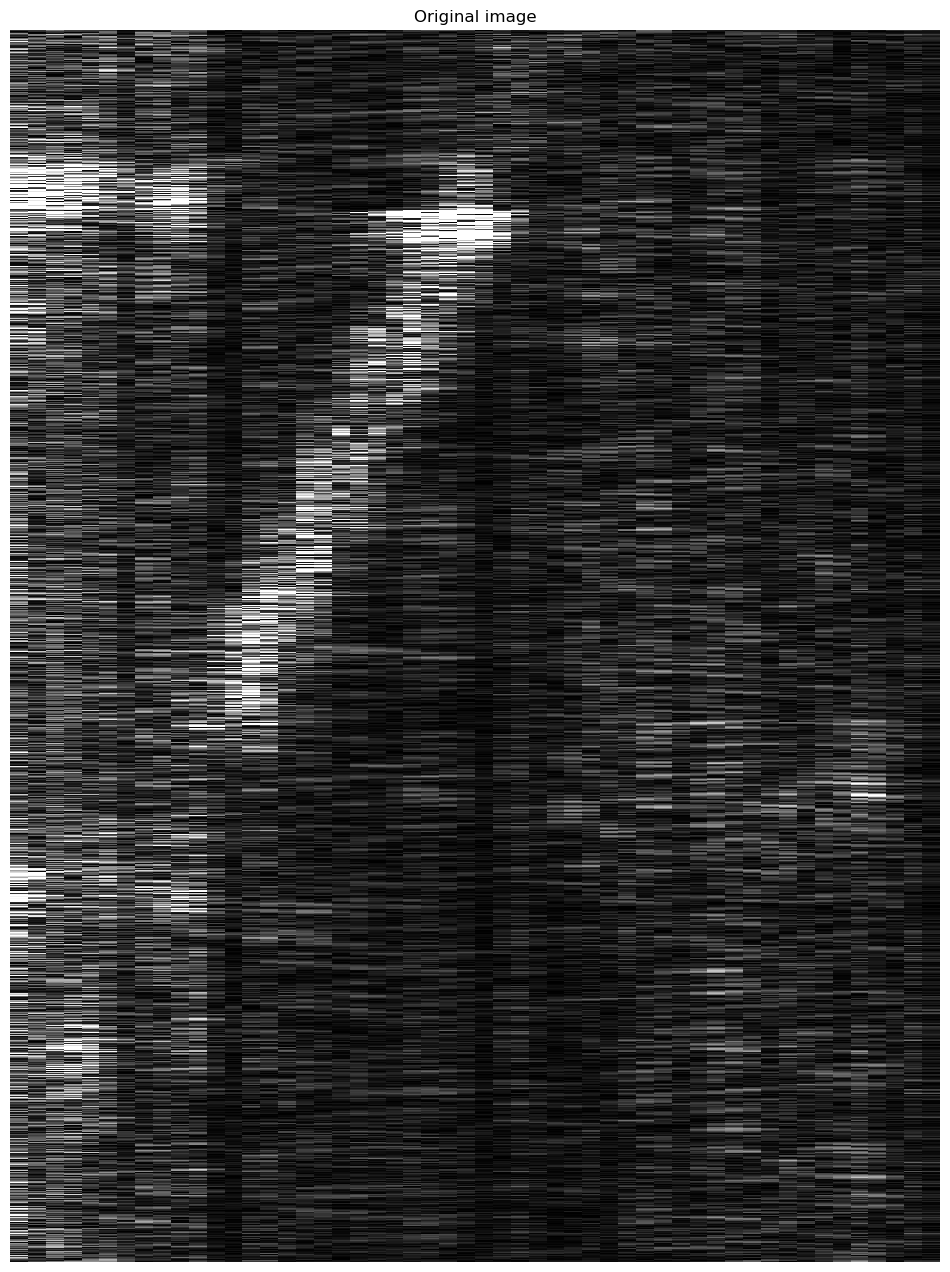

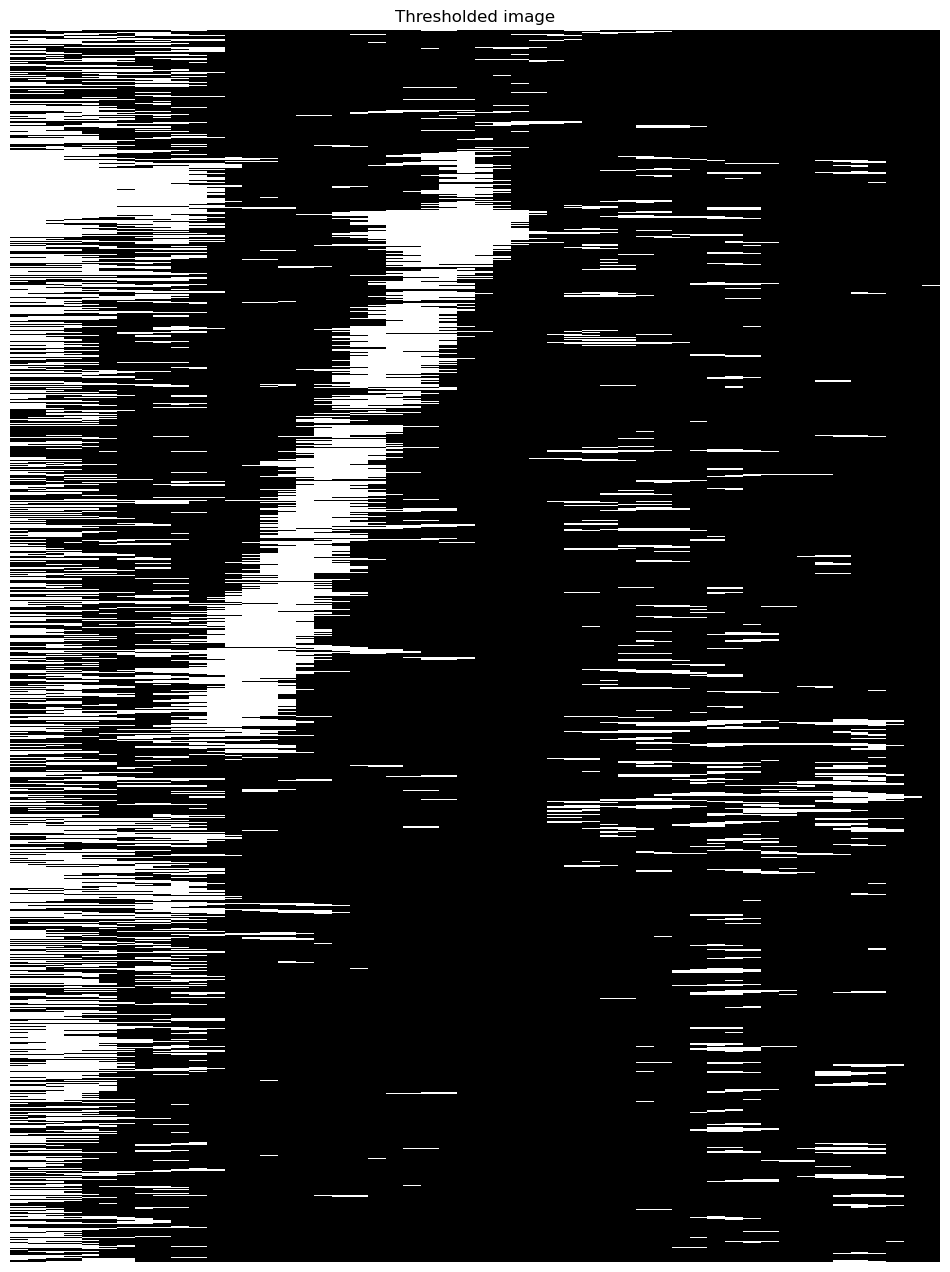

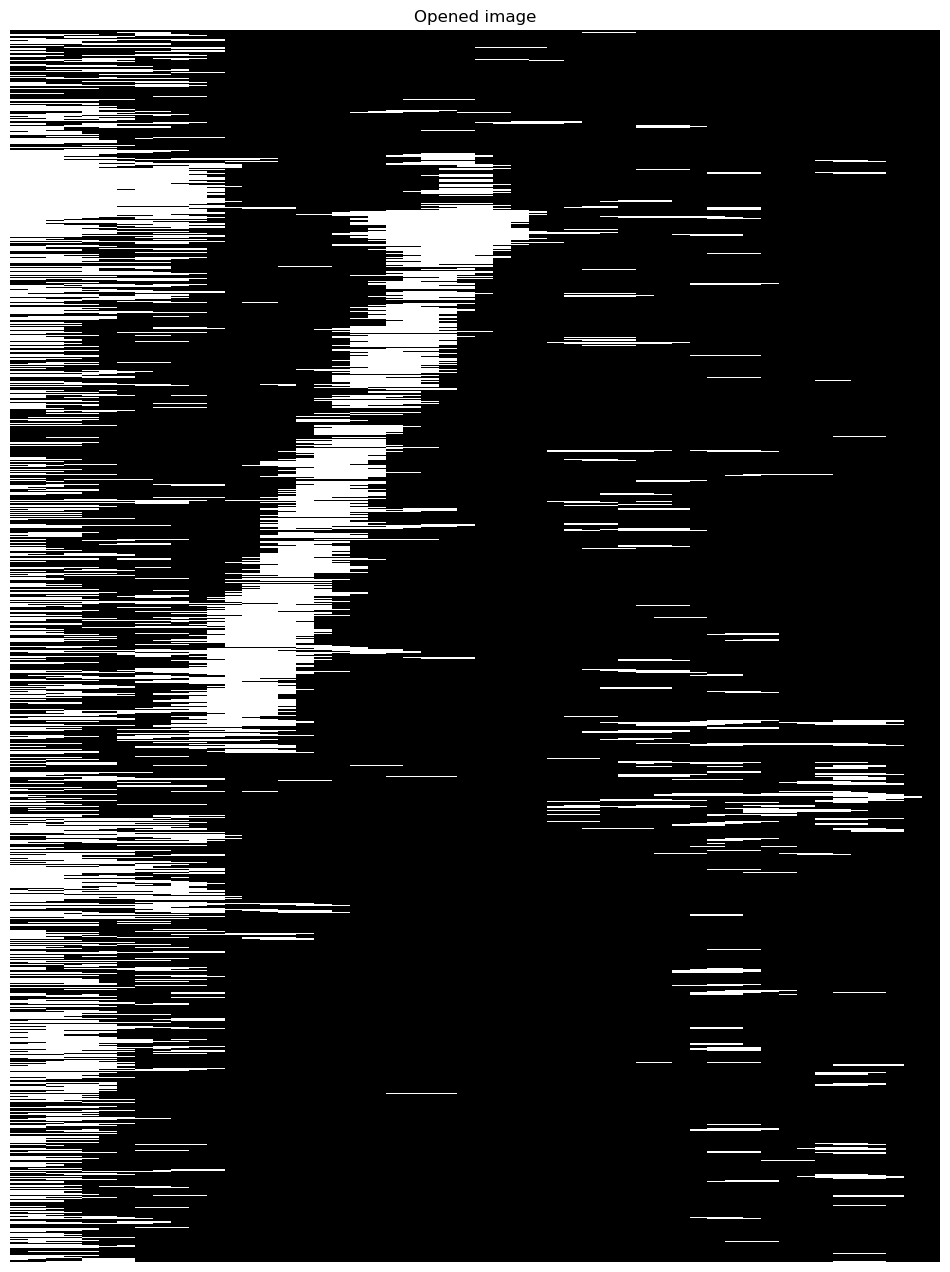

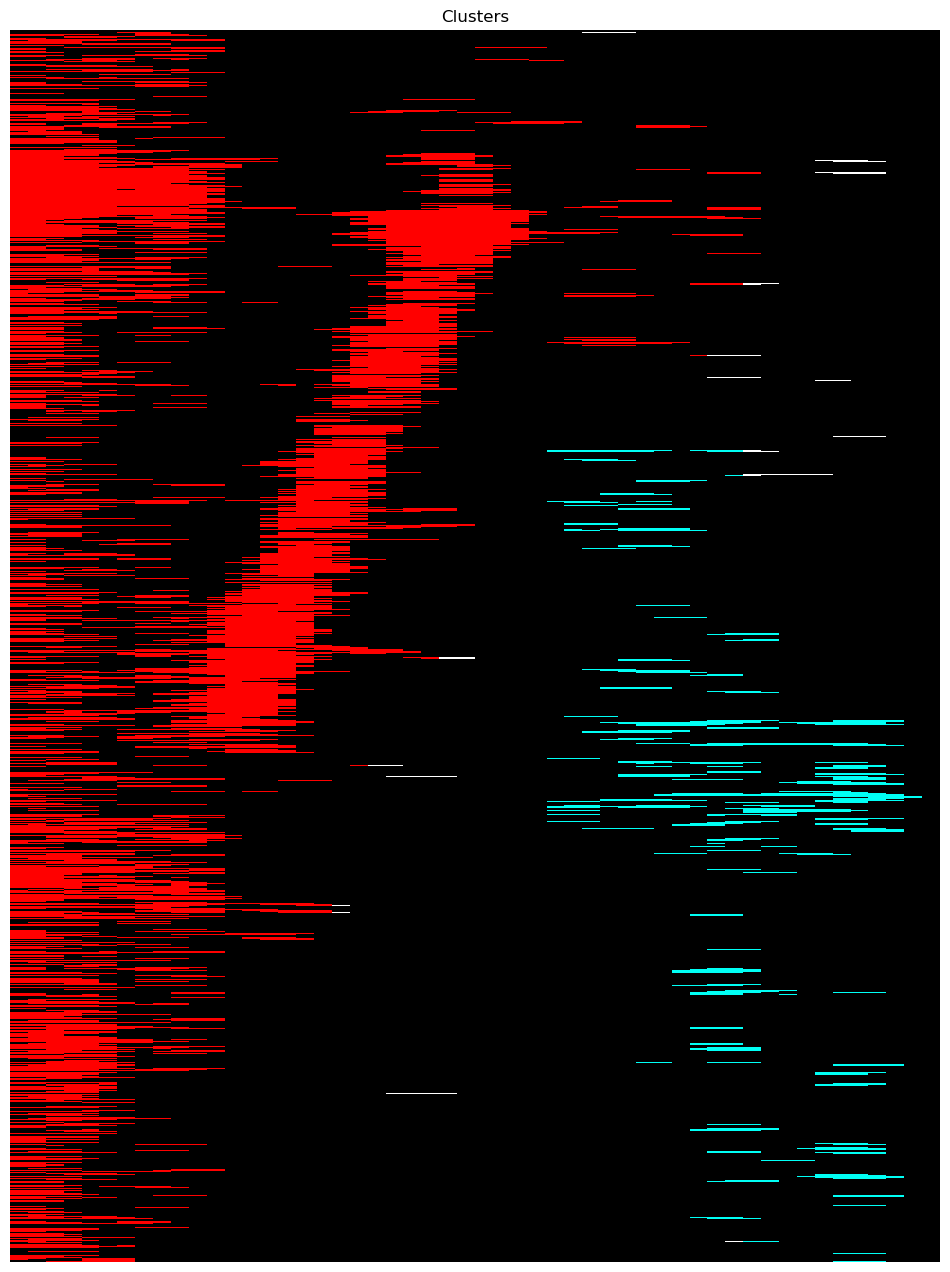

Discarded cluster 0 with R2=0.125066685104819 (<0.6)
Discarded cluster 1 with R2=0.20134580769088106 (<0.6)


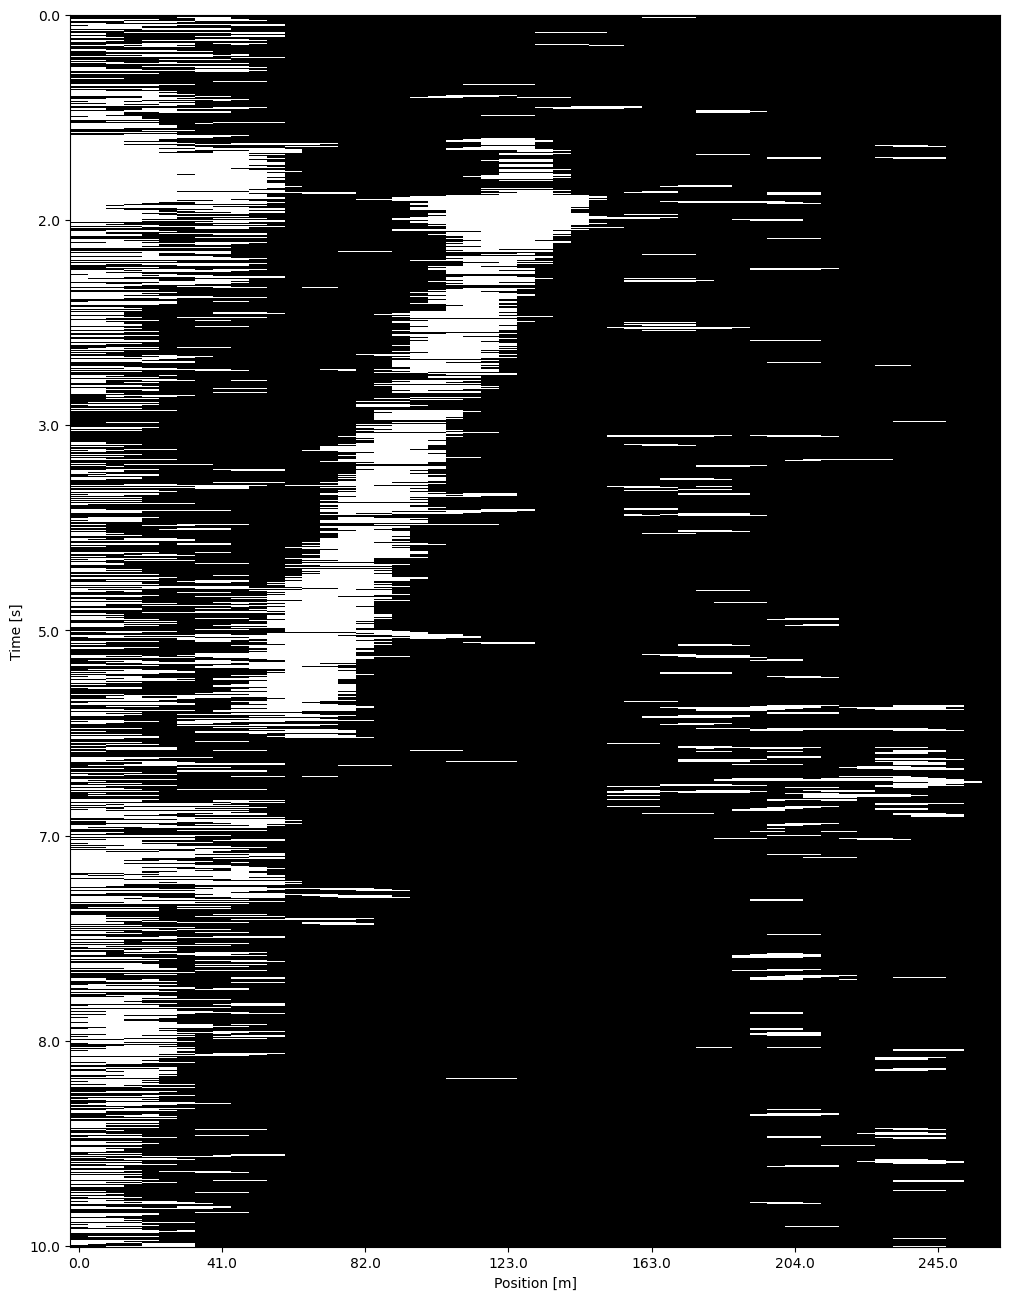

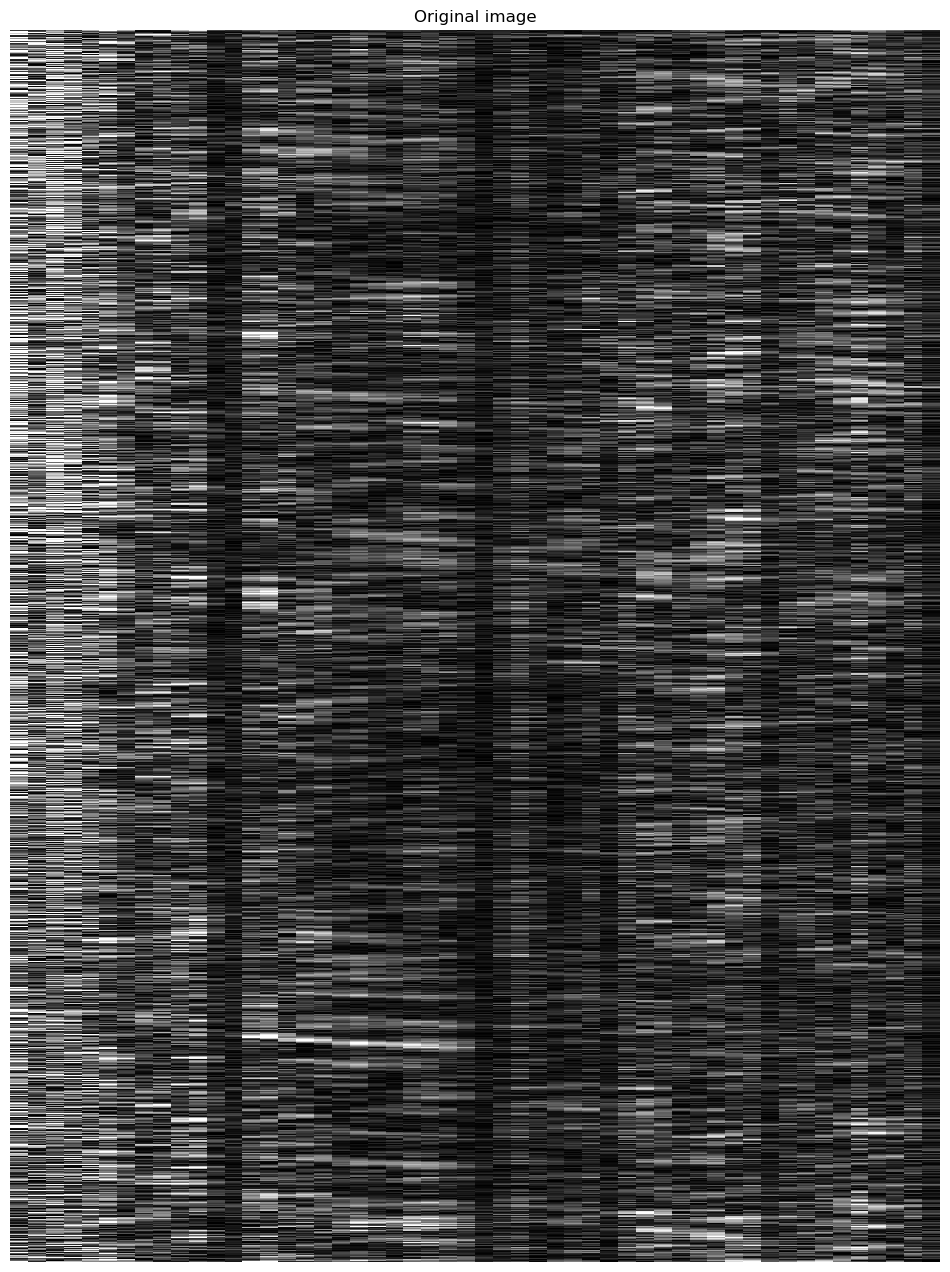

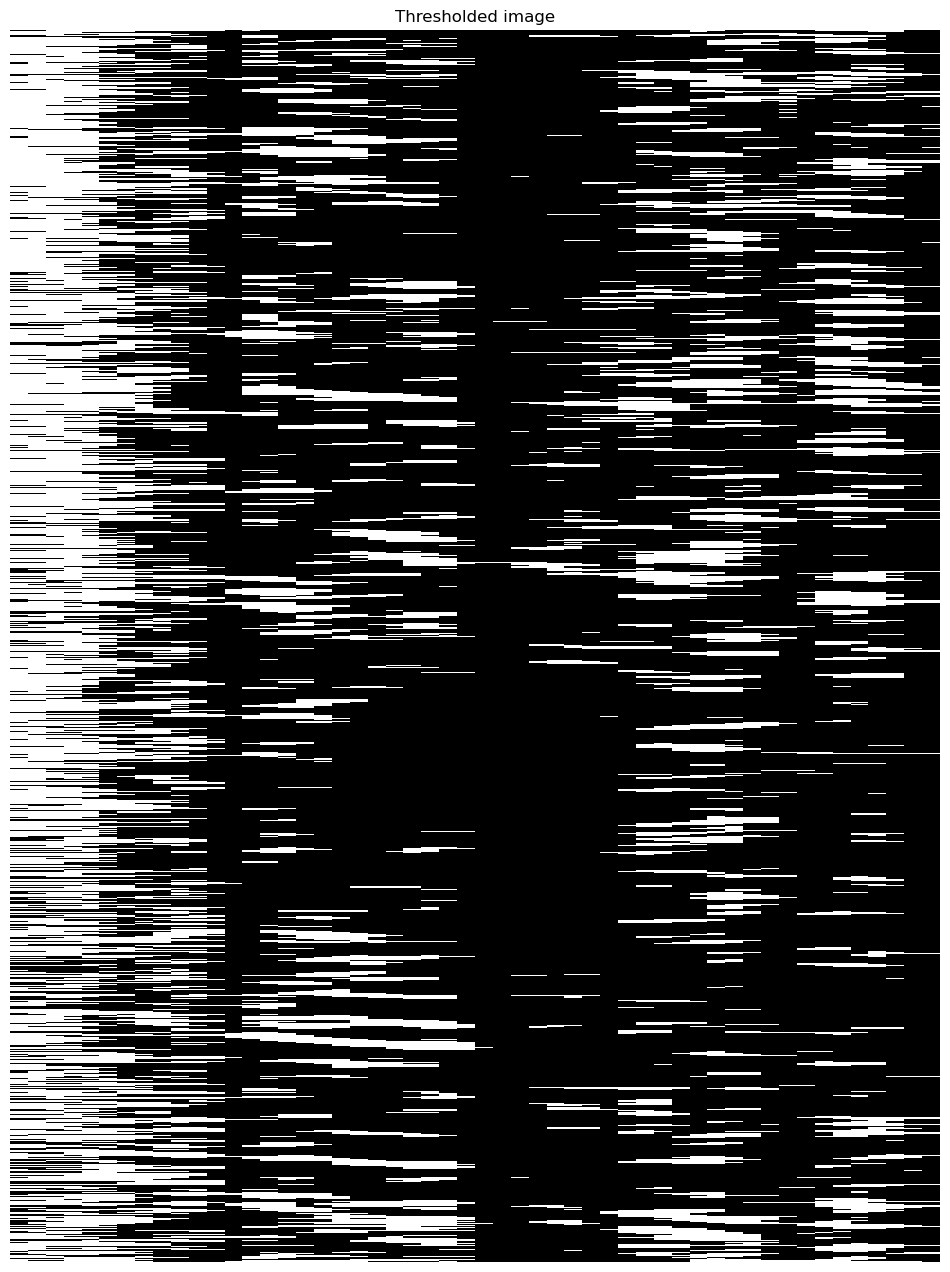

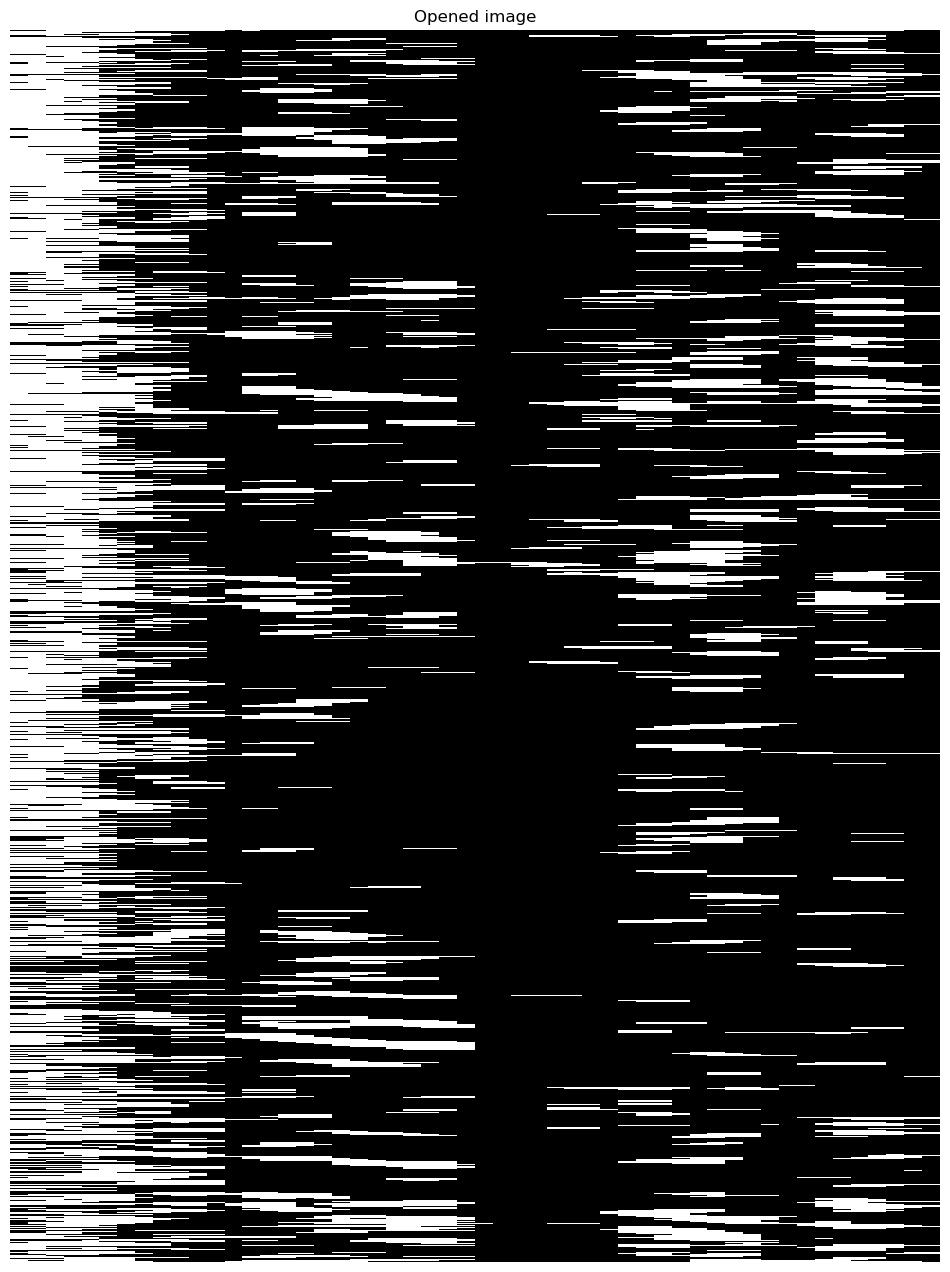

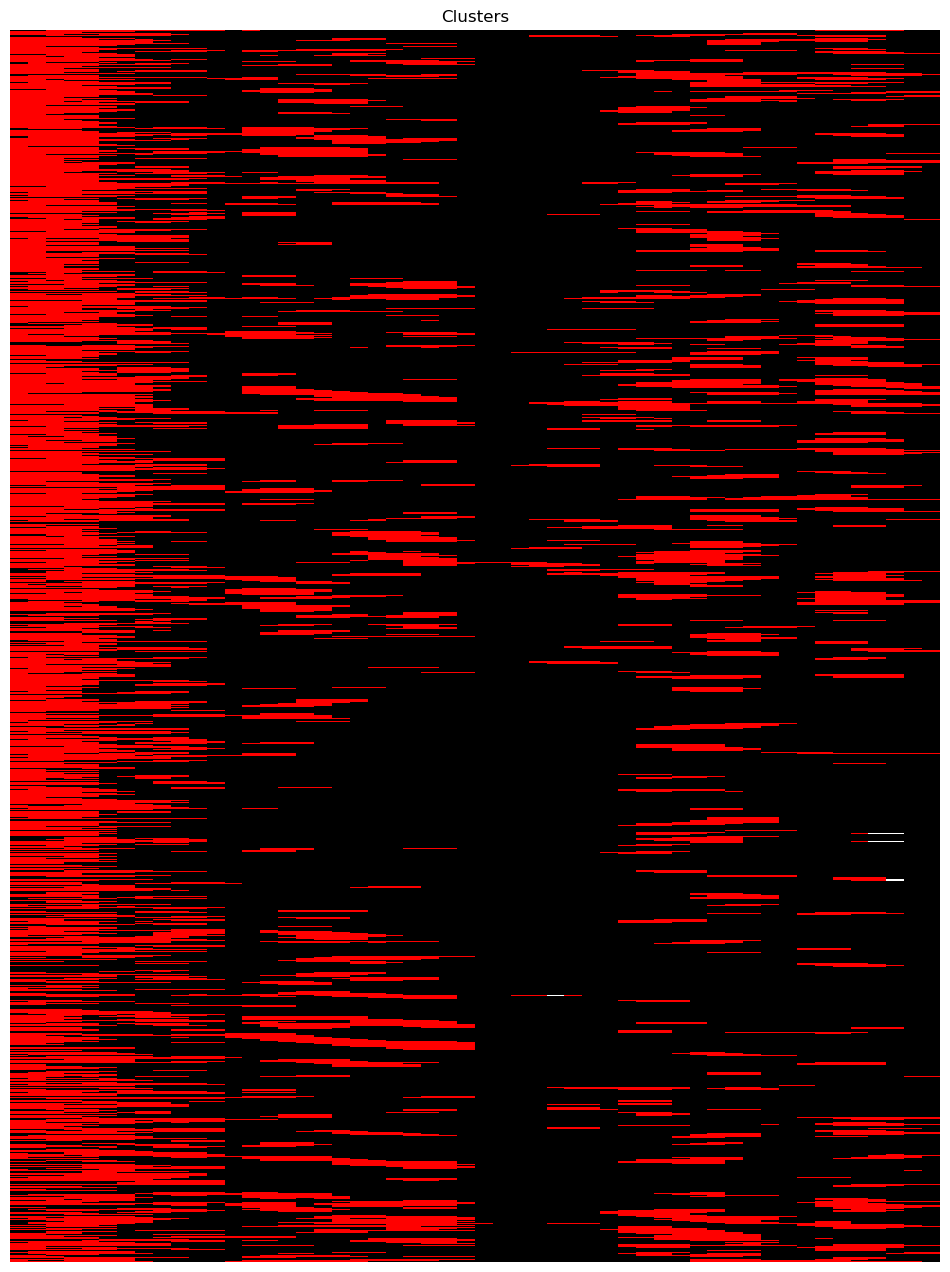

Discarded cluster 0 with R2=0.0018771204852227052 (<0.6)


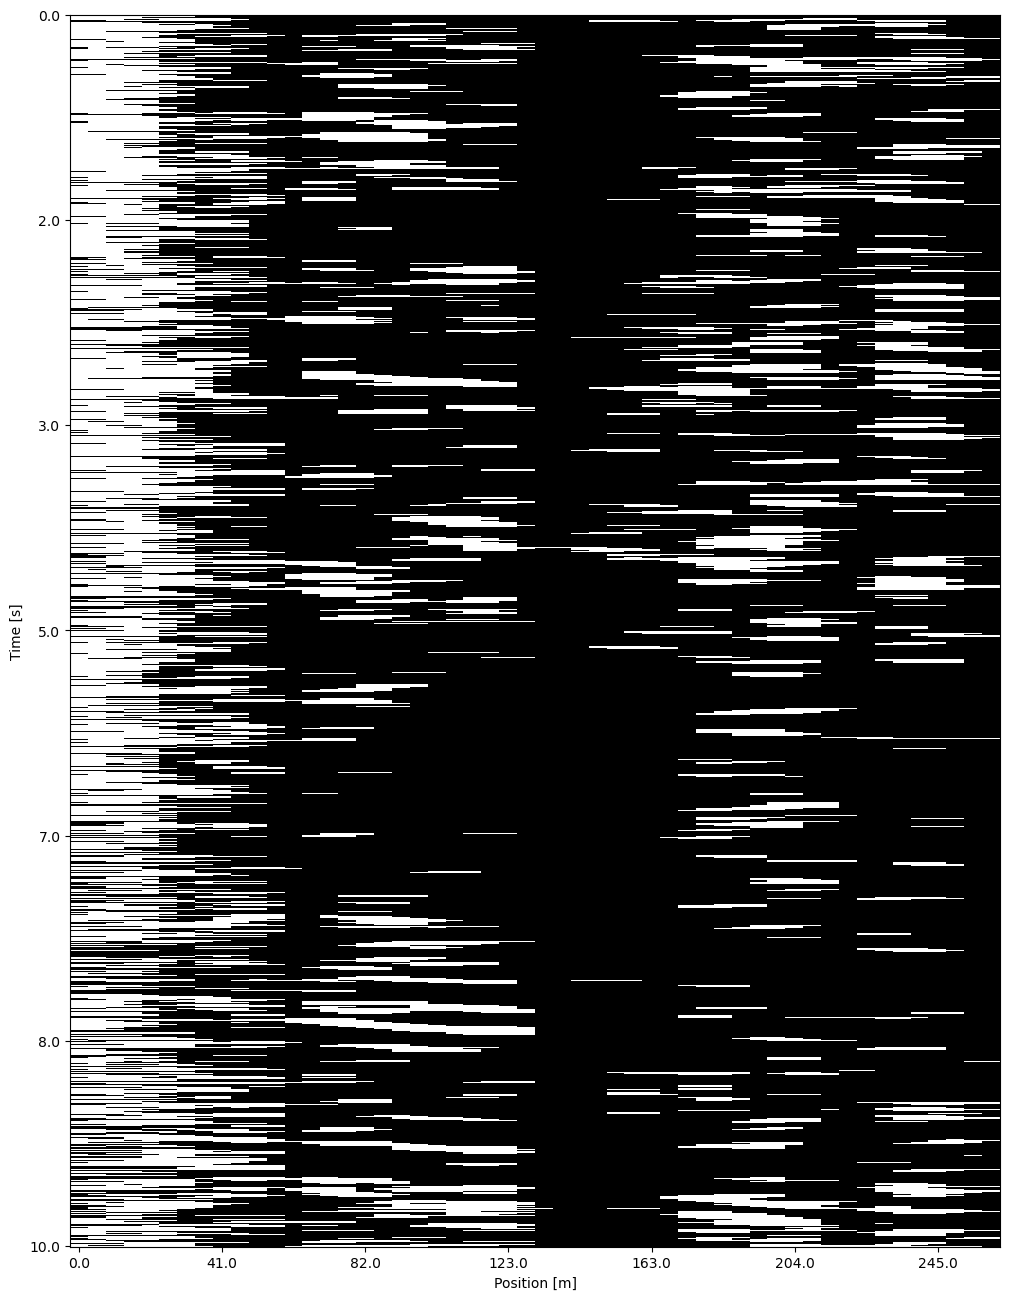

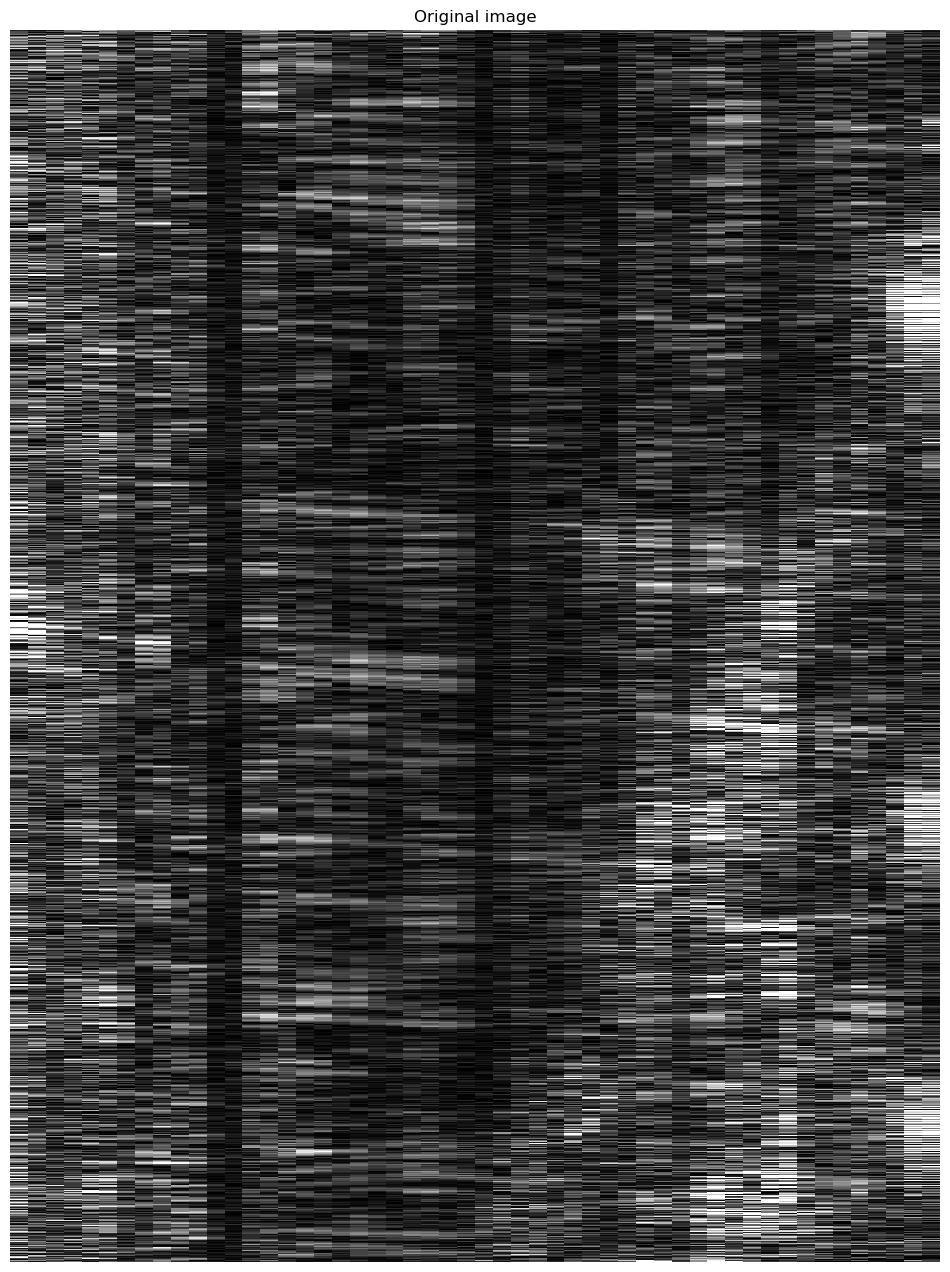

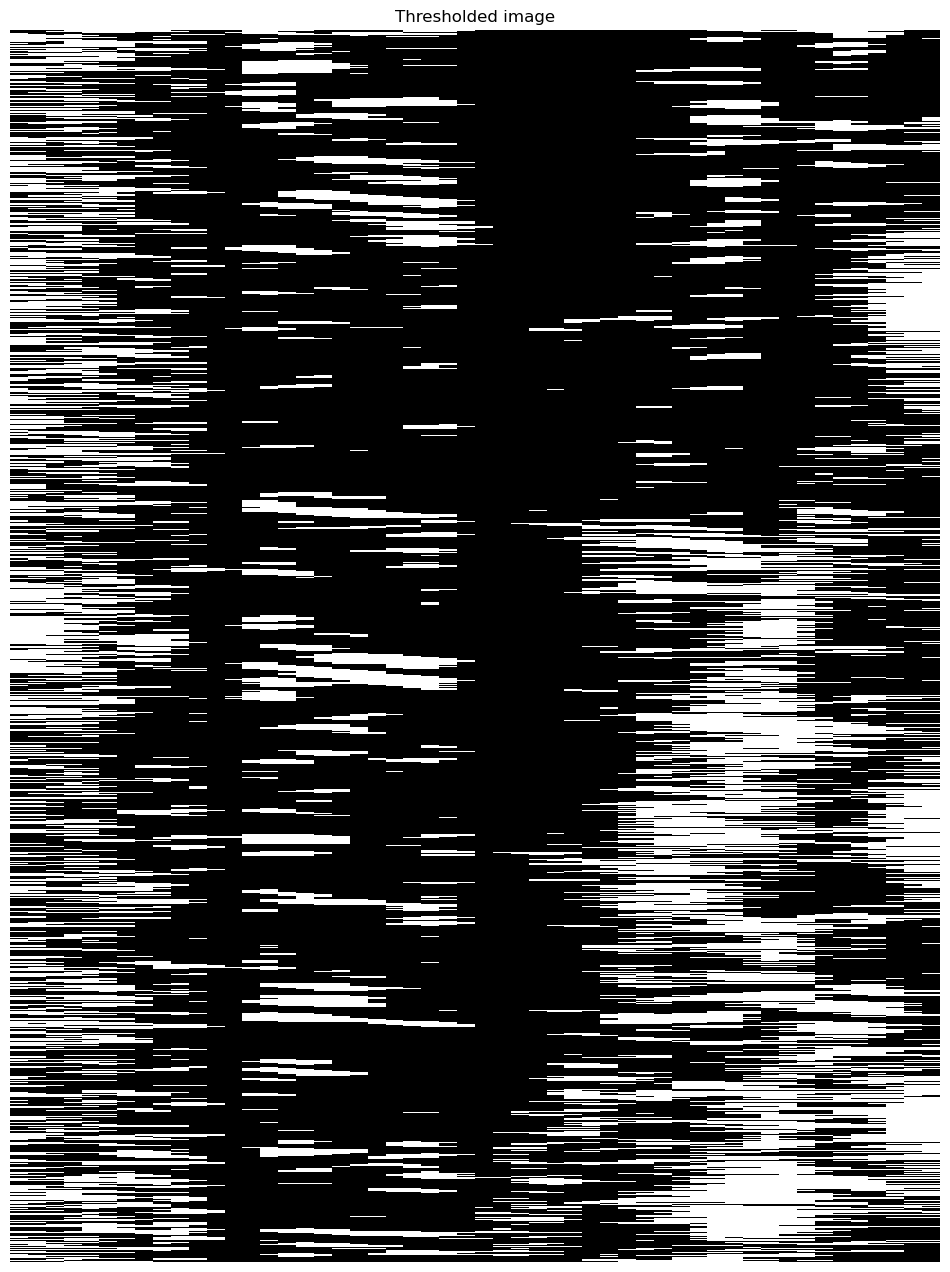

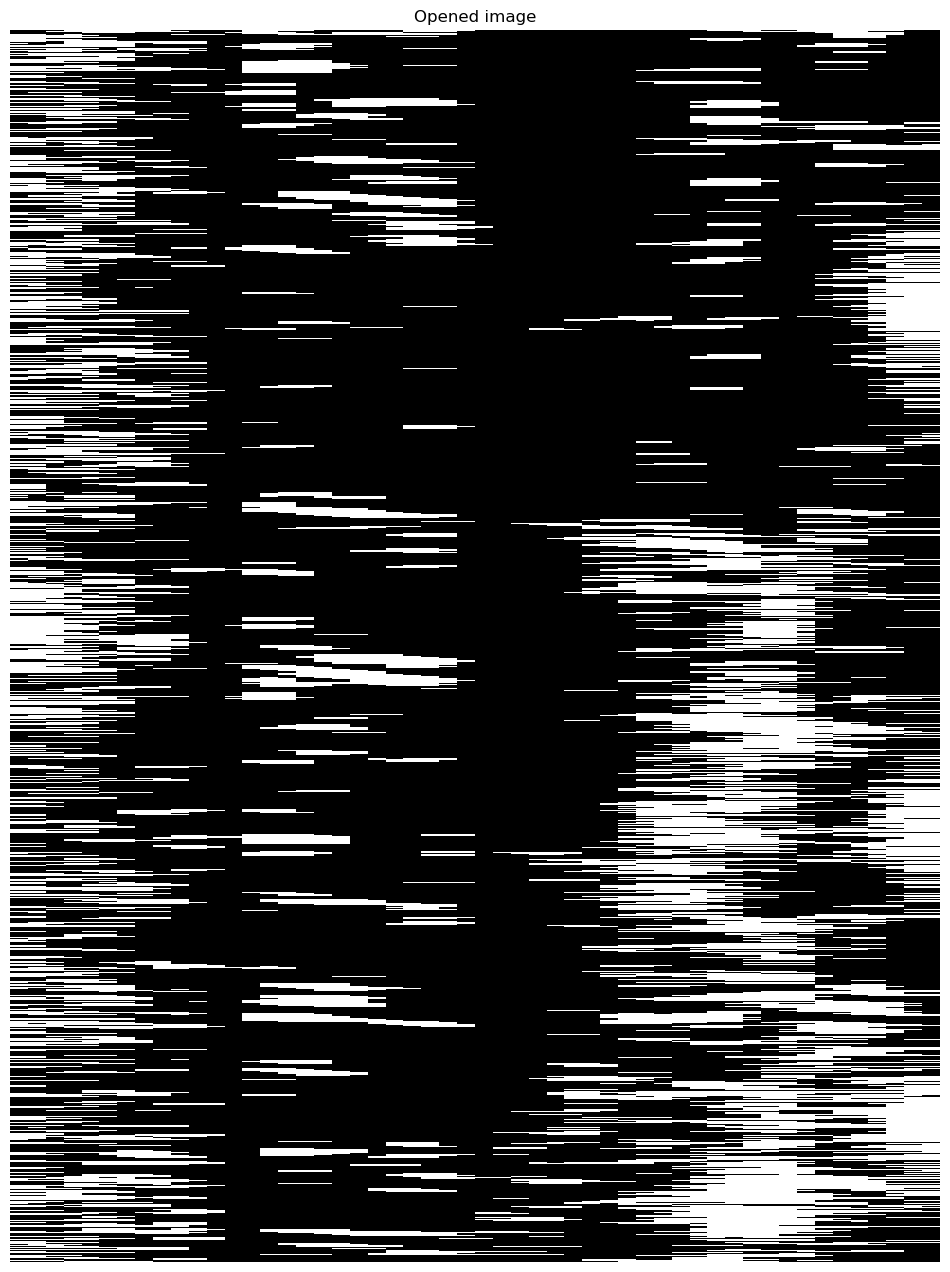

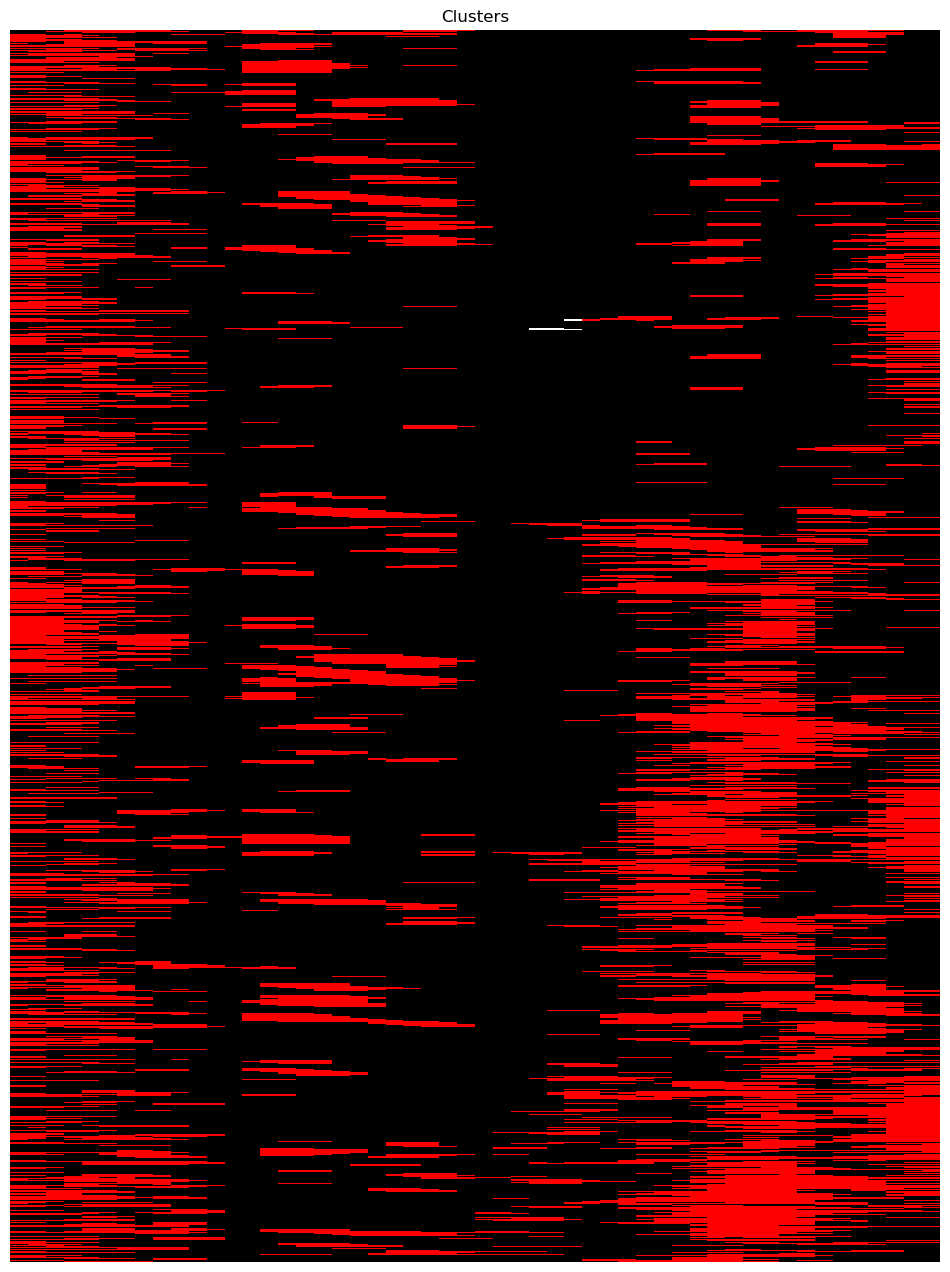

Discarded cluster 0 with R2=0.04396955637773636 (<0.6)


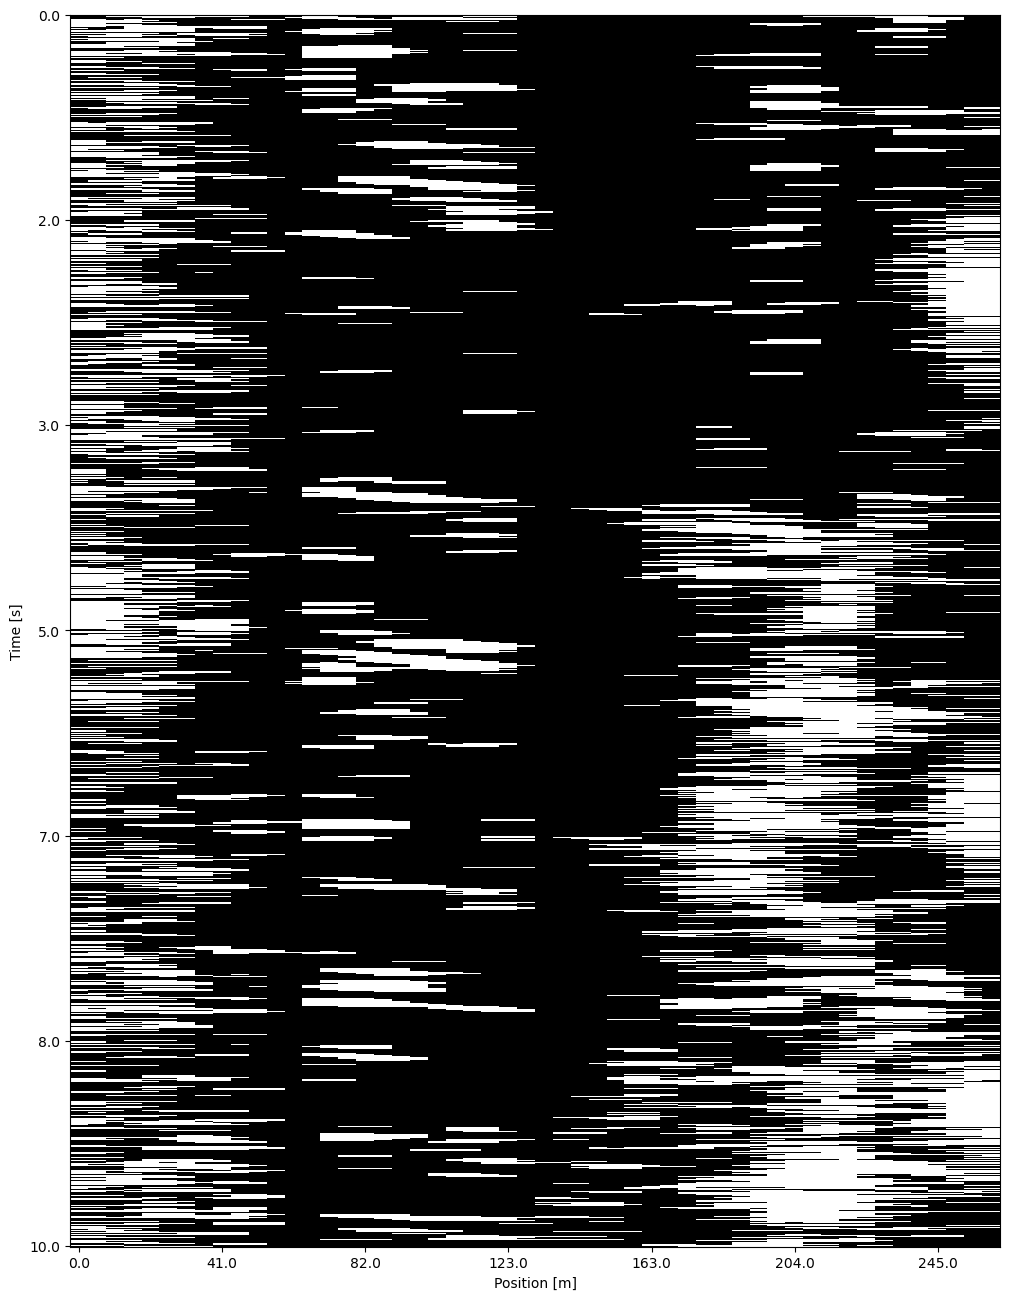

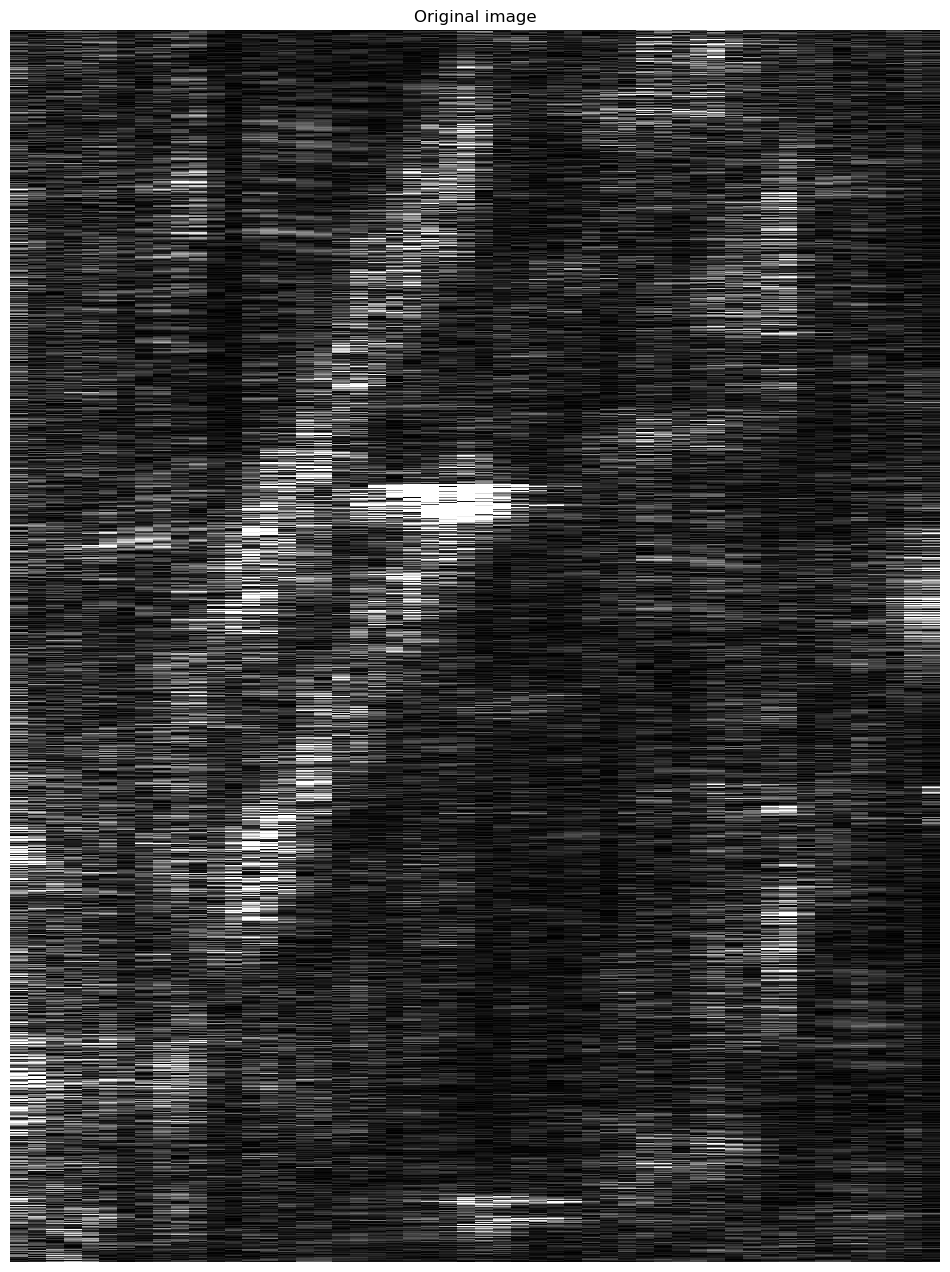

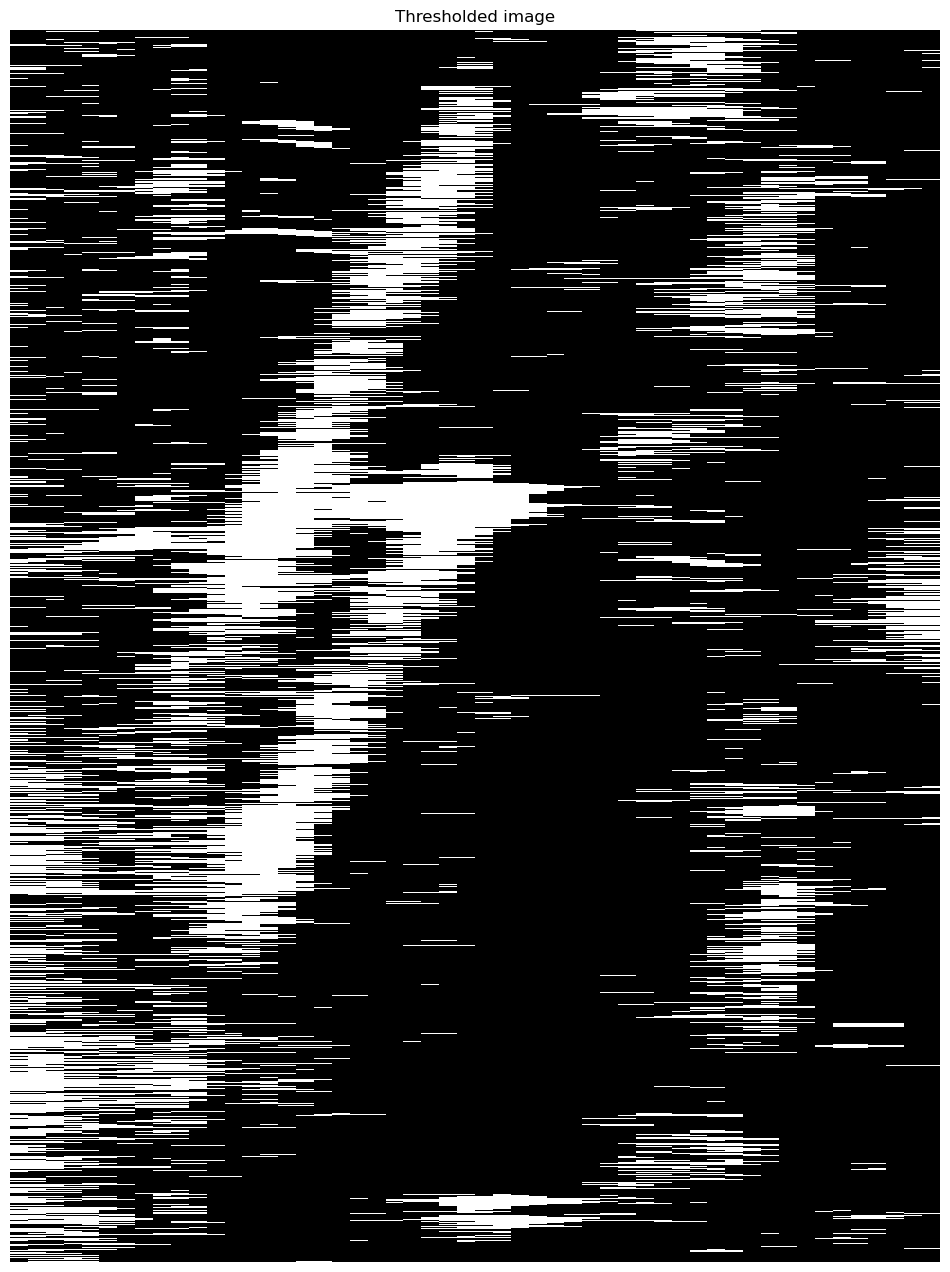

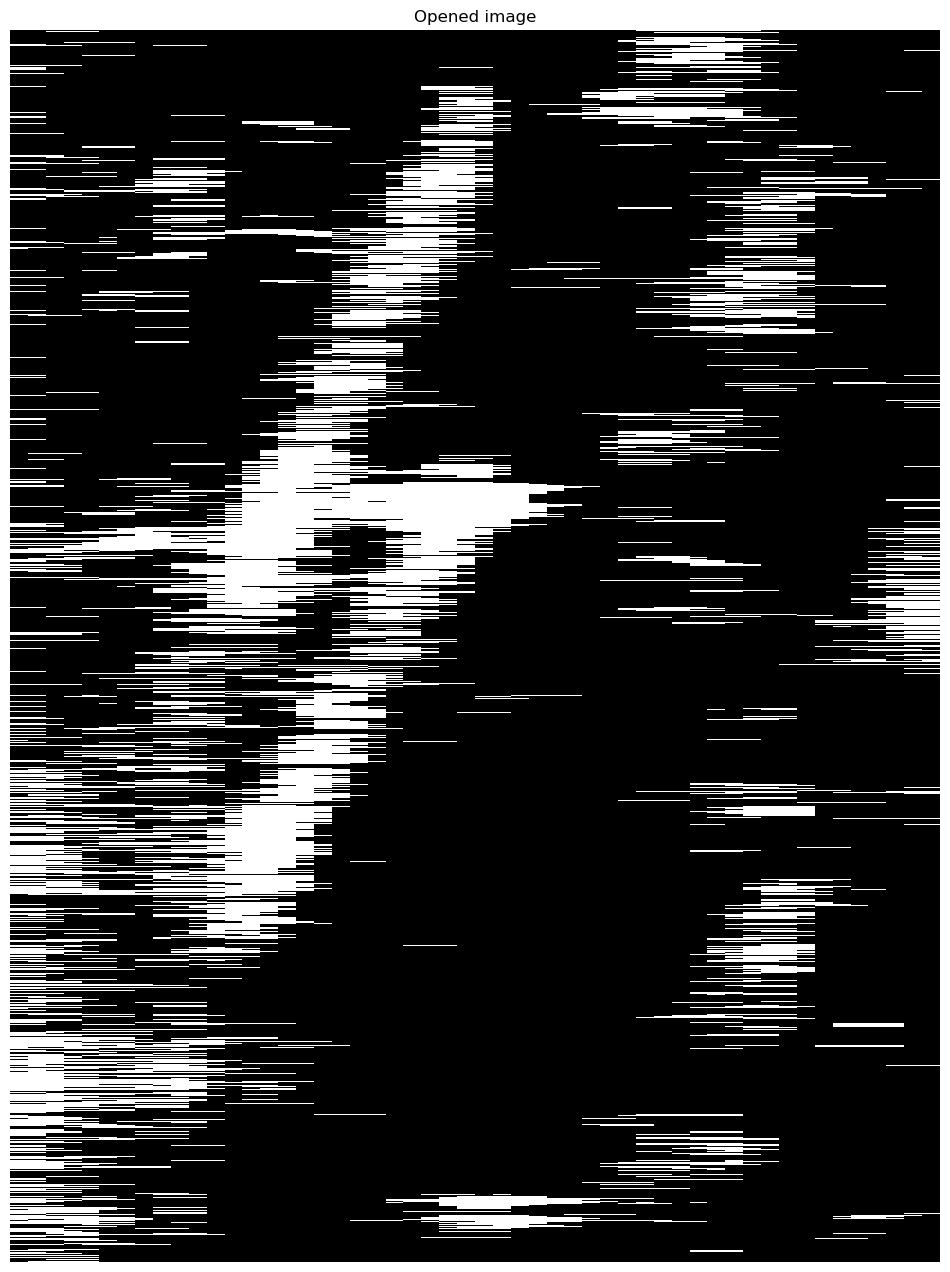

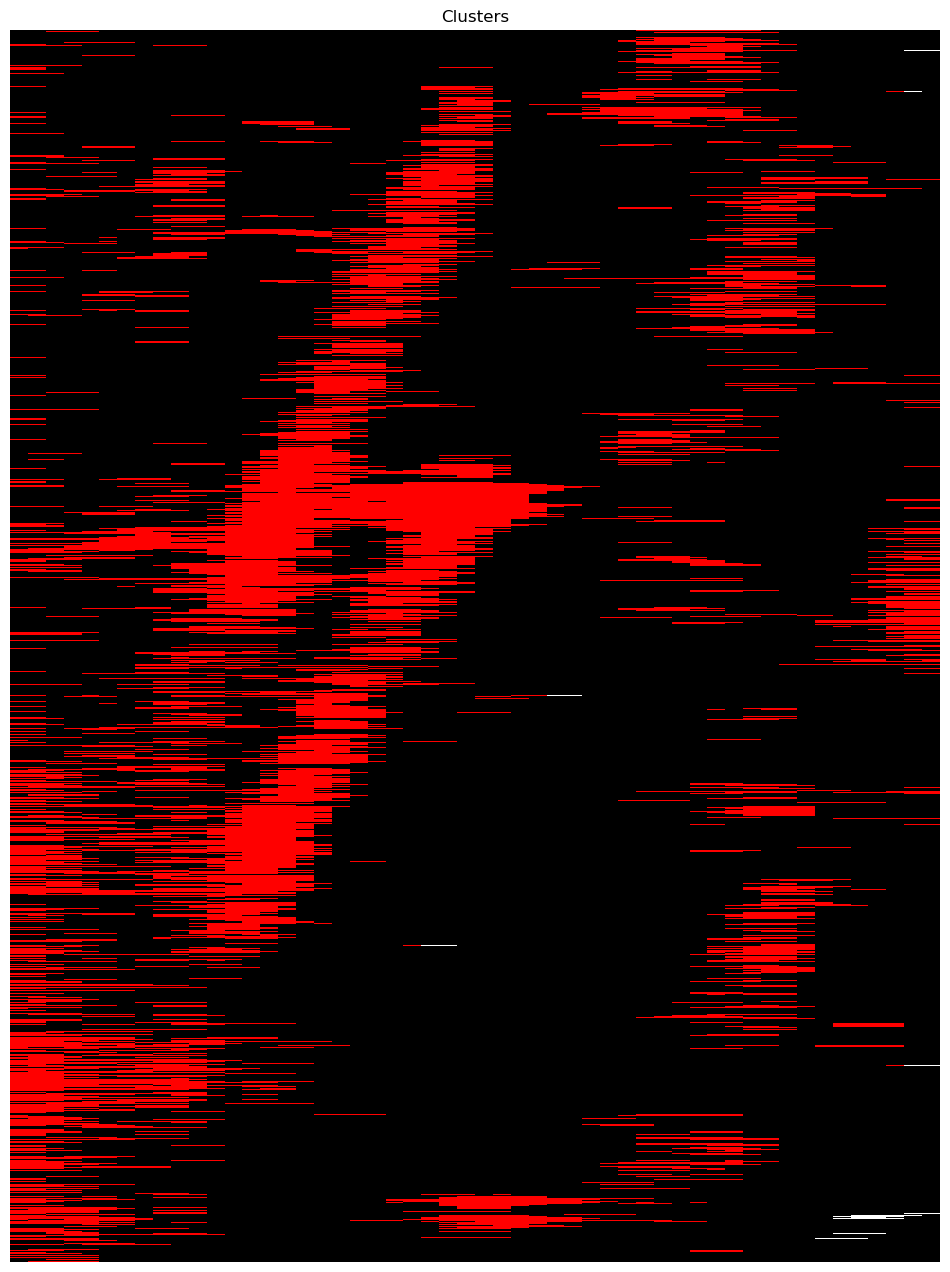

Discarded cluster 0 with R2=0.11311887912660601 (<0.6)


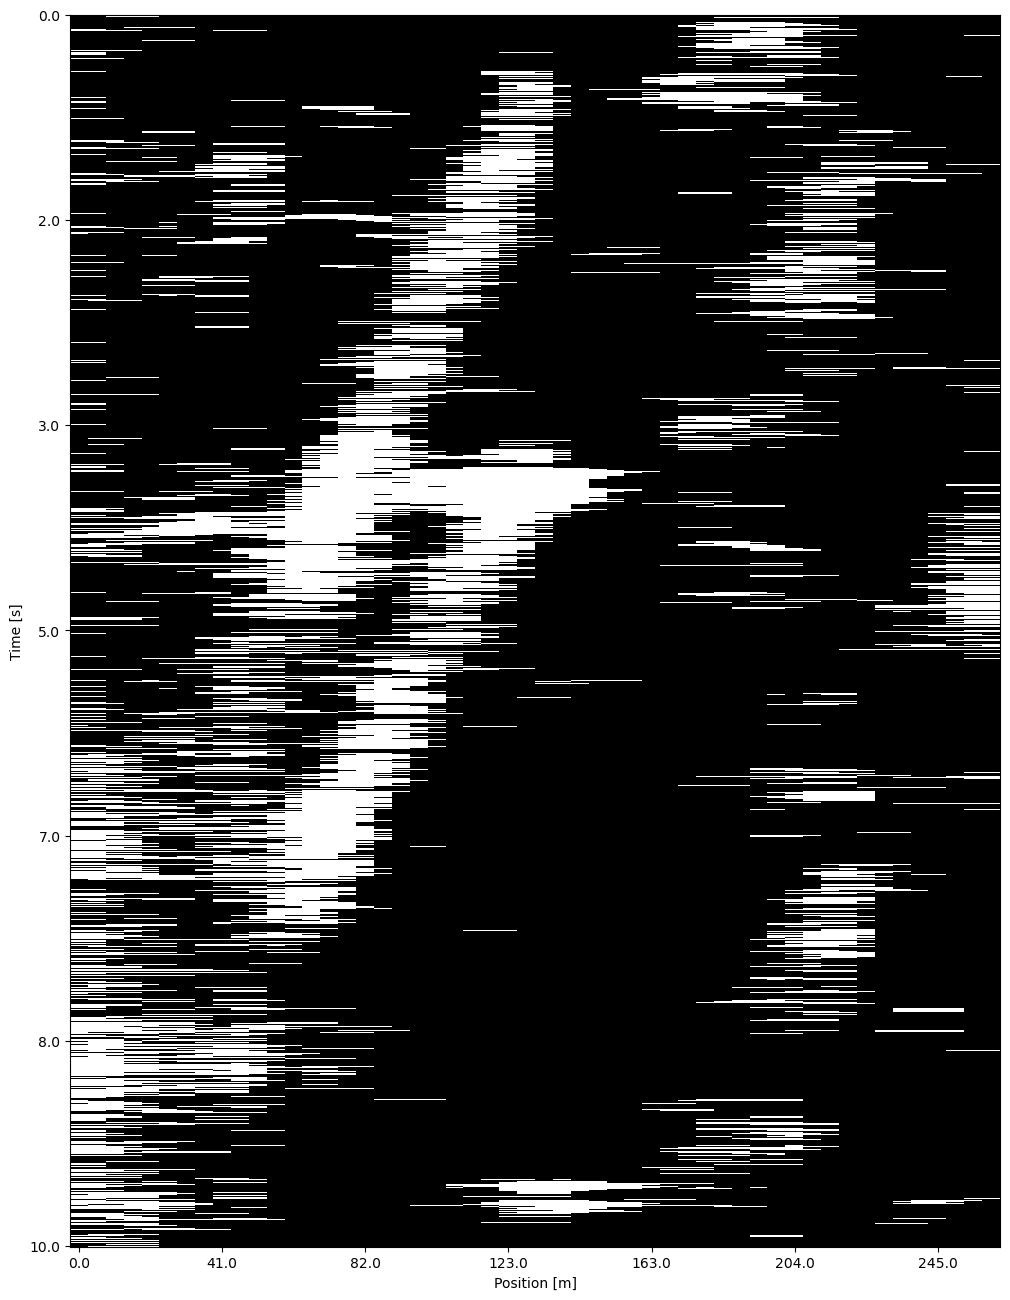

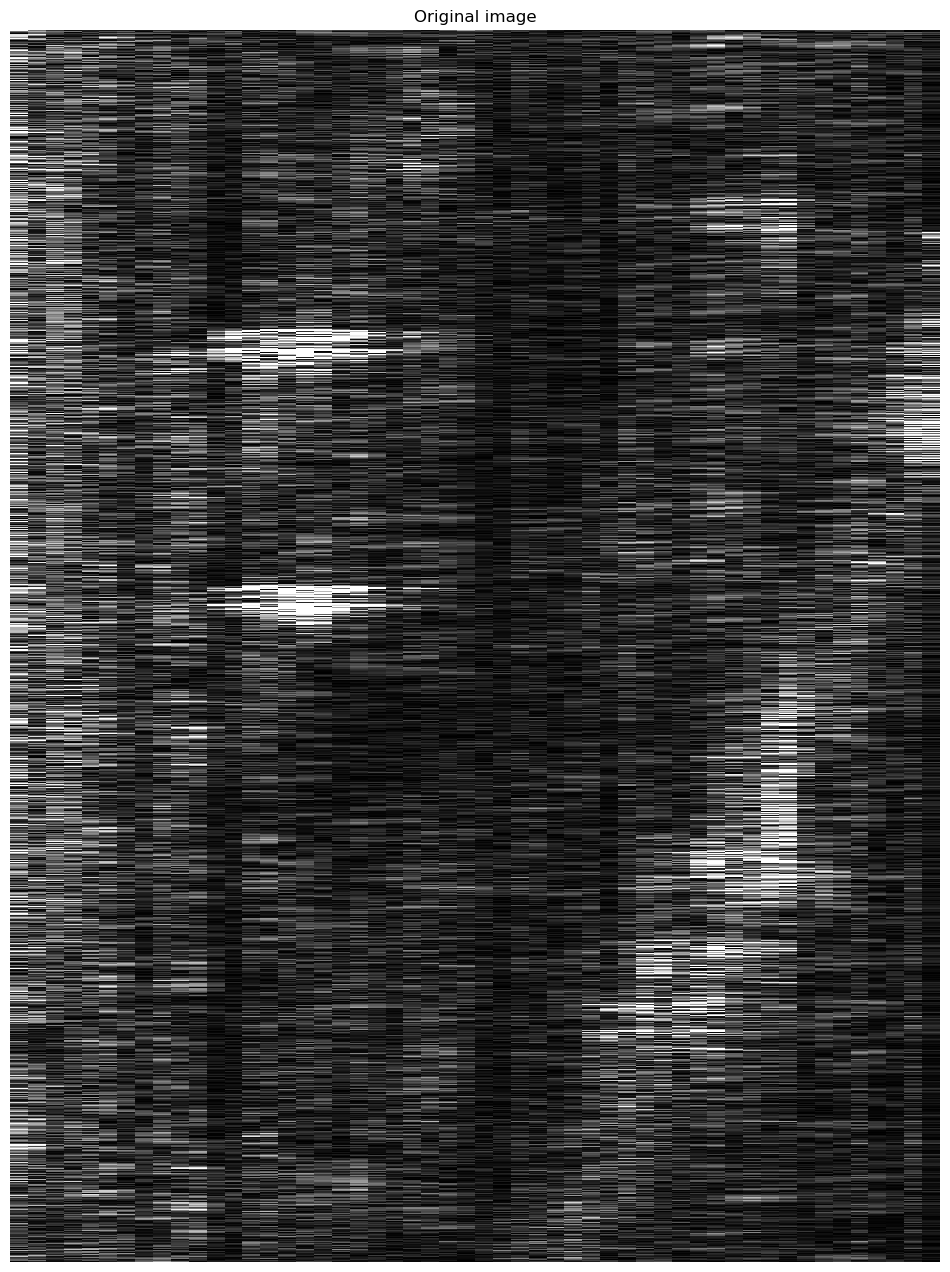

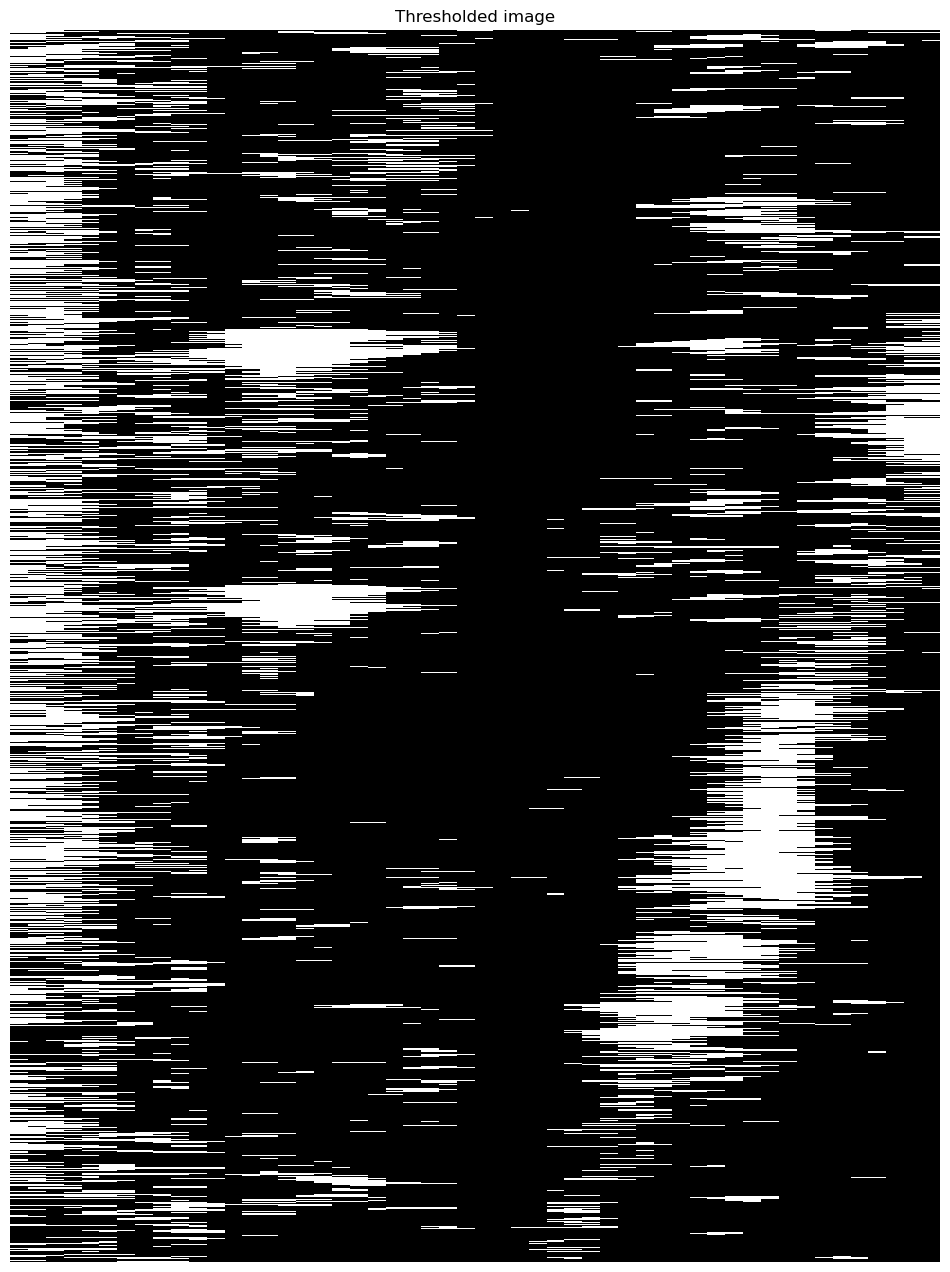

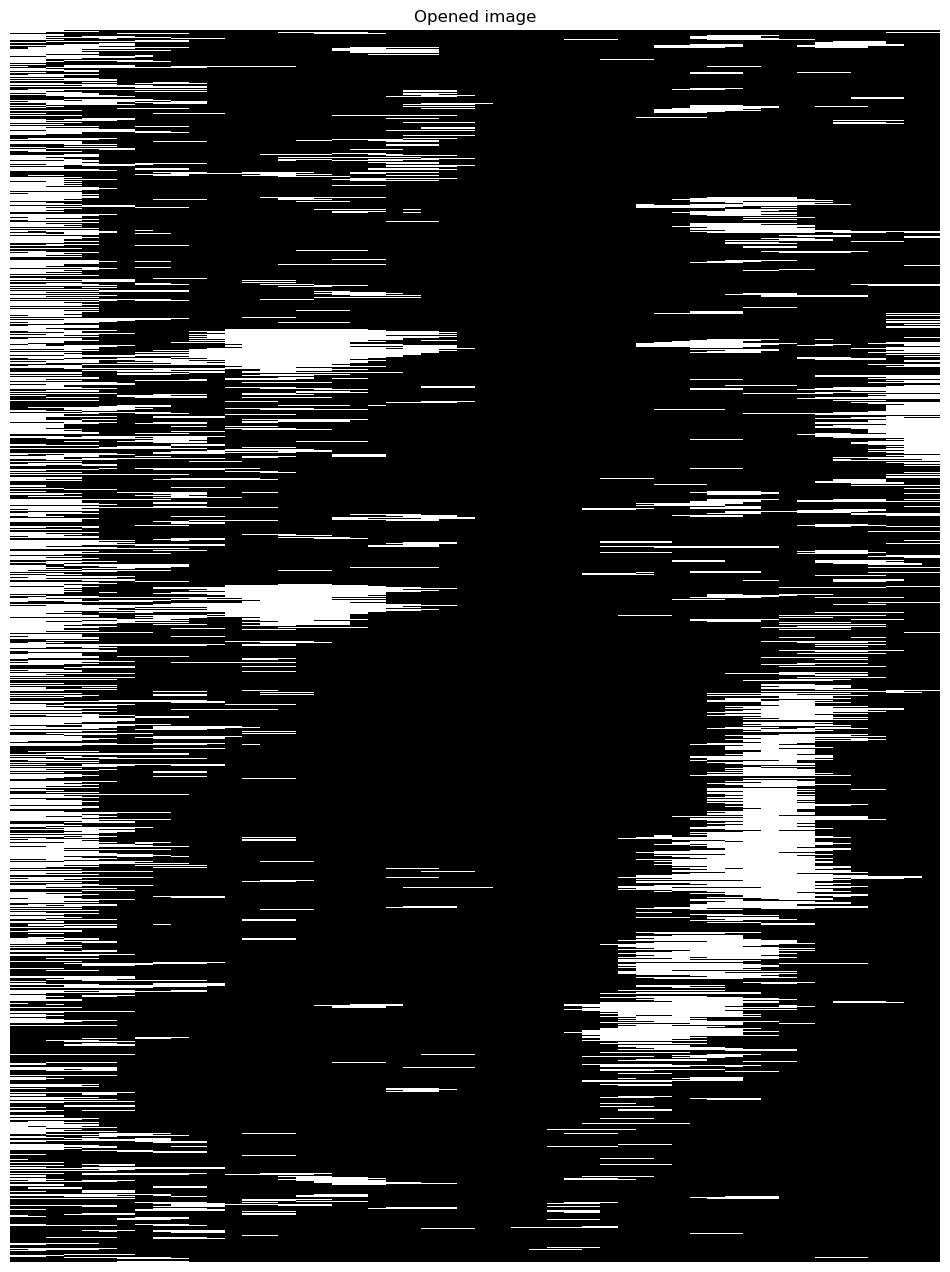

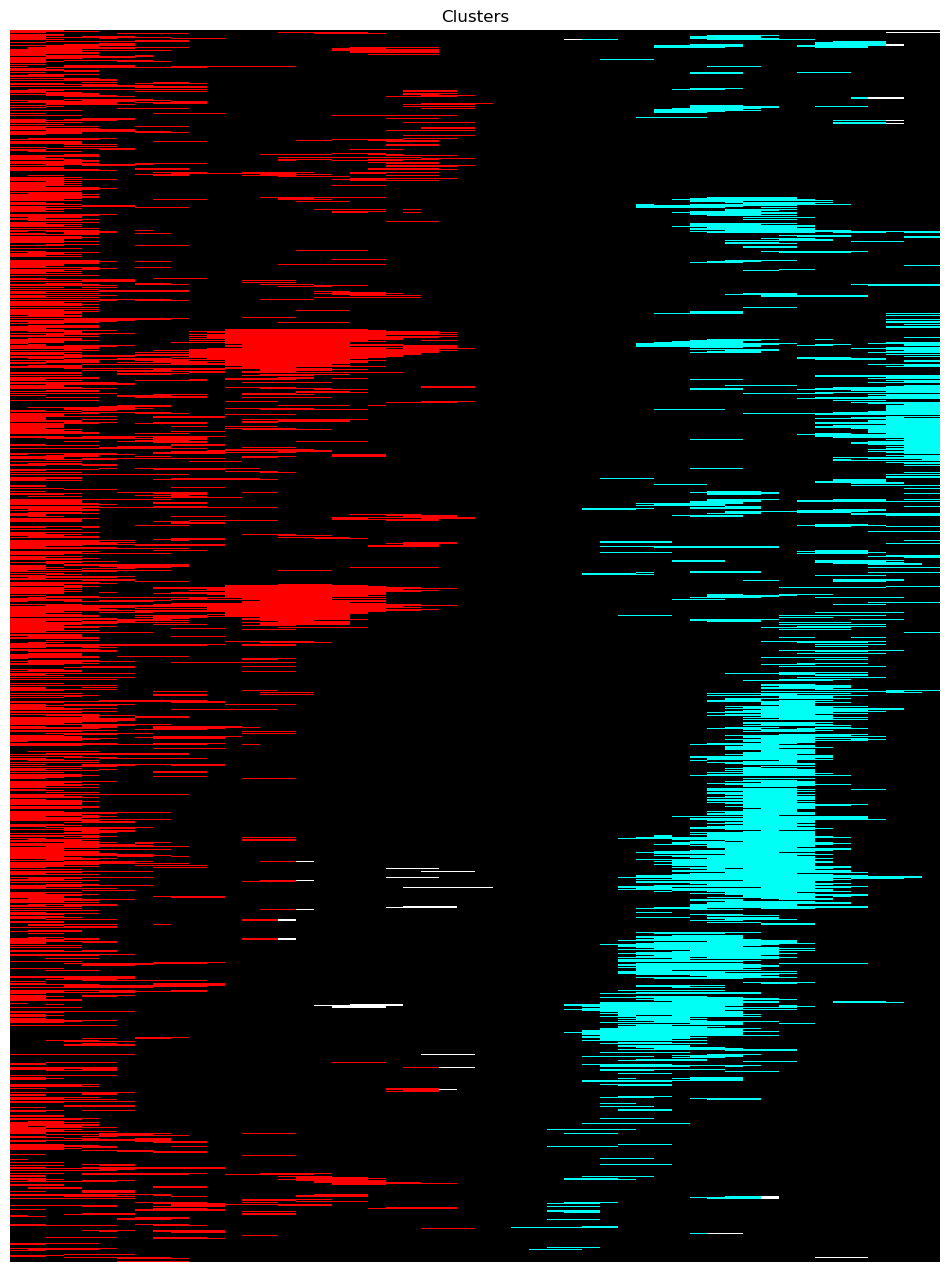

Discarded cluster 0 with R2=0.025680579408937643 (<0.6)
Discarded cluster 1 with R2=0.2517925180389866 (<0.6)


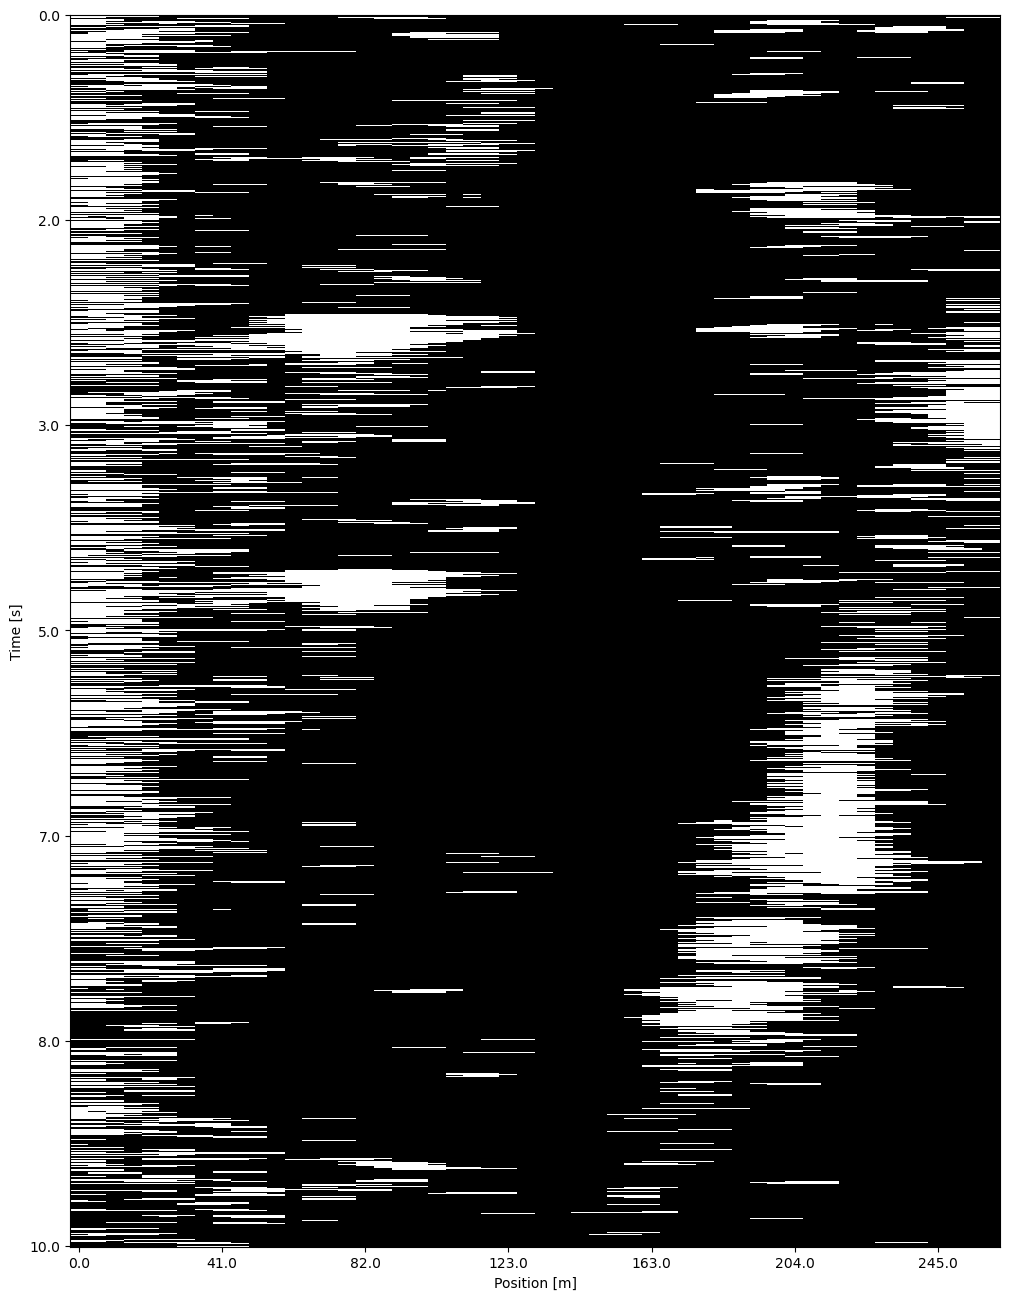

In [369]:
for data in load_all_files():
    detect_velocities(data)